# Figures for Comprehensive Exam Paper
#### David W. Barker

## Purpose: 
The purpose of this notebook is to put all of the code to create the figures for my comps in one place. My other notebooks have been getting extremely messy. This will focus on the second half of my paper after the exotic models. I may add the exotic models into this notebook later, but as I am a bit pressed for time right now, I'll stick to the figures I have yet to make.

In [2]:
# Boilerplate

import h5py
import numpy as np
import matplotlib.pyplot as plt
import scipy
from pylinex import Fitter, BasisSum, PolynomialBasis
import perses
from perses.models import PowerLawTimesPolynomialModel
from pylinex import Basis
import perses
import healpy as hp
from PIL import Image
import matplotlib.animation as animation
from astropy.io import fits
import os
import copy
from pylinex import Fitter, BasisSum, PolynomialBasis, MetaFitter, AttributeQuantity
from pylinex import Basis
from pylinex import TrainedBasis
import pylinex
import py21cmsig
import importlib
import corner
import lochness
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from importlib import reload
from pylinex import RepeatExpander, ShapedExpander, NullExpander,\
    PadExpander, CompiledQuantity, Extractor,  CalculatedQuantity
import spiceypy as spice
from datetime import datetime
import enlighten

# color map for all the plots:
cmap = "viridis"

manager = enlighten.get_manager()
pbar = manager.counter(total=100, desc='Progress')

# Imporant constants
NSIDE = 32 # resolution of the map
NPIX = hp.nside2npix(NSIDE)
NPIX   # total number of pixels (size of the array being used)
location = (-23.815,182.25)  # The lat lon location of the moon landing site
spice_kernels = "/home/dbarker7752/lochness/input/spice_kernels/" #location of the spice kernels
frequencies = np.arange(6,50,0.1)

# Cosmological Parameters
H0 = 67.36     # Hubble constant 
h = H0/100     # H0
omM0 = 0.3152   # Omega matter today
omB0 = 0.0493   # Omega baryons today 
omK0 = 0        # Omega curvature today
omC0 = 0.2645   # Omega cold dark matter today 
#omR0 = 8.98e-5  # Omega radiation today
omR0=8.600000001024455e-05  # Omega radiation from 21cm FAST
omL0 = 0.6847   # Omega Dark Energy today

### Boilerplate arrays for healpy (changes with a change in resolution)
thetas = hp.pix2ang(NSIDE,np.arange(NPIX))[0]*(180/np.pi)
phis = hp.pix2ang(NSIDE,np.arange(NPIX))[1]*(180/np.pi)
coordinate_array = np.ones((NPIX,2))
for i in np.arange(NPIX):
    coordinate_array[i] = np.array([phis[i],thetas[i]])

# HASLAM map
gal = perses.foregrounds.HaslamGalaxy()
haslam_data=gal.get_map(39.93) # gets the actual array of the data for that haslam map

# ULSA map 64 bit
ULSA_direction_raw_64 = fits.open("/home/dbarker7752/21_cm_group/Comprehensive_Exam_Project/ULSA Maps/100.fits")

# This cell fixes the hole in the ULSA data via an interpolation

# This identifies the pixels of the dead zone
vec = hp.ang2vec(np.pi/2*1.1, -np.pi/2*1.05)
indices=hp.query_disc(nside=64,vec=vec,radius=0.1954)
hole_map = copy.deepcopy(ULSA_direction_raw_64[0].data[7])
hole_map[indices] = 10000000
# hp.mollview(ULSA_direction_raw_64[0].data[7])
# These indices will be our region 10 which is the region we ignore
indices_deadzone = indices


x = np.arange(hp.nside2npix(64))
x = np.delete(x,indices_deadzone) # Gets rid of the dead zone
ULSA_min_deadzone = copy.deepcopy(ULSA_direction_raw_64[0].data)
for i,data in enumerate(ULSA_direction_raw_64[0].data):
    y = data
    y = np.delete(y,indices_deadzone)
    interpolator = scipy.interpolate.CubicSpline(x,y)
    for j in indices_deadzone:
        ULSA_min_deadzone[i][j] = interpolator(j)
# hp.mollview(ULSA_min_deadzone[7])

ULSA_direction_64 = ULSA_min_deadzone

# creates a list of all the beam file names.
path = "/home/dbarker7752/21_cm_group/Comprehensive_Exam_Project/Varied_Regolith/Beams"
files = []
for file in os.listdir(path):
    files.append(path+"/"+file)

# some other useful global variables
galaxy_map_64 = ULSA_direction_64    # default galaxy map


# ULSA map 32 bit
ULSA_direction_raw = fits.open("/home/dbarker7752/21_cm_group/Comprehensive_Exam_Project/ULSA Maps/000.fits")
ULSA_frequency = fits.open("/home/dbarker7752/21_cm_group/Comprehensive_Exam_Project/ULSA Maps/210.fits")
ULSA_constant = fits.open("/home/dbarker7752/21_cm_group/Comprehensive_Exam_Project/ULSA Maps/220.fits")

# This cell fixes the hole in the ULSA data via an interpolation

# This identifies the pixels of the dead zone
vec = hp.ang2vec(np.pi/2*1.1, -np.pi/2*1.05)
indices=hp.query_disc(nside=NSIDE,vec=vec,radius=0.1954)
hole_map = copy.deepcopy(ULSA_direction_raw[0].data[7])
hole_map[indices] = 10000000
# hp.mollview(ULSA_direction_raw[0].data[7])
# These indices will be our region 10 which is the region we ignore
indices_deadzone = indices


x = np.arange(NPIX)
x = np.delete(x,indices_deadzone) # Gets rid of the dead zone
ULSA_min_deadzone = copy.deepcopy(ULSA_direction_raw[0].data)
for i,data in enumerate(ULSA_direction_raw[0].data):
    y = data
    y = np.delete(y,indices_deadzone)
    interpolator = scipy.interpolate.CubicSpline(x,y)
    for j in indices_deadzone:
        ULSA_min_deadzone[i][j] = interpolator(j)
# hp.mollview(ULSA_min_deadzone[7])

ULSA_direction = ULSA_min_deadzone

# creates a list of all the beam file names.
path = "/home/dbarker7752/21_cm_group/Comprehensive_Exam_Project/Varied_Regolith/Beams"
files = []
for file in os.listdir(path):
    files.append(path+"/"+file)

# some other useful global variables
galaxy_map = ULSA_direction    # default galaxy map
test_times1 = [[2026,12,22,1,0,0]]   # list of times LOCHNESS will rotate the sky for 
frequency_array = np.array(range(1,51))   # list of frequencies we're evaluating at   

# modifies the galaxy map to not have the CMB (to make it consistent with the delta CMB convention of the signal)
galaxy_map_minCMB = copy.deepcopy(galaxy_map)
redshift_array = 1420.4/frequency_array-1
# This loop creates a CMB subtracted galaxy map to input into LOCHNESS
for i,j in enumerate(redshift_array):
    galaxy_map_minCMB[i] = galaxy_map[i] - py21cmsig.T_gamma(j)
galaxy_map_minCMB[np.where(galaxy_map_minCMB<0.0)] = 0   # Gets rid of the negatives that plague this ULSA map (not sure why they are they)
f = h5py.File("/home/dbarker7752/21_cm_group/Comprehensive_Exam_Project/foreground_array_minCMB","r")
foreground_array_minCMB = f["foreground_array"]


# radiometer noise
sigT = lambda T_b, N, dnu, dt: T_b/(N*(np.sqrt(dnu*dt)))
# Noise parameters
dnu = 1e6
dt = 10000*3600 # first number is the number of hours of integration time
N_antenna = 2

# Synchrotron Equation
synch = lambda f,A,B,c : A*(f/408)**(B+c*np.log(f/408))  # taken from page 6 of Hibbard et al. 2023 Apj. Arbitrarily chose 25 as my v0

# This identifies the pixels of the absorption region
vec = hp.ang2vec(np.pi/2, 0)
indices=hp.query_disc(nside=NSIDE,vec=vec,radius=0.85)
absorp_map = copy.deepcopy(ULSA_direction[7])
# absorp_map[indices] = 10000000
absorp_indices = indices[np.where(absorp_map[indices] < 1450000)][750:906]
absorp_map[absorp_indices] = 10000000

manager = enlighten.get_manager()
pbar = manager.counter(total=100, desc='Progress')

n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]

# frequencies = np.arange(6,50,0.1)
frequencies = np.arange(6,50,0.25)
## RMS ##
#simulation_test = py21cmsig.simulation_run_raw(frequencies,files[0],foreground_array_minCMB,test_times1,dnu,dt,omR0,omM0,omK0,omL0,omB0) # needs to be run to get RMS, that's its only purpose

rms_mean = 0.05
rms_std = 0.009


# Shows the regions
best_foreground_model = py21cmsig.make_foreground_model(np.arange(5,51),5,ULSA_direction,7,rms_mean,rms_std,ev_num=10,scale=0.2, \
                                         show_region_map=False,absorption_region=False)
region_indices = best_foreground_model[10]

# Shows the rotated regions
best_foreground_model_rotated = py21cmsig.make_foreground_model(np.arange(5,51),5,foreground_array_minCMB[0],7,rms_mean,rms_std,ev_num=10,scale=0.2, \
                                         show_region_map=False,absorption_region=False)
region_indices_rotated = best_foreground_model_rotated[10]

# creates the fiducial Lambda CDM signal
# parameter_array = np.array([[omR0,0],[omM0,0.013],[omK0,0],[omL0,0.0062],[omB0,0.00014/h**2]])
parameter_array = np.array([[omR0,0],[omM0,0],[omK0,0],[omL0,0],[omB0,0/h**2]])
fiducial_signal = py21cmsig.lambdaCDM_training_set(frequencies,parameter_array,1)[0][0]

# This loads in your raw training set
f = h5py.File("/home/dbarker7752/21_cm_group/Comprehensive_Exam_Project/Varied_Regolith/Training_Set","r")
varied_regolith_training_set_raw= f["Foreground_Training_Set"]
varied_regolith_training_set_raw_params = f["Parameters_of_Beams"]

# Loads up the raw sky maps
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comprehensive_Exam_Project/Varied_Regolith/varied_beams_ULSA_sky_maps","r")
raw_sky_maps = hdf5["sky_maps"]
raw_sky_maps.shape

# This creates the sky maps that are properly rotated and normalized
beams = np.zeros((len(files),50,NPIX))
beam_euler_angle = [0,90,90]
derp = h5py.File("/home/dbarker7752/21_cm_group/Comprehensive_Exam_Project/Varied_Regolith/Raw_Beam_Maps_64","r")
beam_maps= derp["raw_beam_maps"]

# for n in tqdm(range(len(files))):
#     for nu in range(50):
#         f=beam_maps[n][nu]
#         rotated_beam = hp.Rotator(rot=beam_euler_angle).rotate_map_pixel(f)
#         rotated_beam[np.where(rotated_beam<0.0)] = 0
#         normalized_beam = rotated_beam/np.sum(rotated_beam)
#         beams[n][nu] = normalized_beam

f = h5py.File("/home/dbarker7752/21_cm_group/Comprehensive_Exam_Project/normalized_beams","r")
beams = f["normalized_beams"]

beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps

B_value_functions = py21cmsig.B_value_interp(beam_sky_training_set,beam_sky_training_set_params,\
                         frequencies,sky_map,reference_frequency,n_regions)

save_path = "/home/dbarker7752/21_cm_group/Comprehensive_Exam_Project/Comps_Figures_and_Data/" 

# creates a perfect beam that does not distort the foreground at all, just cuts it off at the horizon
data1=(foreground_array_minCMB[0]*beams[1])
test44=np.ones(NPIX)
test44[np.where(data1[49] == 0)] = 0
perfect_beam = test44
perfect_beam_normalized = perfect_beam/perfect_beam.sum()
perfect_beam_normalized.sum()
perfect_beam_array = np.zeros((50,NPIX))
for n in range(50):
    perfect_beam_array[n] = perfect_beam_normalized

# creates a perfect signal that is only adjusted by the horizon
perfect_signal_raw = np.zeros((50))
for n in range(50):
    perfect_signal_raw[n] = np.sum(foreground_array_minCMB[0][n]*perfect_beam_normalized)

pb_interp = scipy.interpolate.CubicSpline(range(1,51),perfect_signal_raw)
perfect_signal = pb_interp(frequencies)

# This creates the sky maps that are properly rotated and normalized 64 bit version. This is loaded in a cell below
# NSIDE = 64 # resolution of the map
# NPIX = hp.nside2npix(NSIDE)
# beams_64 = np.zeros((len(files),50,NPIX))
# beam_euler_angle = [0,90,90]
# derp = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Raw_Beam_Maps_64","r")
# beam_maps= derp["raw_beam_maps"]

# for n in tqdm(range(len(files))):
#     for nu in range(50):
#         f=beam_maps[n][nu]
#         rotated_beam = hp.Rotator(rot=beam_euler_angle).rotate_map_pixel(f)
#         rotated_beam[np.where(rotated_beam<0.0)] = 0
#         normalized_beam = rotated_beam/np.sum(rotated_beam)
#         beams_64[n][nu] = normalized_beam

## Loaded in signal training sets

#lambda CDM
f = h5py.File("/home/dbarker7752/21_cm_group/Comprehensive_Exam_Project/signal_training_sets/lambdaCDM","r")
lambdaCDM_training_set = f["signal_training_set"]
lambdaCDM_training_set_params = f["signal_training_set_parameters"]

# Self-Annihilating Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/Comprehensive_Exam_Project/signal_training_sets/DMAN","r")
DMAN_training_set = f["signal_training_set"]
DMAN_training_set_params = f["signal_training_set_parameters"]

# Decaying Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/Comprehensive_Exam_Project/signal_training_sets/DMD","r")
DMD_training_set = f["signal_training_set"]
DMD_training_set_params = f["signal_training_set_parameters"]

# Early Dark Energy
f = h5py.File("/home/dbarker7752/21_cm_group/Comprehensive_Exam_Project/signal_training_sets/EDE","r")
EDE_training_set = f["signal_training_set"]
EDE_training_set_params = f["signal_training_set_parameters"]

# Extra Radio Background
f = h5py.File("/home/dbarker7752/21_cm_group/Comprehensive_Exam_Project/signal_training_sets/ERB","r")
ERB_training_set = f["signal_training_set"]
ERB_training_set_params = f["signal_training_set_parameters"]

# Baryon-Dark Matter Interaction (MCDM)
f = h5py.File("/home/dbarker7752/21_cm_group/Comprehensive_Exam_Project/signal_training_sets/MCDM","r")
MCDM_training_set = f["signal_training_set"]
MCDM_training_set_params = f["signal_training_set_parameters"]


Prepared Haslam map in 0.19 s.


FileNotFoundError: [Errno 2] No such file or directory: '/home/dbarker7752/21_cm_group/ULSA Maps/100.fits'

In [2]:
#lambda CDM
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/lambdaCDM","r")
lambdaCDM_training_set = f["signal_training_set"]
lambdaCDM_training_set_params = f["signal_training_set_parameters"]

# Self-Annihilating Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMAN","r")
DMAN_training_set = f["signal_training_set"]
DMAN_training_set_params = f["signal_training_set_parameters"]

# Decaying Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMD","r")
DMD_training_set = f["signal_training_set"]
DMD_training_set_params = f["signal_training_set_parameters"]

# Early Dark Energy
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/EDE","r")
EDE_training_set = f["signal_training_set"]
EDE_training_set_params = f["signal_training_set_parameters"]

# Extra Radio Background
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/ERB","r")
ERB_training_set = f["signal_training_set"]
ERB_training_set_params = f["signal_training_set_parameters"]

# Baryon-Dark Matter Interaction (MCDM)
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/MCDM","r")
MCDM_training_set = f["signal_training_set"]
MCDM_training_set_params = f["signal_training_set_parameters"]

### ULSA Galaxy Example and ULSA Galaxy Rotated Example

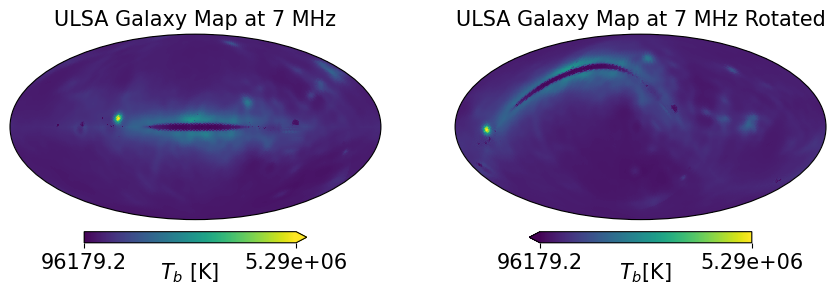

In [3]:
# ULSA Galaxy Example and ULSA Galaxy Rotated Example
fontsize = dict(cbar_label=15, cbar_tick_label=15)
# fontsize["cbar_label"] = 1
# Standard unrotated galaxy
hp.projview(galaxy_map_64[7],unit=r"$T_b$ [K]",cmap= cmap,min=96179.2,max=5290000,fontsize=fontsize,sub=(1,2,1))
plt.title("ULSA Galaxy Map at 7 MHz" ,fontsize=15)
# plt.savefig(save_path+"ULSA_64bit_Standard")


# ## next few lines create and save the rotated galaxy to save time when loading this up again.
# # galaxy creation part
# # Now we rotate it into a frame consistent with a LuSEE-Night observation window.
# rotated_64_ULSA = lochness.LOCHNESS(spice_kernels,test_times1,location,galaxy_map=galaxy_map_64).lunar_frame_galaxy_maps[0]
# rotated_64_ULSA[np.where(rotated_64_ULSA<0.0)] = 0
# # HDF5 part
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/rotated_64_ULSA","w")
# hdf5.create_dataset("rotated_sky_maps",data=rotated_64_ULSA)
# hdf5.close()
# ## End of galaxy map creation and hdf5 saving code

## next two lines load the hdf5 file for the galaxy rotation
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/rotated_64_ULSA","r")
rotated_64_ULSA = hdf5["rotated_sky_maps"]
## End of hdf5 loading code

hp.projview(rotated_64_ULSA[7],min=96179.2,max=5290000,cmap=cmap,unit=r"$T_b $[K]",fontsize=fontsize,sub=(1,2,2))
plt.title("ULSA Galaxy Map at 7 MHz Rotated" ,fontsize=15)
plt.savefig(save_path+"ULSA_64bit_Rotated")

In [4]:
coord_text_obj.set

NameError: name 'coord_text_obj' is not defined

## Five Region Model with Rotated Galaxy
- We'll use the rotated galaxy for examples from here on out since that's the actual foreground we used as our base model.

100%|██████████| 10/10 [00:00<00:00, 6484.70it/s]


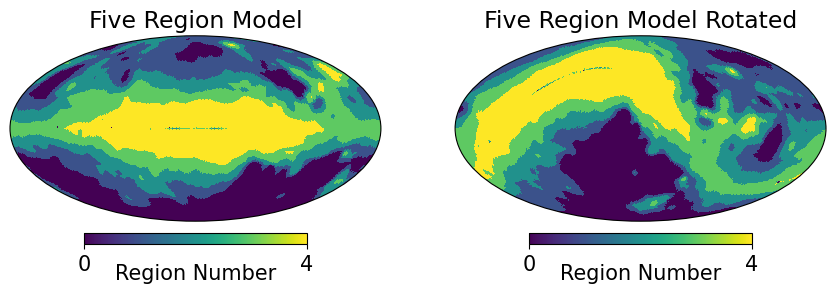

In [ ]:
# Shows the regions
best_foreground_model = py21cmsig.make_foreground_model(np.arange(5,51),5,ULSA_direction_64,25,1,1,ev_num=10,scale=0.2, \
                                         show_region_map=False,absorption_region=False)
region_indices = best_foreground_model[10]
hp.projview(best_foreground_model[11],unit = "Region Number",cmap="viridis",sub=(1,2,1),fontsize=fontsize)
plt.title("Five Region Model", fontsize=17)
# plt.savefig(save_path+"five_region_model")

## next two lines load the hdf5 file for the galaxy rotation
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/rotated_64_ULSA","r")
rotated_64_ULSA = hdf5["rotated_sky_maps"]
## End of hdf5 loading code

# Shows the rotated regions
best_foreground_model_rotated = py21cmsig.make_foreground_model(np.arange(5,51),5,rotated_64_ULSA,25,1,1,ev_num=10,scale=0.2, \
                                         show_region_map=False,absorption_region=False)
region_indices_rotated = best_foreground_model_rotated[10]
hp.projview(best_foreground_model_rotated[11],unit = "Region Number",sub=(1,2,2),fontsize=fontsize)
plt.title("Five Region Model Rotated", fontsize=17)
plt.savefig(save_path+"five_region_model_rotated")

## Varied Foreground Example

100%|██████████| 2/2 [00:00<00:00, 5749.56it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.59202418e+01 -2.65279830e+00 -1.37293590e-02  1.66130589e+01
 -2.69062579e+00 -1.47582387e-02  1.89769800e+01 -2.68235795e+00
 -1.34495335e-02  2.42115565e+01 -2.66682587e+00 -1.20169084e-02
  5.22431891e+01 -2.65055339e+00 -2.42275191e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]


100%|██████████| 176/176 [00:01<00:00, 94.83it/s] 


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 192.92it/s]


[0.05, 0.025, 0.05]


100%|██████████| 2/2 [00:00<00:00, 11052.18it/s]


[[ 1.51242297e+01  1.67162539e+01 -2.58647835e+00 -2.71911826e+00
  -1.30428910e-02 -1.44158269e-02]
 [ 1.57824060e+01  1.74437118e+01 -2.62336014e+00 -2.75789143e+00
  -1.40203268e-02 -1.54961507e-02]
 [ 1.80281310e+01  1.99258289e+01 -2.61529900e+00 -2.74941689e+00
  -1.27770568e-02 -1.41220102e-02]
 [ 2.30009787e+01  2.54221344e+01 -2.60015522e+00 -2.73349652e+00
  -1.14160630e-02 -1.26177538e-02]
 [ 4.96310296e+01  5.48553485e+01 -2.58428955e+00 -2.71681722e+00
  -2.30161431e-02 -2.54388950e-02]]


Text(0.5, 1.0, 'Difference of Varied Foreground from Base ULSA Model')

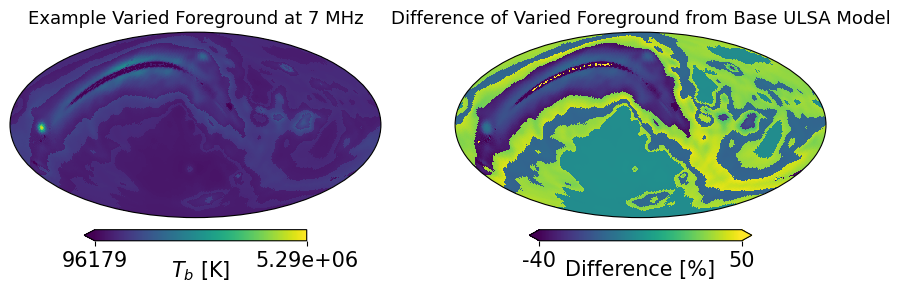

In [ ]:
# Simulation and Training Set for a single LST
parameter_array = np.array([[omR0,0],[omM0,0],[omK0,0],[omL0,0],[omB0,0/h**2]])
fiducial_signal = py21cmsig.lambdaCDM_training_set(frequencies,parameter_array,1)[0][0]

# Loads up the raw sky maps
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/varied_beams_ULSA_sky_maps","r")
raw_sky_maps = hdf5["sky_maps"]
raw_sky_maps.shape

B_value_functions = py21cmsig.B_value_interp(beam_sky_training_set,beam_sky_training_set_params,\
                         frequencies,sky_map,reference_frequency,n_regions)

# This loads in your raw training set
f = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Training_Set","r")
varied_regolith_training_set_raw= f["Foreground_Training_Set"]
varied_regolith_training_set_raw_params = f["Parameters_of_Beams"]

## Creates a foreground for the simulation:
dt = 10000*3600
# custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
# parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
parameter_variation = [0,0,0]

signal_model = fiducial_signal

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam = py21cmsig.simulation_run(foreground_for_sim,signal_model,N_antenna,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")


# data = simulation_test_beam[0]
# one_sigma_rms = rms_std
# training_set = varied_regolith_training_set_raw
# training_set_parameters = varied_regolith_training_set_raw_params
# signal_extraction_return = signal_extraction(data,rms_mean,rms_std,training_set,training_set_parameters,N=10000,sigma_tolerance=3,iteration_limit=10)


## Creates a training set with varied foreground and beams:

# custom_parameter_range = np.array([[1,2],[3.3,3.5],[4.2,4.7]])
custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
rms_mean = 0.05
rms_std = 0.009
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 500 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 500
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam[0],rms_mean,rms_std,foreground_run[3],foreground_run[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)
for r in range(n_regions):
    new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
    # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
    fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
    fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


print(fg_range_array)

## next two lines load the hdf5 file for the galaxy rotation
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/rotated_64_ULSA","r")
rotated_64_ULSA = np.array(hdf5["rotated_sky_maps"])
## End of hdf5 loading code
original = np.array(rotated_64_ULSA)
copy_rotated_ULSA = rotated_64_ULSA
copy_rotated_ULSA[7][region_indices_rotated[0]] += foreground_run_set[5][0][0][4]
copy_rotated_ULSA[7][region_indices_rotated[1]] += foreground_run_set[5][0][1][4]
copy_rotated_ULSA[7][region_indices_rotated[2]] += foreground_run_set[5][0][2][4]
copy_rotated_ULSA[7][region_indices_rotated[3]] += foreground_run_set[5][0][3][4]
copy_rotated_ULSA[7][region_indices_rotated[4]] += foreground_run_set[5][0][4][4]

copy_rotated_ULSA[40][region_indices_rotated[0]] += foreground_run_set[5][100][0][136]
copy_rotated_ULSA[40][region_indices_rotated[1]] += foreground_run_set[5][100][1][136]
copy_rotated_ULSA[40][region_indices_rotated[2]] += foreground_run_set[5][100][2][136]
copy_rotated_ULSA[40][region_indices_rotated[3]] += foreground_run_set[5][100][3][136]
copy_rotated_ULSA[40][region_indices_rotated[4]] += foreground_run_set[5][100][4][136]

hp.projview(copy_rotated_ULSA[7],unit=r"$T_b$ [K]",min=96179, max= 5290000,cmap=cmap,fontsize=fontsize,sub=(1,2,1) )
plt.title("Example Varied Foreground at 7 MHz", fontsize=13)
# plt.savefig(save_path+"example_foreground_trainingset_7MHz")
hp.projview((copy_rotated_ULSA[7]-original[7])/original[7]*100,min=-40,max=50,unit="Difference [%]",cmap=cmap,fontsize=fontsize,sub=(1,2,2))
plt.title("Difference of Varied Foreground from Base ULSA Model" ,fontsize = 13)
# plt.savefig(save_path+"example_fgts_diff")

## Varied Foreground Training Set Distribution

100%|██████████| 176/176 [00:00<00:00, 228.61it/s]


[[1.  1. ]
 [3.4 3.4]
 [4.6 4.6]]


100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


[0.05, 0.025, 0.05]


100%|██████████| 2/2 [00:00<00:00, 14290.64it/s]


[[ 1.51242297e+01  1.67162539e+01 -2.58647835e+00 -2.71911826e+00
  -1.30428910e-02 -1.44158269e-02]
 [ 1.57824060e+01  1.74437118e+01 -2.62336014e+00 -2.75789143e+00
  -1.40203268e-02 -1.54961507e-02]
 [ 1.80281310e+01  1.99258289e+01 -2.61529900e+00 -2.74941689e+00
  -1.27770568e-02 -1.41220102e-02]
 [ 2.30009787e+01  2.54221344e+01 -2.60015522e+00 -2.73349652e+00
  -1.14160630e-02 -1.26177538e-02]
 [ 4.96310296e+01  5.48553485e+01 -2.58428955e+00 -2.71681722e+00
  -2.30161431e-02 -2.54388950e-02]]


100%|██████████| 10/10 [00:00<00:00, 5098.22it/s]


Text(0, 0.5, '$T_b$ [K]')

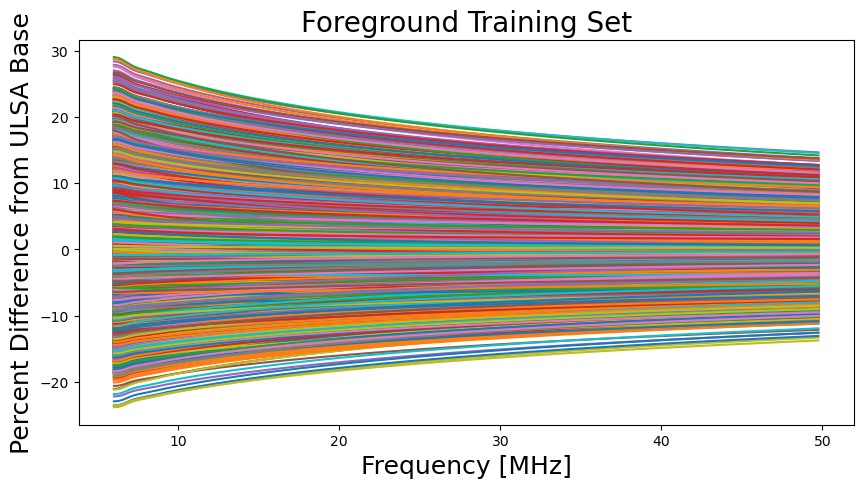

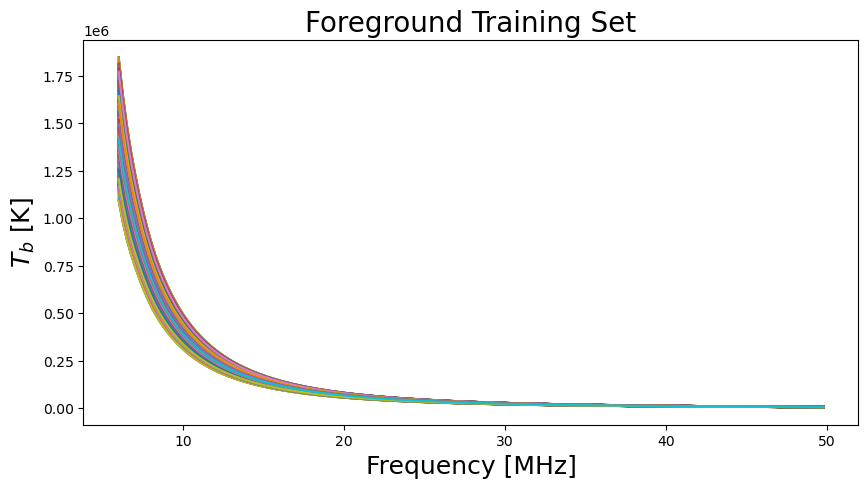

In [ ]:

## Creates a training set with varied foreground and beams:

# custom_parameter_range = np.array([[1,2],[3.3,3.5],[4.2,4.7]])
custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])  # For making a random foreground
parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
rms_mean = 0.05
rms_std = 0.009
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 100000
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam[0],rms_mean,rms_std,foreground_run[3],foreground_run[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)
for r in range(n_regions):
    new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
    # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
    fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
    fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


print(fg_range_array)

## This portion creates the foreground training set
NSIDE = 32
NPIX = hp.nside2npix(NSIDE)

best_foreground_model_rotated_32 = py21cmsig.make_foreground_model(np.arange(5,51),5,foreground_array_minCMB[0],25,1,1,ev_num=10,scale=0.2, \
                                         show_region_map=False,absorption_region=False)
region_indices_rotated_32 = best_foreground_model_rotated_32[10]
# Let's weight each region correctly:
masked_indices = np.where(beams[0][-1] <= 0)[0]
masked_region_indices = {}
for r in region_indices_rotated_32:  # Creates list of indices per region that exist within the beam
    ones_array = np.ones(NPIX)
    ones_array[masked_indices] = 0
    zeros_array = np.zeros(NPIX)
    zeros_array[region_indices_rotated_32[r]] = 1
    masked_region_indices[r] = np.where(ones_array*zeros_array == 1)

region_1_weight = masked_region_indices[0][0].shape[0]/(NPIX/2)
region_2_weight = masked_region_indices[1][0].shape[0]/(NPIX/2)
region_3_weight = masked_region_indices[2][0].shape[0]/(NPIX/2)
region_4_weight = masked_region_indices[3][0].shape[0]/(NPIX/2)
region_5_weight = masked_region_indices[4][0].shape[0]/(NPIX/2)
region_weights = np.array((region_1_weight,region_2_weight,region_3_weight,region_4_weight,region_5_weight))
region_weights

foreground_training_set = np.zeros((N,len(frequencies)))
for n in range(N):
    new_T = 0
    for r in range(5):
        new_T += foreground_run_set[5][n][r]*region_weights[r]
    foreground_training_set[n] = perfect_signal + new_T

# Displays a training set of ONLY the foregrounds. No beam weights.

plt.figure(figsize=(10, 5))

for n in range(10000):
    plt.plot(frequencies, (foreground_training_set[n]-perfect_signal)/perfect_signal*100)
plt.axhline(0,ls="--",color="black")
plt.title("Foreground Training Set",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="18")
plt.ylabel("Percent Difference from ULSA Base",fontsize="18")
# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
# plt.savefig(save_path+"Foreground_Training_Set")

plt.figure(figsize=(10, 5))

for n in range(10000):
    plt.plot(frequencies, foreground_training_set[n])
plt.plot(frequencies, foreground_training_set[0],color="black",ls="--")
plt.title("Foreground Training Set",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="18")
plt.ylabel(r"$T_b$ [K]",fontsize="18")
# plt.savefig(save_path+"Foreground_Training_Set")

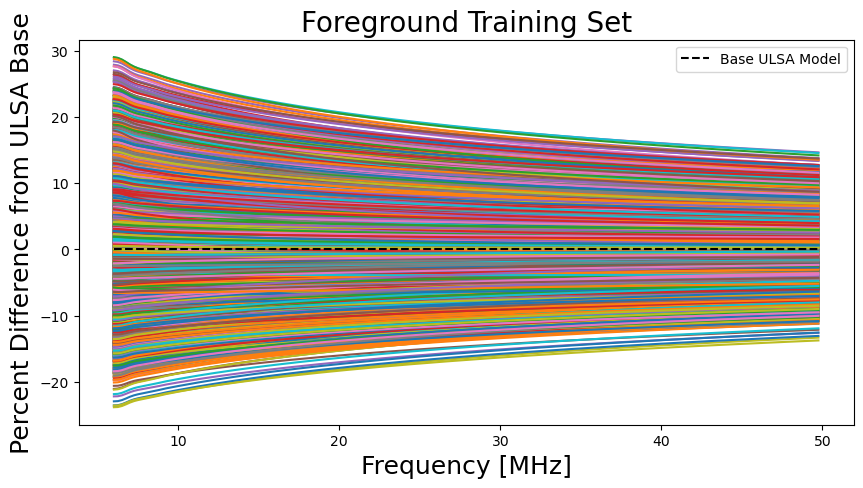

In [14]:
plt.figure(figsize=(10, 5))

for n in range(10000):
    plt.plot(frequencies, (foreground_training_set[n]-perfect_signal)/perfect_signal*100)
plt.plot(frequencies,perfect_signal-perfect_signal,ls="--",color="black",label="Base ULSA Model")
plt.title("Foreground Training Set",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="18")
plt.ylabel("Percent Difference from ULSA Base",fontsize="18")
plt.legend()

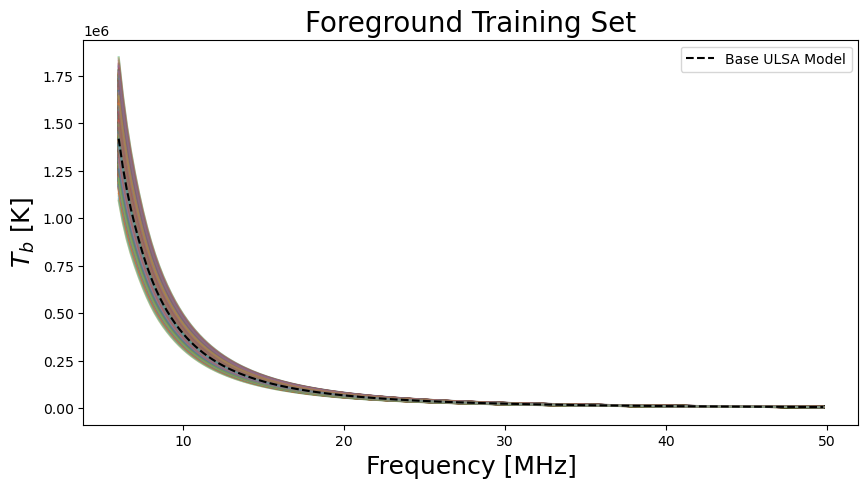

In [9]:
plt.figure(figsize=(10, 5))

for n in range(10000):
    plt.plot(frequencies, foreground_training_set[n],alpha=0.25)
plt.plot(frequencies, foreground_training_set[0],color="black",ls="--",label="Base ULSA Model")
plt.title("Foreground Training Set",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="18")
plt.ylabel(r"$T_b$ [K]",fontsize="18")
plt.legend()
# plt.savefig(save_path+"Foreground_Training_Set")

In [64]:
reload(py21cmsig)

/home/dbarker7752/perses/perses/foregrounds/HaslamGalaxy.py:83: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  self._haslam_map_408 = hp.read_map(file_name, verbose=False)


Prepared Haslam map in 0.162 s.


<module 'py21cmsig' from '/home/dbarker7752/21_cm_group/LuCEE-Night_Simulation/py21cmsig.py'>

## Beam Example

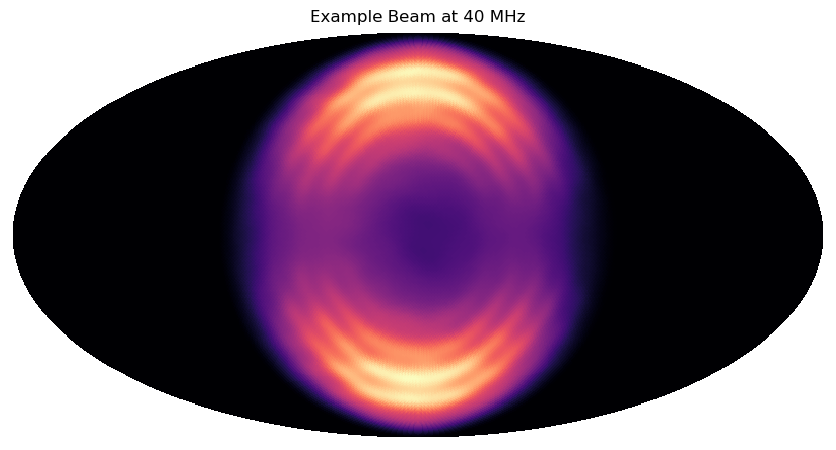

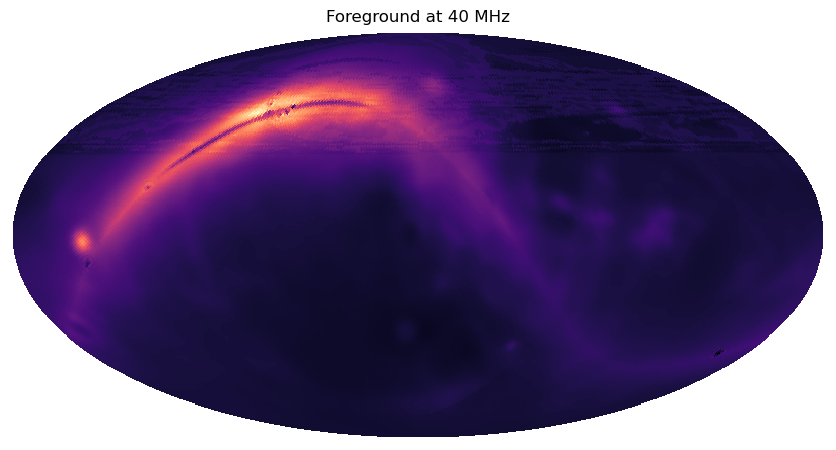

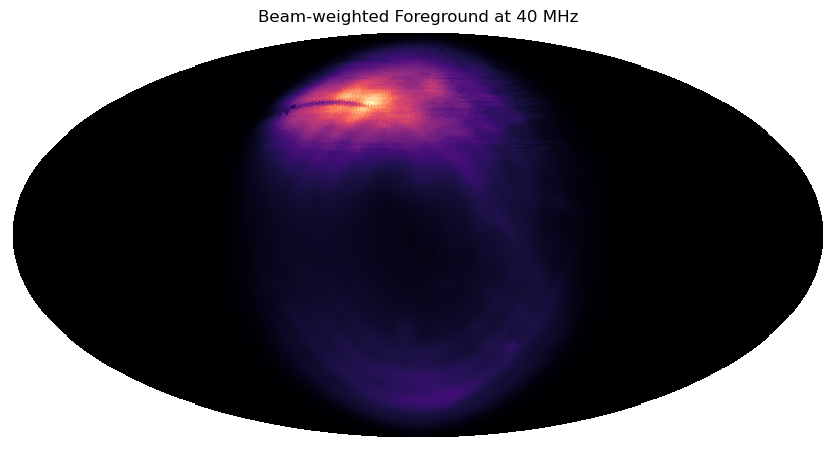

In [14]:
# This creates the sky maps that are properly rotated and normalized 64 bit version
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
beams_64 = np.zeros((len(files),50,NPIX))
beam_euler_angle = [0,90,90]
derp = h5py.File("/home/dbarker7752/21_cm_group/Varied_Regolith/Raw_Beam_Maps_64","r")
beam_maps= derp["raw_beam_maps"]

### Creates an h5py file for 64 bit normalized beams
# for n in tqdm(range(len(files))):
#     for nu in range(50):
#         f=beam_maps[n][nu]
#         rotated_beam = hp.Rotator(rot=beam_euler_angle).rotate_map_pixel(f)
#         rotated_beam[np.where(rotated_beam<0.0)] = 0
#         normalized_beam = rotated_beam/np.sum(rotated_beam)
#         beams_64[n][nu] = normalized_beam
# f = h5py.File("/home/dbarker7752/21_cm_group/normalized_beams_64","w")
# f.create_dataset("normalized_beams",data=beams_64)
# f.close()
### End hdf5 creation code

### Loads hdf5 for normalized beams
f = h5py.File("/home/dbarker7752/21_cm_group/normalized_beams_64","r")
beams_64 = f["normalized_beams"]
### End loading code 
cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
cmap = cmaps[3]
hp.mollview(beams_64[0][40], cbar=False,cmap=cmap)
plt.title("Example Beam at 40 MHz")
plt.savefig(save_path+"Example_Beam_40MHz")

# And now to weight it with the foreground
# First a foreground without a colorbar:
hp.mollview(rotated_64_ULSA[40],cbar=False,cmap=cmap)
plt.title("Foreground at 40 MHz")
plt.savefig(save_path+"ULSA_rot_40MHz_nocbar")

# now beam_weighted:
hp.mollview(rotated_64_ULSA[40]*beams_64[0][40], cbar=False,cmap=cmap)
plt.title("Beam-weighted Foreground at 40 MHz")
plt.savefig(save_path+"ULSA_40MHz_beam-weighted")
plt.show()

## Beam Training Set

100%|██████████| 176/176 [00:03<00:00, 45.46it/s]


[[1.  2. ]
 [3.3 3.5]
 [4.2 4.7]]


100%|██████████| 10000/10000 [00:00<00:00, 91552.10it/s]


[0, 0, 0]


100%|██████████| 2/2 [00:00<00:00, 6100.81it/s]


[[ 1.59202418e+01  1.59202418e+01 -2.65279830e+00 -2.65279830e+00
  -1.37293590e-02 -1.37293590e-02]
 [ 1.66130589e+01  1.66130589e+01 -2.69062579e+00 -2.69062579e+00
  -1.47582387e-02 -1.47582387e-02]
 [ 1.89769800e+01  1.89769800e+01 -2.68235795e+00 -2.68235795e+00
  -1.34495335e-02 -1.34495335e-02]
 [ 2.42115565e+01  2.42115565e+01 -2.66682587e+00 -2.66682587e+00
  -1.20169084e-02 -1.20169084e-02]
 [ 5.22431891e+01  5.22431891e+01 -2.65055339e+00 -2.65055339e+00
  -2.42275191e-02 -2.42275191e-02]]


Text(0, 0.5, 'Percent Difference from ULSA Base')

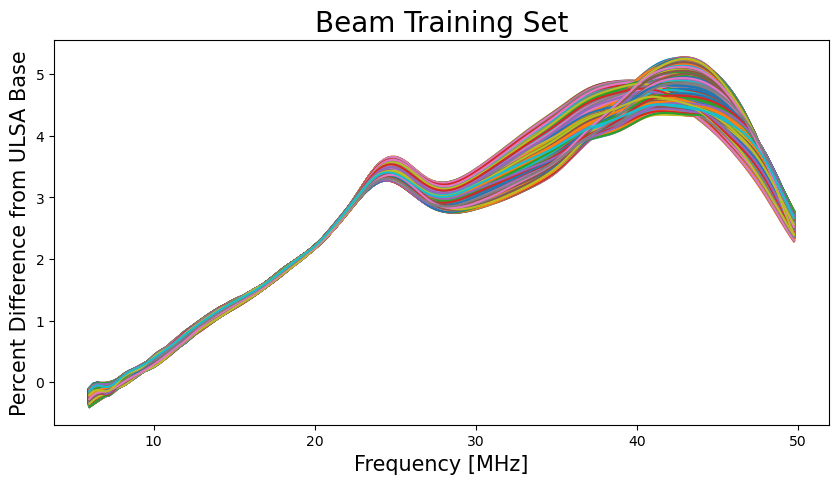

In [7]:

## Creates a training set with varied beams:

custom_parameter_range = np.array([[1,2],[3.3,3.5],[4.2,4.7]])
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])  # For making a random foreground
parameter_variation = [0,0,0]                           # For making a random foreground
rms_mean = 0.05
rms_std = 0.009
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 10000 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam[0],rms_mean,rms_std,foreground_run[3],foreground_run[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)
for r in range(n_regions):
    new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
    # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
    fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
    fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


print(fg_range_array)

# Beam Training Set

plt.figure(figsize=(10, 5))

beam_training_set=foreground_run_set[3]

# Displays a training set of the beams weighting the ULSA base model.
for n in range(10000):
    plt.plot(frequencies, (beam_training_set[n]-perfect_signal)/perfect_signal*100)
plt.title("Beam Training Set",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Percent Difference from ULSA Base",fontsize="15")
# plt.savefig(save_path+"Beam_Training_Set")

  0%|          | 0/176 [00:00<?, ?it/s]

100%|██████████| 176/176 [00:01<00:00, 90.29it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 700/700 [00:04<00:00, 172.65it/s]


[0.05, 0.025, 0.05]


100%|██████████| 2/2 [00:00<00:00, 13025.79it/s]


[[ 1.51242297e+01  1.67162539e+01 -2.58647835e+00 -2.71911826e+00
  -1.30428910e-02 -1.44158269e-02]
 [ 1.57824060e+01  1.74437118e+01 -2.62336014e+00 -2.75789143e+00
  -1.40203268e-02 -1.54961507e-02]
 [ 1.80281310e+01  1.99258289e+01 -2.61529900e+00 -2.74941689e+00
  -1.27770568e-02 -1.41220102e-02]
 [ 2.30009787e+01  2.54221344e+01 -2.60015522e+00 -2.73349652e+00
  -1.14160630e-02 -1.26177538e-02]
 [ 4.96310296e+01  5.48553485e+01 -2.58428955e+00 -2.71681722e+00
  -2.30161431e-02 -2.54388950e-02]]


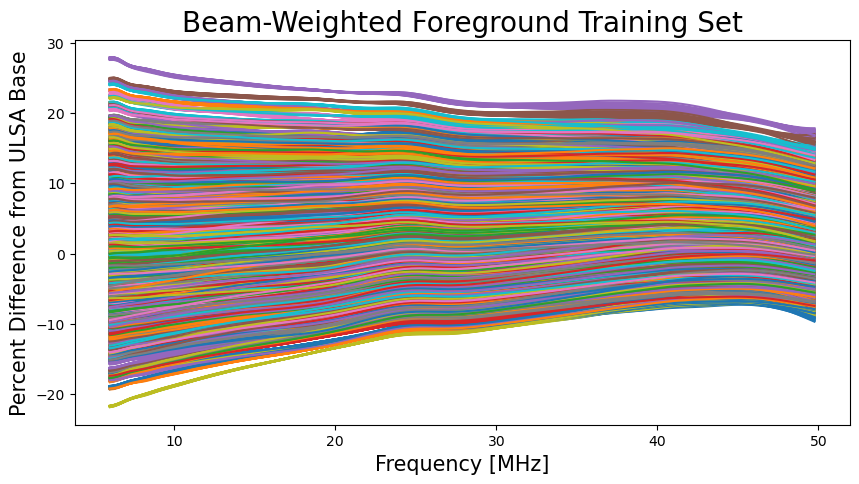

In [53]:
## Creates a training set with varied beams:

custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])
# custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])  # For making a random foreground
parameter_variation = [0.05,0.025,0.05]                              # For making a random foreground
rms_mean = 0.05
rms_std = 0.009
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 700 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 700
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam[0],rms_mean,rms_std,foreground_run[3],foreground_run[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)
for r in range(n_regions):
    new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
    # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
    fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
    fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


print(fg_range_array)

plt.figure(figsize=(10, 5))
# Beam-Weighted Foreground Training Set
beam_foreground_training_set=foreground_run_set[3]

# Displays a training set of the beams weighting the ULSA base model.
for n in range(20000):
    plt.plot(frequencies, (beam_foreground_training_set[n]-perfect_signal)/perfect_signal*100)
plt.title("Beam-Weighted Foreground Training Set",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Percent Difference from ULSA Base",fontsize="15")
# plt.savefig(save_path+"Beam_Foreground_Training_Set")

f = h5py.File("/home/dbarker7752/21_cm_group/bw_training_set_500k","w")
f.create_dataset("curves",data=foreground_run_set[3])
f.create_dataset("parameters",data=foreground_run_set[4])
f.close()

In [51]:
py21cmsig.synchrotron_foreground_forsigex?

Signature:
py21cmsig.synchrotron_foreground_forsigex(
    n_regions,
    frequencies,
    reference_frequency,
    sky_map,
    BTS_curves,
    BTS_params,
    beam_sky_training_set,
    beam_sky_training_set_params,
    N,
    parameter_variation,
    B_value_functions,
    define_parameter_mean=False,
    parameter_mean=0,
    print_parameter_variation=True,
)
Docstring:
Creates a training set for the five region model

Parameters
n_regions: Number of regions in your patchy sky model
data: The actual data you are fitting to. Should be shape (frequency bins)
noise: The noise corresponding to each frequency bin. Should be shape (frequency bins)
frequencies: The frequency range you wish to evaluate at. Defines your frequency bins.
reference_frequency: The frequency you used to create your patchy regions
sky_map: The galaxy map, rotated into your LST, that is being used for the simulated data. Shape(frequency bins, NPIX)
BTS_curves: The beam training set curves. This should already inclu

## PYLINEX flow-chart figures (at least the ones we haven't already made)

In [ ]:
# Lambda CDM Training Set
# plt.figure(figsize=(10, 5))
# for n in range(10000):
#     plt.plot(frequencies,labmdaCDM_training_set[n])
# plt.title("Lambda CDM Signal Training Set",fontsize=20)
# plt.ylabel(r"$\delta T_b$",fontsize=15)
# plt.xlabel("Frequency [MHz]",fontsize=15)
# plt.savefig(save_path+"Lambda_CDM_Training_Set")

<function __main__.<lambda>(T_b, N, dnu, dt)>

Text(0.5, 0, 'Frequency [MHz]')

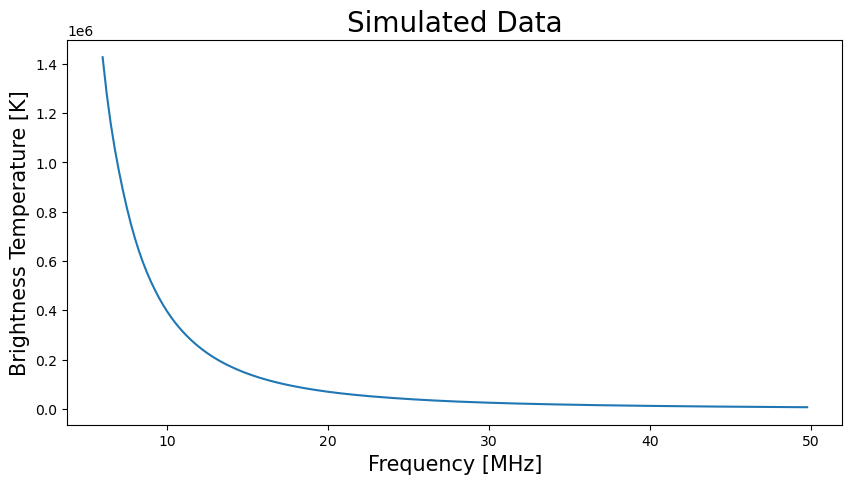

In [ ]:
# Simulation Data
plt.figure(figsize=(10, 5))
plt.plot(frequencies, simulation_test_beam[0])
plt.title("Simulated Data",fontsize=20)
plt.ylabel("Brightness Temperature [K]",fontsize=15)
plt.xlabel("Frequency [MHz]",fontsize=15)

# plt.savefig(save_path+"Simulated_Signal")


In [35]:



## Creates a foreground for the simulation:
dt = 10000*3600
# custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
# parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
parameter_variation = [0,0,0]

signal_model = fiducial_signal

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam = py21cmsig.simulation_run(foreground_for_sim,signal_model,N_antenna,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")

## Creates a training set with varied foreground and beams:

custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])
parameter_variation = [0.05,0.025,0.05]  
# custom_parameter_range = np.array([[0.999975,1.000025],[3.39999,3.40001],[4.59999,4.60001]])  # For making a random foreground
# parameter_variation = [0.0000005,0.00000025,0.0000005]                           # For making a random foreground

rms_mean = 0.05
rms_std = 0.009
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 1000 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1000
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam[0],rms_mean,rms_std,foreground_run[3],foreground_run[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)
for r in range(n_regions):
    new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
    # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
    fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
    fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


print(fg_range_array)


print(fg_range_array)

#### Pylinex Fit #####
fg_training_set = foreground_run_set[3]
sig_training_set = lambdaCDM_training_set
IC = "DIC"
sim_data = simulation_test_beam[0]
noise_level = sigT(sim_data,N_antenna,dnu,dt)
foreground_training_set_array = copy.deepcopy(fg_training_set)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=50,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
signal_basis.generate_gaussian_prior()
foreground_basis.generate_gaussian_prior()
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,50)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension,)
fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter2.sizes['Foreground']
num_signal_terms = fitter2.sizes['Signal']
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter2.subbasis_channel_mean("Signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter2.subbasis_channel_error("Signal")[np.where(fitter2.subbasis_channel_mean("Signal")==fitter2.subbasis_channel_mean("Signal").min())][0]} Channel error at lowest point of the trough ")
# print(f"{fitter2.log_evidence} log evidence")
print(f"{fitter2.chi_squared} Chi Squared")
print(f"{fitter2.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter2.subbasis_channel_mean("Signal")/simulation_test_beam[2],(fitter2.subbasis_channel_mean("Foreground")-simulation_test_beam[2])/simulation_test_beam[2])
print(f"True {pearsonr}")




100%|██████████| 2/2 [00:00<00:00, 17296.10it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.59202418e+01 -2.65279830e+00 -1.37293590e-02  1.66130589e+01
 -2.69062579e+00 -1.47582387e-02  1.89769800e+01 -2.68235795e+00
 -1.34495335e-02  2.42115565e+01 -2.66682587e+00 -1.20169084e-02
  5.22431891e+01 -2.65055339e+00 -2.42275191e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]


100%|██████████| 176/176 [00:02<00:00, 82.61it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 1000/1000 [00:07<00:00, 126.12it/s]


[0.05, 0.025, 0.05]


100%|██████████| 2/2 [00:00<00:00, 12427.57it/s]


[[ 1.51242297e+01  1.67162539e+01 -2.58647835e+00 -2.71911826e+00
  -1.30428910e-02 -1.44158269e-02]
 [ 1.57824060e+01  1.74437118e+01 -2.62336014e+00 -2.75789143e+00
  -1.40203268e-02 -1.54961507e-02]
 [ 1.80281310e+01  1.99258289e+01 -2.61529900e+00 -2.74941689e+00
  -1.27770568e-02 -1.41220102e-02]
 [ 2.30009787e+01  2.54221344e+01 -2.60015522e+00 -2.73349652e+00
  -1.14160630e-02 -1.26177538e-02]
 [ 4.96310296e+01  5.48553485e+01 -2.58428955e+00 -2.71681722e+00
  -2.30161431e-02 -2.54388950e-02]]
[[ 1.51242297e+01  1.67162539e+01 -2.58647835e+00 -2.71911826e+00
  -1.30428910e-02 -1.44158269e-02]
 [ 1.57824060e+01  1.74437118e+01 -2.62336014e+00 -2.75789143e+00
  -1.40203268e-02 -1.54961507e-02]
 [ 1.80281310e+01  1.99258289e+01 -2.61529900e+00 -2.74941689e+00
  -1.27770568e-02 -1.41220102e-02]
 [ 2.30009787e+01  2.54221344e+01 -2.60015522e+00 -2.73349652e+00
  -1.14160630e-02 -1.26177538e-02]
 [ 4.96310296e+01  5.48553485e+01 -2.58428955e+00 -2.71681722e+00
  -2.30161431e-02 -2.543

In [ ]:
#### Pylinex Fit #####
fg_training_set = foreground_run_set[3]
sig_training_set = lambdaCDM_training_set
IC = "DIC"
sim_data = simulation_test_beam[0]
noise_level = sigT(sim_data,N_antenna,dnu,dt)
foreground_training_set_array = copy.deepcopy(fg_training_set)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=100,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
signal_basis.generate_gaussian_prior()
foreground_basis.generate_gaussian_prior()
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,100)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension,)
fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter2.sizes['Foreground']
num_signal_terms = fitter2.sizes['Signal']
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter2.subbasis_channel_mean("Signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter2.subbasis_channel_error("Signal")[np.where(fitter2.subbasis_channel_mean("Signal")==fitter2.subbasis_channel_mean("Signal").min())][0]} Channel error at lowest point of the trough ")
# print(f"{fitter2.log_evidence} log evidence")
print(f"{fitter2.reduced_chi_squared} Chi Squared")
print(f"{fitter2.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter2.subbasis_channel_mean("Signal")/simulation_test_beam[2],(fitter2.subbasis_channel_mean("Foreground")-simulation_test_beam[2])/simulation_test_beam[2])
print(f"True {pearsonr}")

Minimizing DIC over grid.
The MetaFitter chose 49 foreground terms based on DIC minimization.
The MetaFitter chose 3 signal terms based on DIC minimization.
5.400547011674798e-13 Temperature of lowest point of the trough 
1.1242616600226865e-13 Channel error at lowest point of the trough 
7.8335448641754155 Chi Squared
935.2914817878235 Psi Squared
True PearsonRResult(statistic=-0.9999999957658583, pvalue=0.0)


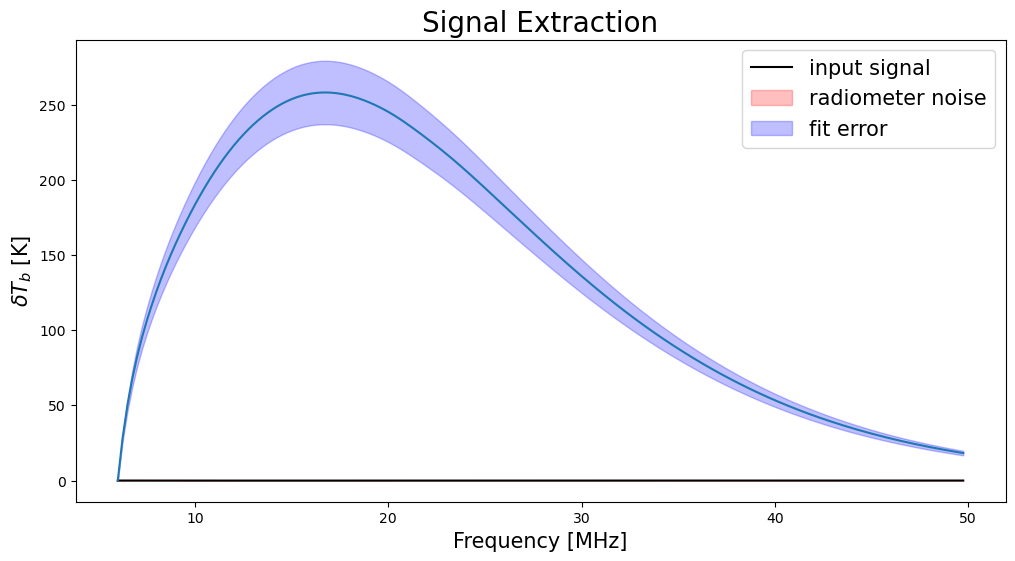

In [37]:
fig, ax = plt.subplots(figsize=(12, 6))

radiometer_error = sigT(simulation_test_beam[0],2,dt,dnu)
pylinex_error = fitter2.subbasis_channel_error("Signal")
plt.plot(frequencies,fiducial_signal,c="black",label="input signal")
plt.plot(frequencies,fitter2.subbasis_channel_mean("Signal"))

plt.fill_between(frequencies,fiducial_signal+radiometer_error,fiducial_signal-radiometer_error,alpha=0.25,label="radiometer noise",color="red")
plt.fill_between(frequencies,fitter2.subbasis_channel_mean("Signal")+pylinex_error,fitter2.subbasis_channel_mean("Signal")-pylinex_error,alpha=0.25,label="fit error",color="blue")
# plt.fill_between(frequencies,fiducial_signal+pylinex_error,fiducial_signal-pylinex_error,alpha=0.25,label="radiometer noise")

plt.title("Signal Extraction",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel(r"$\delta T_b$ [K]",fontsize="15")
# plt.ylim(-0.06,0.01)
# plt.text(27.3, 0, f'radiometer error @ 17 MHz = {radiometer_error[43]:.4f} K', ha='center', va='bottom', fontsize=15)
plt.legend(fontsize=15)

# plt.subplot(1,3,2)
# radiometer_error = sigT(simulation_test_beam[0],dnu,350000*3600)
# pylinex_error = fitter2.subbasis_channel_error("Signal")
# added_error = np.sqrt(pylinex_error**2+radiometer_error**2)
# plt.plot(frequencies,fiducial_signal,c="black",label="fiducial signal")
# # plt.fill_between(frequencies,fiducial_signal+(added_error-radiometer_error),fiducial_signal-(added_error-radiometer_error),alpha=1,label="radiometer noise")
# plt.fill_between(frequencies,fiducial_signal+pylinex_error,fiducial_signal-pylinex_error,alpha=0.25,label="pylinex noise")
# plt.title("PYLINEX Noise",fontsize=20)
# plt.xlabel("Frequency [MHz]",fontsize="15")
# plt.ylabel("Temperature [K]",fontsize="15")
# plt.text(22.3, -0.01, f'pylinex error @ 17 MHz = {fitter2.subbasis_channel_error("Signal")[43]:.4f} K', ha='center', va='bottom', fontsize=15)
# plt.legend()

# plt.subplot(1,3,3)
# radiometer_error = sigT(simulation_test_beam[0],dnu,350000*3600)
# pylinex_error = fitter2.subbasis_channel_error("Signal")
# added_error = np.sqrt(pylinex_error**2+radiometer_error**2)
# # plt.plot(frequencies,fiducial_signal,c="black",label="fiducial signal")
# plt.fill_between(frequencies,fiducial_signal+(added_error-radiometer_error),fiducial_signal-(added_error-radiometer_error),alpha=1,label="noise difference")
# # plt.fill_between(frequencies,fiducial_signal+pylinex_error,fiducial_signal-pylinex_error,alpha=0.25,label="radiometer noise")
# plt.title("Added Noise Minus Radiometer Noise",fontsize=20)
# plt.xlabel("Frequency [MHz]",fontsize="15")
# plt.ylabel("Temperature [K]",fontsize="15")
# plt.legend()
# plt.savefig(save_path+"350hrs_10antennas")

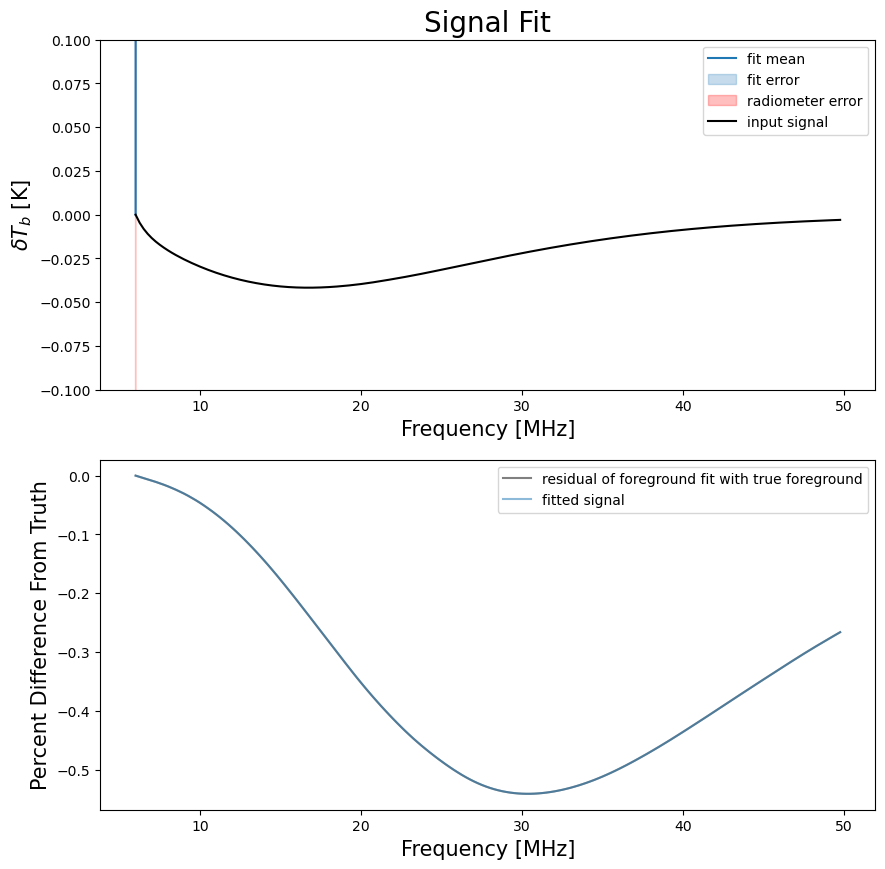

In [36]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 10))
noise = sigT(simulation_test_beam[0],1,dt,dnu)
plt.subplot(2,1,1)
plt.plot(frequencies, fitter2.subbasis_channel_mean("Signal"),label = "fit mean", c="tab:blue")
plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Signal")+fitter2.subbasis_channel_error("Signal"),fitter2.subbasis_channel_mean("Signal")-fitter2.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="tab:blue")
plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Signal")+noise,fitter2.subbasis_channel_mean("Signal")-noise,label="radiometer error",alpha=0.25,color="red")
plt.title("Signal Fit",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel(r"$\delta T_b$ [K]",fontsize="15")
#plt.text(22, -0.01, f'fit mean = {fitter_10000.subbasis_channel_mean("Signal")[43]:.3f} K', ha='center', va='bottom', fontsize=15)
#plt.text(22, -0.015, f'radiometer error = {noise[43]:.4f} K', ha='center', va='bottom', fontsize=15)
plt.plot(frequencies,simulation_test_beam[1],label="input signal",c="black")
plt.ylim(-0.1,0.1)
plt.legend()


plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter2.subbasis_channel_mean("Foreground")[0:len(frequencies)]-simulation_test_beam[2]))/simulation_test_beam[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,-fitter2.subbasis_channel_mean("Signal")/simulation_test_beam[2]*100,c="tab:blue",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Percent Difference From Truth",fontsize="15")

plt.legend()


In [13]:



## Creates a foreground for the simulation:
dt = 10000*3600
# custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
# parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
parameter_variation = [0,0,0]

signal_model = fiducial_signal

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam = py21cmsig.simulation_run(foreground_for_sim,signal_model,N_antenna,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")

## Creates a training set with varied foreground and beams:

custom_parameter_range = np.array([[0.975,1.025],[3.39,3.41],[4.59,4.69]])  # For making a random foreground
parameter_variation = [0.0005,0.00025,0.0005]  
# custom_parameter_range = np.array([[0.999975,1.000025],[3.39999,3.40001],[4.59999,4.60001]])  # For making a random foreground
# parameter_variation = [0.0000005,0.00000025,0.0000005]                           # For making a random foreground

rms_mean = 0.05
rms_std = 0.009
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 1000 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1000
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam[0],rms_mean,rms_std,foreground_run[3],foreground_run[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)
for r in range(n_regions):
    new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
    # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
    fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
    fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


print(fg_range_array)


print(fg_range_array)

#### Pylinex Fit #####
fg_training_set = foreground_run_set[3]
sig_training_set = lambdaCDM_training_set
IC = "DIC"
sim_data = simulation_test_beam[0]
noise_level = sigT(sim_data,N_antenna,dnu,dt)
foreground_training_set_array = copy.deepcopy(fg_training_set)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=50,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
signal_basis.generate_gaussian_prior()
foreground_basis.generate_gaussian_prior()
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,50)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension,)
fitter_10000 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_10000.sizes['Foreground']
num_signal_terms = fitter_10000.sizes['Signal']
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_10000.subbasis_channel_mean("Signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_10000.subbasis_channel_error("Signal")[np.where(fitter_10000.subbasis_channel_mean("Signal")==fitter_10000.subbasis_channel_mean("Signal").min())][0]} Channel error at lowest point of the trough ")
# print(f"{fitter2.log_evidence} log evidence")
print(f"{fitter_10000.reduced_chi_squared} Chi Squared")
print(f"{fitter_10000.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_10000.subbasis_channel_mean("Signal")/simulation_test_beam[2],(fitter_10000.subbasis_channel_mean("Foreground")-simulation_test_beam[2])/simulation_test_beam[2])
print(f"True {pearsonr}")

100%|██████████| 2/2 [00:00<00:00, 4056.39it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.59202418e+01 -2.65279830e+00 -1.37293590e-02  1.66130589e+01
 -2.69062579e+00 -1.47582387e-02  1.89769800e+01 -2.68235795e+00
 -1.34495335e-02  2.42115565e+01 -2.66682587e+00 -1.20169084e-02
  5.22431891e+01 -2.65055339e+00 -2.42275191e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]


100%|██████████| 176/176 [00:01<00:00, 161.04it/s]


[[0.975 1.025]
 [3.39  3.41 ]
 [4.59  4.69 ]]


100%|██████████| 1000/1000 [00:07<00:00, 126.99it/s]


[0.0005, 0.00025, 0.0005]


100%|██████████| 2/2 [00:00<00:00, 10852.02it/s]


[[ 1.59122817e+01  1.59282019e+01 -2.65213511e+00 -2.65346150e+00
  -1.37224943e-02 -1.37362237e-02]
 [ 1.66047524e+01  1.66213654e+01 -2.68995313e+00 -2.69129844e+00
  -1.47508596e-02 -1.47656178e-02]
 [ 1.89674915e+01  1.89864684e+01 -2.68168736e+00 -2.68302853e+00
  -1.34428087e-02 -1.34562583e-02]
 [ 2.41994508e+01  2.42236623e+01 -2.66615916e+00 -2.66749258e+00
  -1.20108999e-02 -1.20229168e-02]
 [ 5.22170675e+01  5.22693107e+01 -2.64989075e+00 -2.65121603e+00
  -2.42154053e-02 -2.42396328e-02]]
[[ 1.59122817e+01  1.59282019e+01 -2.65213511e+00 -2.65346150e+00
  -1.37224943e-02 -1.37362237e-02]
 [ 1.66047524e+01  1.66213654e+01 -2.68995313e+00 -2.69129844e+00
  -1.47508596e-02 -1.47656178e-02]
 [ 1.89674915e+01  1.89864684e+01 -2.68168736e+00 -2.68302853e+00
  -1.34428087e-02 -1.34562583e-02]
 [ 2.41994508e+01  2.42236623e+01 -2.66615916e+00 -2.66749258e+00
  -1.20108999e-02 -1.20229168e-02]
 [ 5.22170675e+01  5.22693107e+01 -2.64989075e+00 -2.65121603e+00
  -2.42154053e-02 -2.423

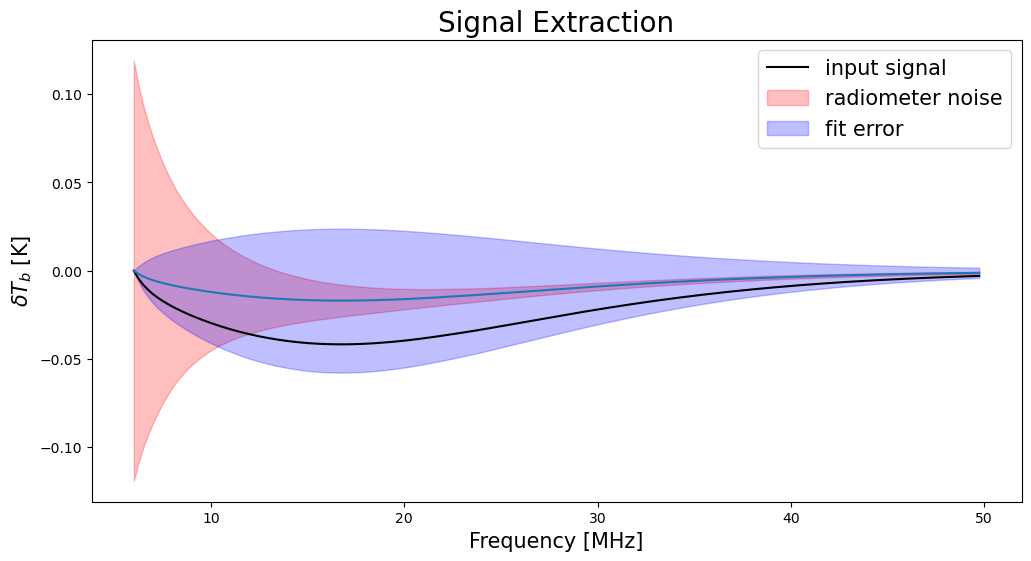

In [14]:
fig, ax = plt.subplots(figsize=(12, 6))

radiometer_error = sigT(simulation_test_beam[0],2,dt,dnu)
pylinex_error = fitter_10000.subbasis_channel_error("Signal")
plt.plot(frequencies,fiducial_signal,c="black",label="input signal")
plt.plot(frequencies,fitter_10000.subbasis_channel_mean("Signal"))

plt.fill_between(frequencies,fitter_10000.subbasis_channel_mean("Signal")+radiometer_error,fitter_10000.subbasis_channel_mean("Signal")-radiometer_error,alpha=0.25,label="radiometer noise",color="red")
plt.fill_between(frequencies,fitter_10000.subbasis_channel_mean("Signal")+pylinex_error,fitter_10000.subbasis_channel_mean("Signal")-pylinex_error,alpha=0.25,label="fit error",color="blue")
# plt.fill_between(frequencies,fiducial_signal+pylinex_error,fiducial_signal-pylinex_error,alpha=0.25,label="radiometer noise")

plt.title("Signal Extraction",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel(r"$\delta T_b$ [K]",fontsize="15")
# plt.ylim(-0.06,0.01)
# plt.text(27.3, 0, f'radiometer error @ 17 MHz = {radiometer_error[43]:.4f} K', ha='center', va='bottom', fontsize=15)
plt.legend(fontsize=15)

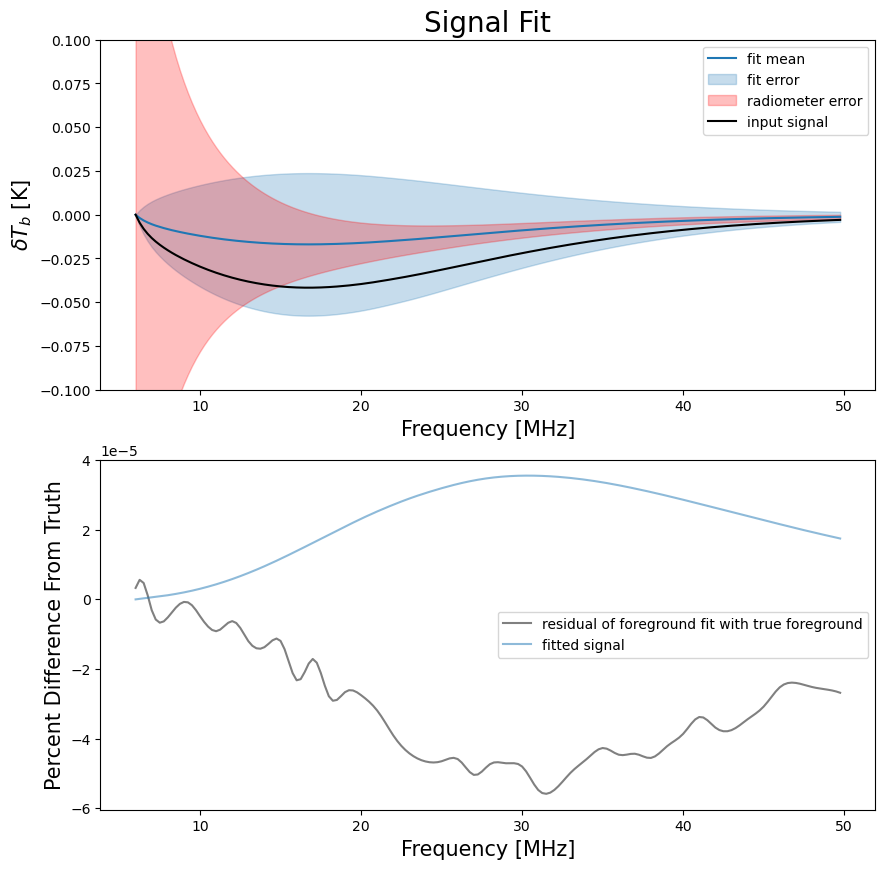

In [20]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 10))
noise = sigT(simulation_test_beam[0],1,dt,dnu)
plt.subplot(2,1,1)
plt.plot(frequencies, fitter_10000.subbasis_channel_mean("Signal"),label = "fit mean", c="tab:blue")
plt.fill_between(frequencies, fitter_10000.subbasis_channel_mean("Signal")+fitter_10000.subbasis_channel_error("Signal"),fitter_10000.subbasis_channel_mean("Signal")-fitter_10000.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="tab:blue")
plt.fill_between(frequencies, fitter_10000.subbasis_channel_mean("Signal")+noise,fitter_10000.subbasis_channel_mean("Signal")-noise,label="radiometer error",alpha=0.25,color="red")
plt.title("Signal Fit",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel(r"$\delta T_b$ [K]",fontsize="15")
#plt.text(22, -0.01, f'fit mean = {fitter_10000.subbasis_channel_mean("Signal")[43]:.3f} K', ha='center', va='bottom', fontsize=15)
#plt.text(22, -0.015, f'radiometer error = {noise[43]:.4f} K', ha='center', va='bottom', fontsize=15)
plt.plot(frequencies,simulation_test_beam[1],label="input signal",c="black")
plt.ylim(-0.1,0.1)
plt.legend()


plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_10000.subbasis_channel_mean("Foreground")[0:len(frequencies)]-simulation_test_beam[2]))/simulation_test_beam[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,-fitter_10000.subbasis_channel_mean("Signal")/simulation_test_beam[2]*100,c="tab:blue",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Percent Difference From Truth",fontsize="15")

plt.legend()

# plt.savefig(save_path+"Example_extraction_with_degen")

In [48]:



## Creates a foreground for the simulation:
dt = 10000*3600
# custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
# parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
parameter_variation = [0,0,0]

signal_model = fiducial_signal

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam = py21cmsig.simulation_run(foreground_for_sim,signal_model,N_antenna,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")

## Creates a training set with varied foreground and beams:

custom_parameter_range = np.array([[0.99975,1.00025],[3.3999,3.4001],[4.5999,4.6001]])  # For making a random foreground
parameter_variation = [0.000005,0.0000025,0.000005]  
# custom_parameter_range = np.array([[0.999975,1.000025],[3.39999,3.40001],[4.59999,4.60001]])  # For making a random foreground
# parameter_variation = [0.0000005,0.00000025,0.0000005]                           # For making a random foreground

rms_mean = 0.05
rms_std = 0.009
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 1500 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1500
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam[0],rms_mean,rms_std,foreground_run[3],foreground_run[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)
for r in range(n_regions):
    new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
    # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
    fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
    fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


print(fg_range_array)


print(fg_range_array)

#### Pylinex Fit #####
fg_training_set = foreground_run_set[3]
sig_training_set = lambdaCDM_training_set
IC = "DIC"
sim_data = simulation_test_beam[0]
noise_level = sigT(sim_data,N_antenna,dnu,dt)
foreground_training_set_array = copy.deepcopy(fg_training_set)
foreground_basis_2 = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=50,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
signal_basis.generate_gaussian_prior()
foreground_basis.generate_gaussian_prior()
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,50)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension,)
fitter_100 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_100.sizes['Foreground']
num_signal_terms = fitter_100.sizes['Signal']
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_100.subbasis_channel_mean("Signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_100.subbasis_channel_error("Signal")[np.where(fitter_100.subbasis_channel_mean("Signal")==fitter_100.subbasis_channel_mean("Signal").min())][0]} Channel error at lowest point of the trough ")
# print(f"{fitter2.log_evidence} log evidence")
print(f"{fitter_100.reduced_chi_squared} Chi Squared")
print(f"{fitter_100.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_100.subbasis_channel_mean("Signal")/simulation_test_beam[2],(fitter_100.subbasis_channel_mean("Foreground")-simulation_test_beam[2])/simulation_test_beam[2])
print(f"True {pearsonr}")

100%|██████████| 2/2 [00:00<00:00, 10433.59it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.59202418e+01 -2.65279830e+00 -1.37293590e-02  1.66130589e+01
 -2.69062579e+00 -1.47582387e-02  1.89769800e+01 -2.68235795e+00
 -1.34495335e-02  2.42115565e+01 -2.66682587e+00 -1.20169084e-02
  5.22431891e+01 -2.65055339e+00 -2.42275191e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]


100%|██████████| 176/176 [00:01<00:00, 109.29it/s]


[[0.99975 1.00025]
 [3.3999  3.4001 ]
 [4.5999  4.6001 ]]


100%|██████████| 1500/1500 [00:18<00:00, 80.27it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 2/2 [00:00<00:00, 12576.62it/s]


[[ 1.59201622e+01  1.59203214e+01 -2.65279167e+00 -2.65280494e+00
  -1.37292903e-02 -1.37294276e-02]
 [ 1.66129758e+01  1.66131420e+01 -2.69061906e+00 -2.69063252e+00
  -1.47581649e-02 -1.47583125e-02]
 [ 1.89768851e+01  1.89770748e+01 -2.68235124e+00 -2.68236465e+00
  -1.34494663e-02 -1.34496007e-02]
 [ 2.42114355e+01  2.42116776e+01 -2.66681920e+00 -2.66683254e+00
  -1.20168483e-02 -1.20169685e-02]
 [ 5.22429279e+01  5.22434503e+01 -2.65054676e+00 -2.65056001e+00
  -2.42273979e-02 -2.42276402e-02]]
[[ 1.59201622e+01  1.59203214e+01 -2.65279167e+00 -2.65280494e+00
  -1.37292903e-02 -1.37294276e-02]
 [ 1.66129758e+01  1.66131420e+01 -2.69061906e+00 -2.69063252e+00
  -1.47581649e-02 -1.47583125e-02]
 [ 1.89768851e+01  1.89770748e+01 -2.68235124e+00 -2.68236465e+00
  -1.34494663e-02 -1.34496007e-02]
 [ 2.42114355e+01  2.42116776e+01 -2.66681920e+00 -2.66683254e+00
  -1.20168483e-02 -1.20169685e-02]
 [ 5.22429279e+01  5.22434503e+01 -2.65054676e+00 -2.65056001e+00
  -2.42273979e-02 -2.422

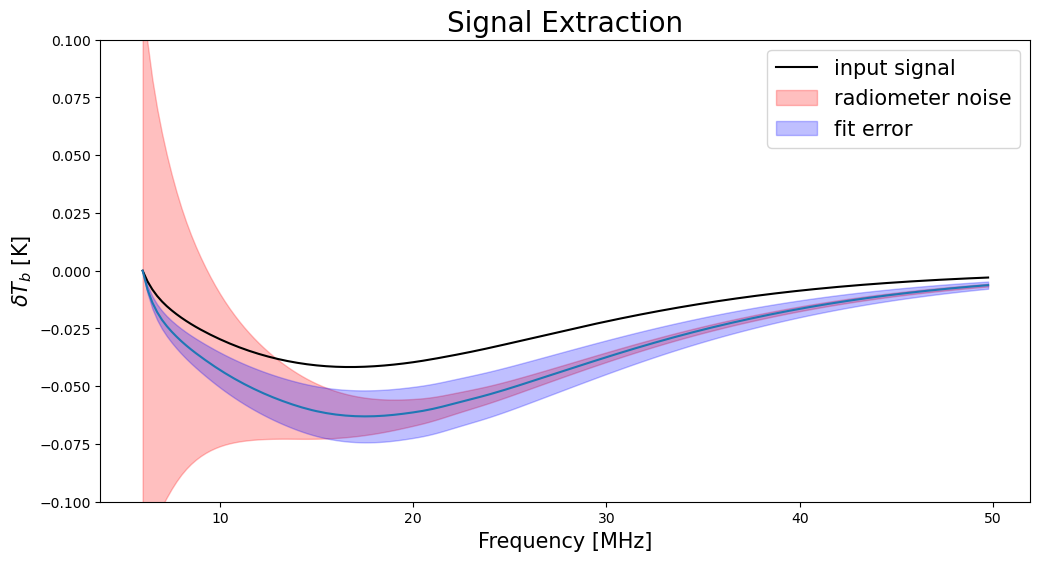

In [24]:
fig, ax = plt.subplots(figsize=(12, 6))

radiometer_error = sigT(simulation_test_beam[0],2,dt,dnu)
pylinex_error = fitter_100.subbasis_channel_error("Signal")
plt.plot(frequencies,fiducial_signal,c="black",label="input signal")
plt.plot(frequencies,fitter_100.subbasis_channel_mean("Signal"))

plt.fill_between(frequencies,fitter_100.subbasis_channel_mean("Signal")+radiometer_error,fitter_100.subbasis_channel_mean("Signal")-radiometer_error,alpha=0.25,label="radiometer noise",color="red")
plt.fill_between(frequencies,fitter_100.subbasis_channel_mean("Signal")+pylinex_error,fitter_100.subbasis_channel_mean("Signal")-pylinex_error,alpha=0.25,label="fit error",color="blue")
# plt.fill_between(frequencies,fiducial_signal+pylinex_error,fiducial_signal-pylinex_error,alpha=0.25,label="radiometer noise")

plt.title("Signal Extraction",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel(r"$\delta T_b$ [K]",fontsize="15")
plt.ylim(-0.1,0.1)
# plt.text(27.3, 0, f'radiometer error @ 17 MHz = {radiometer_error[43]:.4f} K', ha='center', va='bottom', fontsize=15)
plt.legend(fontsize=15)

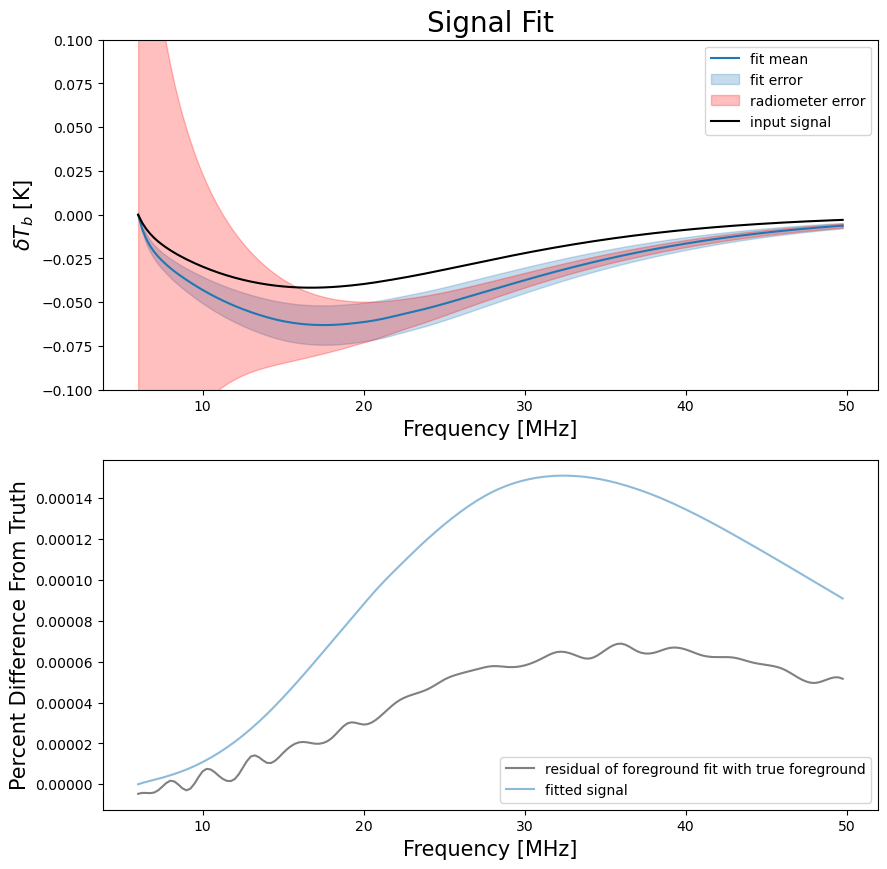

In [25]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 10))
noise = sigT(simulation_test_beam[0],1,dt,dnu)
plt.subplot(2,1,1)
plt.plot(frequencies, fitter_100.subbasis_channel_mean("Signal"),label = "fit mean", c="tab:blue")
plt.fill_between(frequencies, fitter_100.subbasis_channel_mean("Signal")+fitter_100.subbasis_channel_error("Signal"),fitter_100.subbasis_channel_mean("Signal")-fitter_100.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="tab:blue")
plt.fill_between(frequencies, fitter_100.subbasis_channel_mean("Signal")+noise,fitter_100.subbasis_channel_mean("Signal")-noise,label="radiometer error",alpha=0.25,color="red")
plt.title("Signal Fit",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel(r"$\delta T_b$ [K]",fontsize="15")
#plt.text(22, -0.01, f'fit mean = {fitter_10000.subbasis_channel_mean("Signal")[43]:.3f} K', ha='center', va='bottom', fontsize=15)
#plt.text(22, -0.015, f'radiometer error = {noise[43]:.4f} K', ha='center', va='bottom', fontsize=15)
plt.plot(frequencies,simulation_test_beam[1],label="input signal",c="black")
plt.ylim(-0.1,0.1)
plt.legend()


plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_100.subbasis_channel_mean("Foreground")[0:len(frequencies)]-simulation_test_beam[2]))/simulation_test_beam[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,-fitter_100.subbasis_channel_mean("Signal")/simulation_test_beam[2]*100,c="tab:blue",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Percent Difference From Truth",fontsize="15")

plt.legend()

# plt.savefig(save_path+"Example_extraction_with_degen")

In [40]:
fitter2.basis_sum.basis

array([[-9.04915887e-03, -8.11757436e-03, -7.34833526e-03, ...,
        -4.42710949e-05, -4.36497639e-05, -4.30427832e-05],
       [-1.92353404e-02, -1.71882568e-02, -1.52594642e-02, ...,
         5.75176388e-05,  5.59035016e-05,  5.42314186e-05],
       [-2.09479384e-02, -1.80825532e-02, -1.56021006e-02, ...,
        -3.80558239e-05, -3.33674039e-05, -2.84225140e-05],
       ...,
       [-1.74914712e-02,  3.07777164e-02,  6.62017868e-03, ...,
         2.32335528e-06,  1.39262698e-06, -2.00536742e-06],
       [-8.90369639e-03,  1.71275707e-02,  5.03962718e-04, ...,
         3.32650313e-06,  1.86265823e-06, -3.64968809e-06],
       [-6.60174599e-17,  4.63825870e-05,  8.19552590e-05, ...,
         3.16777910e-05,  3.07837889e-05,  2.99139772e-05]])

Text(0.5, 0, 'Frequency [MHz]')

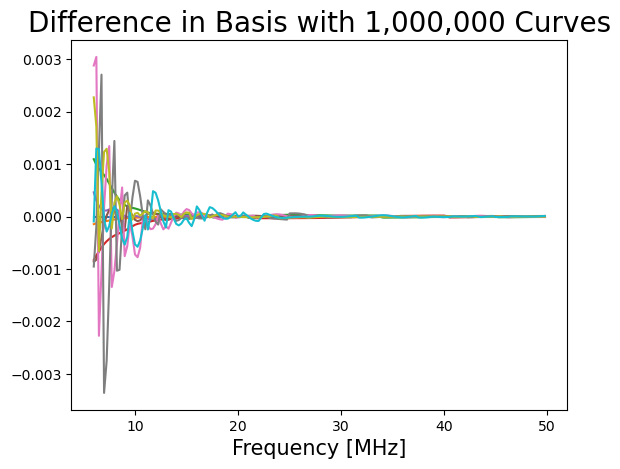

In [46]:
for n in range(10):
    plt.plot(frequencies, np.abs(foreground_basis.basis[n])-np.abs(foreground_basis_2.basis[n]),label=f"mode {n+1}",alpha = 1)
plt.title("Difference in Basis with 1,000,000 Curves",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")

Text(0.5, 0, 'Frequency [MHz]')

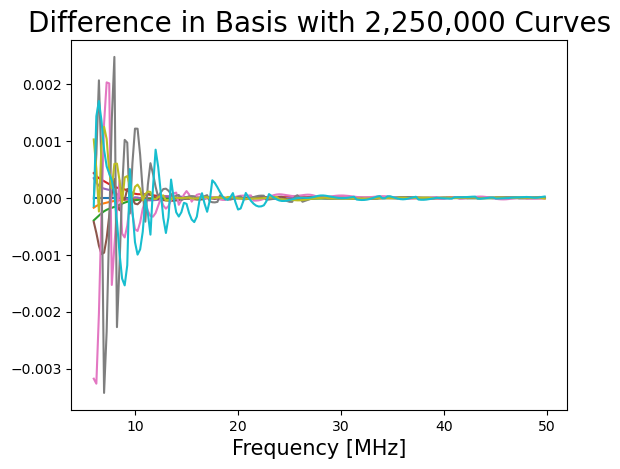

In [49]:
for n in range(10):
    plt.plot(frequencies, np.abs(foreground_basis.basis[n])-np.abs(foreground_basis_2.basis[n]),label=f"mode {n+1}",alpha = 1)
plt.title("Difference in Basis with 2,250,000 Curves",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")

In [ ]:
for n in range(10):
    plt.plot(frequencies, np.abs(foreground_basis.basis[n])-np.abs(foreground_basis_2.basis[n]),label=f"mode {n+1}",alpha = 1)
plt.title("Beam-Weighted Foreground Basis",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")

In [33]:



## Creates a foreground for the simulation:
dt = 10000*3600
# custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
# parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
parameter_variation = [0,0,0]

signal_model = fiducial_signal

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam = py21cmsig.simulation_run(foreground_for_sim,signal_model,N_antenna,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")

## Creates a training set with varied foreground and beams:

custom_parameter_range = np.array([[0.999975,1.000025],[3.39999,3.40001],[4.59999,4.60001]])  # For making a random foreground
parameter_variation = [0.000005,0.0000025,0.000005]  
# custom_parameter_range = np.array([[0.999975,1.000025],[3.39999,3.40001],[4.59999,4.60001]])  # For making a random foreground
# parameter_variation = [0.0000005,0.00000025,0.0000005]                           # For making a random foreground

rms_mean = 0.05
rms_std = 0.009
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 1000 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1000
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam[0],rms_mean,rms_std,foreground_run[3],foreground_run[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)
for r in range(n_regions):
    new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
    # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
    fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
    fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


print(fg_range_array)


print(fg_range_array)

#### Pylinex Fit #####
fg_training_set = foreground_run_set[3]
sig_training_set = lambdaCDM_training_set
IC = "DIC"
sim_data = simulation_test_beam[0]
noise_level = sigT(sim_data,N_antenna,dnu,dt)
foreground_training_set_array = copy.deepcopy(fg_training_set)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=50,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
signal_basis.generate_gaussian_prior()
foreground_basis.generate_gaussian_prior()
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,50)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension,)
fitter_10 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter_10.sizes['Foreground']
num_signal_terms = fitter_10.sizes['Signal']
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter_10.subbasis_channel_mean("Signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter_10.subbasis_channel_error("Signal")[np.where(fitter_10.subbasis_channel_mean("Signal")==fitter_10.subbasis_channel_mean("Signal").min())][0]} Channel error at lowest point of the trough ")
# print(f"{fitter2.log_evidence} log evidence")
print(f"{fitter_10.reduced_chi_squared} Chi Squared")
print(f"{fitter_10.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter_10.subbasis_channel_mean("Signal")/simulation_test_beam[2],(fitter_10.subbasis_channel_mean("Foreground")-simulation_test_beam[2])/simulation_test_beam[2])
print(f"True {pearsonr}")

100%|██████████| 2/2 [00:00<00:00, 5108.77it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.59202418e+01 -2.65279830e+00 -1.37293590e-02  1.66130589e+01
 -2.69062579e+00 -1.47582387e-02  1.89769800e+01 -2.68235795e+00
 -1.34495335e-02  2.42115565e+01 -2.66682587e+00 -1.20169084e-02
  5.22431891e+01 -2.65055339e+00 -2.42275191e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]


100%|██████████| 176/176 [00:01<00:00, 149.41it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60001 ]]


100%|██████████| 1000/1000 [00:07<00:00, 127.63it/s]


[5e-06, 2.5e-06, 5e-06]


100%|██████████| 2/2 [00:00<00:00, 15307.68it/s]


[[ 1.59201622e+01  1.59203214e+01 -2.65279167e+00 -2.65280494e+00
  -1.37292903e-02 -1.37294276e-02]
 [ 1.66129758e+01  1.66131420e+01 -2.69061906e+00 -2.69063252e+00
  -1.47581649e-02 -1.47583125e-02]
 [ 1.89768851e+01  1.89770748e+01 -2.68235124e+00 -2.68236465e+00
  -1.34494663e-02 -1.34496007e-02]
 [ 2.42114355e+01  2.42116776e+01 -2.66681920e+00 -2.66683254e+00
  -1.20168483e-02 -1.20169685e-02]
 [ 5.22429279e+01  5.22434503e+01 -2.65054676e+00 -2.65056001e+00
  -2.42273979e-02 -2.42276402e-02]]
[[ 1.59201622e+01  1.59203214e+01 -2.65279167e+00 -2.65280494e+00
  -1.37292903e-02 -1.37294276e-02]
 [ 1.66129758e+01  1.66131420e+01 -2.69061906e+00 -2.69063252e+00
  -1.47581649e-02 -1.47583125e-02]
 [ 1.89768851e+01  1.89770748e+01 -2.68235124e+00 -2.68236465e+00
  -1.34494663e-02 -1.34496007e-02]
 [ 2.42114355e+01  2.42116776e+01 -2.66681920e+00 -2.66683254e+00
  -1.20168483e-02 -1.20169685e-02]
 [ 5.22429279e+01  5.22434503e+01 -2.65054676e+00 -2.65056001e+00
  -2.42273979e-02 -2.422

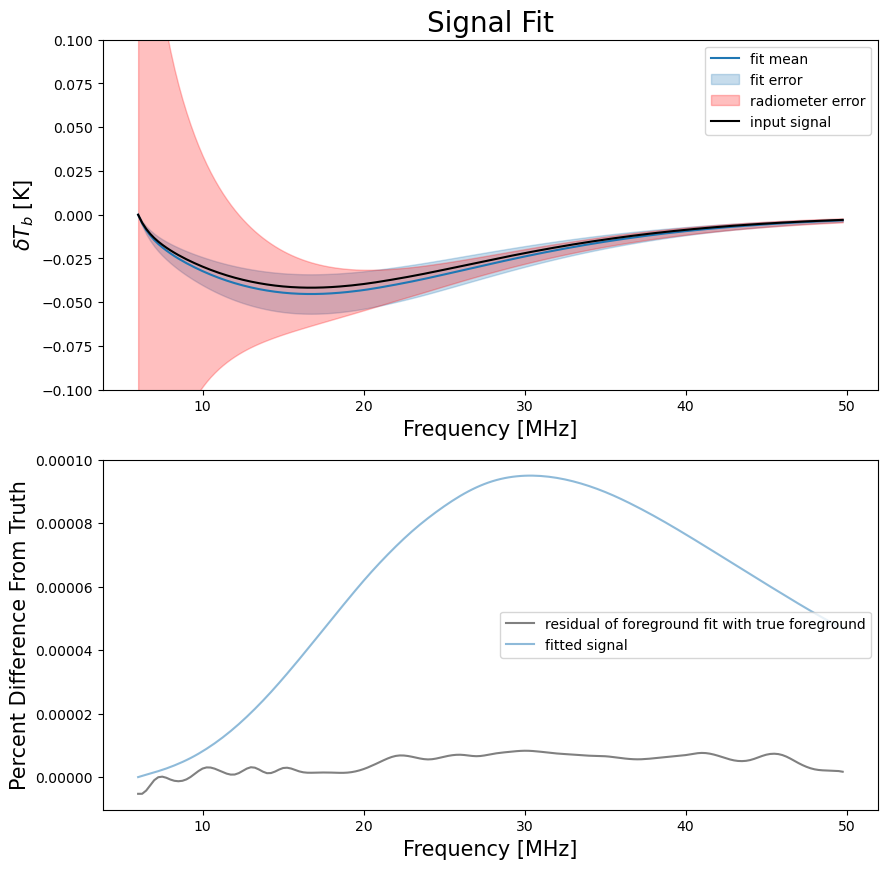

In [34]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 10))
noise = sigT(simulation_test_beam[0],1,dt,dnu)
plt.subplot(2,1,1)
plt.plot(frequencies, fitter_10.subbasis_channel_mean("Signal"),label = "fit mean", c="tab:blue")
plt.fill_between(frequencies, fitter_10.subbasis_channel_mean("Signal")+fitter_10.subbasis_channel_error("Signal"),fitter_10.subbasis_channel_mean("Signal")-fitter_10.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="tab:blue")
plt.fill_between(frequencies, fitter_10.subbasis_channel_mean("Signal")+noise,fitter_10.subbasis_channel_mean("Signal")-noise,label="radiometer error",alpha=0.25,color="red")
plt.title("Signal Fit",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel(r"$\delta T_b$ [K]",fontsize="15")
#plt.text(22, -0.01, f'fit mean = {fitter_10000.subbasis_channel_mean("Signal")[43]:.3f} K', ha='center', va='bottom', fontsize=15)
#plt.text(22, -0.015, f'radiometer error = {noise[43]:.4f} K', ha='center', va='bottom', fontsize=15)
plt.plot(frequencies,simulation_test_beam[1],label="input signal",c="black")
plt.ylim(-0.1,0.1)
plt.legend()


plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter_10.subbasis_channel_mean("Foreground")[0:len(frequencies)]-simulation_test_beam[2]))/simulation_test_beam[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,-fitter_10.subbasis_channel_mean("Signal")/simulation_test_beam[2]*100,c="tab:blue",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Percent Difference From Truth",fontsize="15")

plt.legend()

# plt.savefig(save_path+"Example_extraction_with_degen")

ValueError: alpha (-0.10000000000000009) is outside 0-1 range

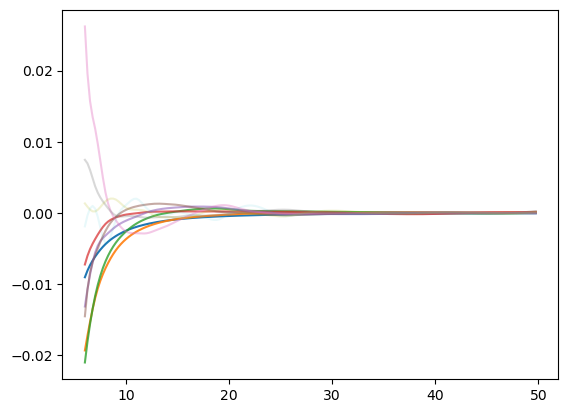

In [ ]:

# Plots the foreground basis
for n in range(5):
    plt.plot(frequencies, foreground_basis.basis[n],label=f"mode {n+1}",alpha = 1-0.1*n)
plt.title("First Five Modes of Systematics Basis",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.legend()
# plt.savefig(save_path+"Foreground_Basis")

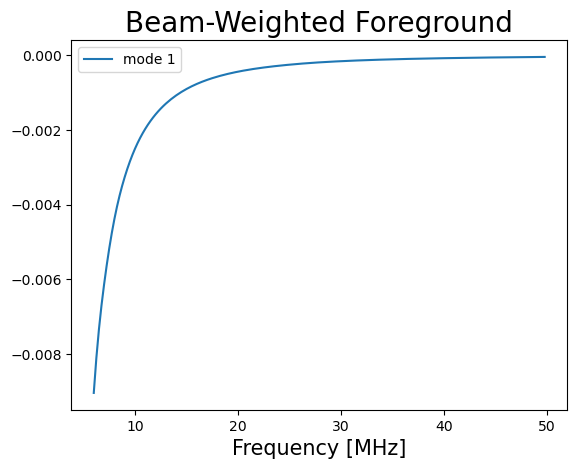

In [75]:

# Plots the foreground basis
for n in range(1):
    plt.plot(frequencies, foreground_basis.basis[n],label=f"mode {n+1}",alpha = 1-0.1*n)
plt.title("Beam-Weighted Foreground",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.legend()
# plt.savefig(save_path+"Foreground_Basis")

Text(0.5, 0, 'Frequency [MHz]')

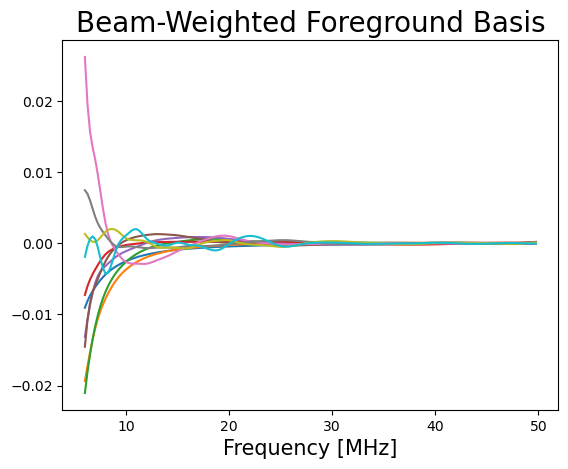

In [97]:

# Plots the foreground basis
for n in range(10):
    plt.plot(frequencies, foreground_basis.basis[n],label=f"mode {n+1}",alpha = 1)
plt.title("Beam-Weighted Foreground Basis",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
# plt.legend()
# plt.savefig(save_path+"Foreground_Basis")

Text(0.5, 0, 'Frequency [MHz]')

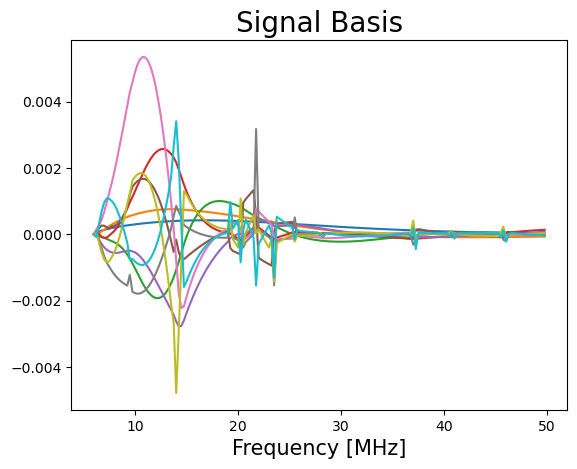

In [106]:
# Plots the foreground basis
for n in range(10):
    plt.plot(frequencies, signal_basis.basis[n],label=f"mode {n+1}",alpha =1)
plt.title("Signal Basis",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
# plt.savefig(save_path+"Signal_Basis")

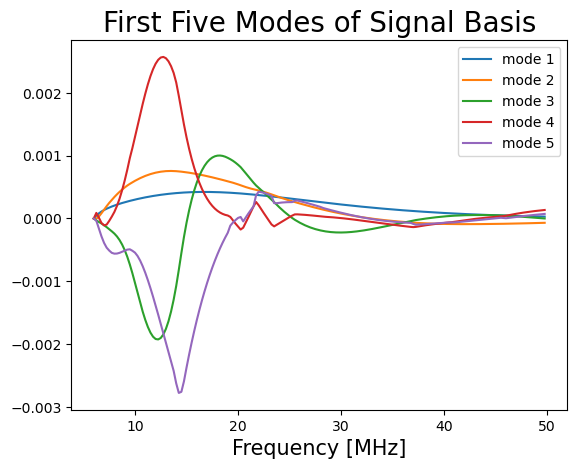

In [101]:
# Plots the foreground basis
for n in range(5):
    plt.plot(frequencies, signal_basis.basis[n],label=f"mode {n+1}")
plt.title("First Five Modes of Signal Basis",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.legend()
# plt.savefig(save_path+"Signal_Basis")

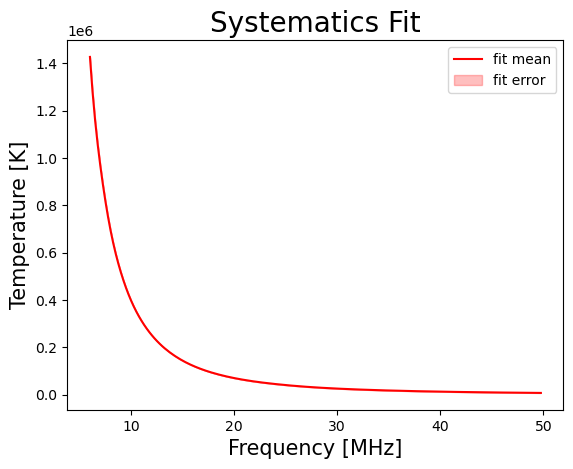

In [23]:
plt.plot(frequencies, fitter2.subbasis_channel_mean("Foreground"),label = "fit mean", c="red")
plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Foreground")+fitter2.subbasis_channel_error("Foreground"),fitter2.subbasis_channel_mean("Foreground")-fitter2.subbasis_channel_error("Foreground"),label="fit error",alpha=0.25,color="red")
plt.title("Systematics Fit",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Temperature [K]",fontsize="15")
plt.legend()
# plt.savefig(save_path+"example_foreground_fit")

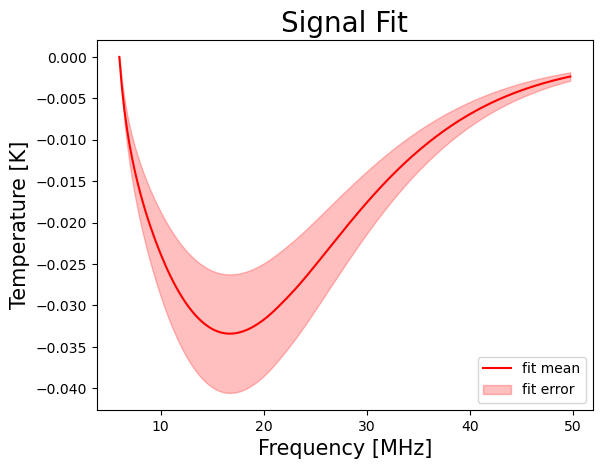

In [24]:
plt.plot(frequencies, fitter2.subbasis_channel_mean("Signal"),label = "fit mean", c="red")
plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Signal")+fitter2.subbasis_channel_error("Signal"),fitter2.subbasis_channel_mean("Signal")-fitter2.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="red")
plt.title("Signal Fit",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Temperature [K]",fontsize="15")
plt.legend()
# plt.savefig(save_path+"example_signal_fit")

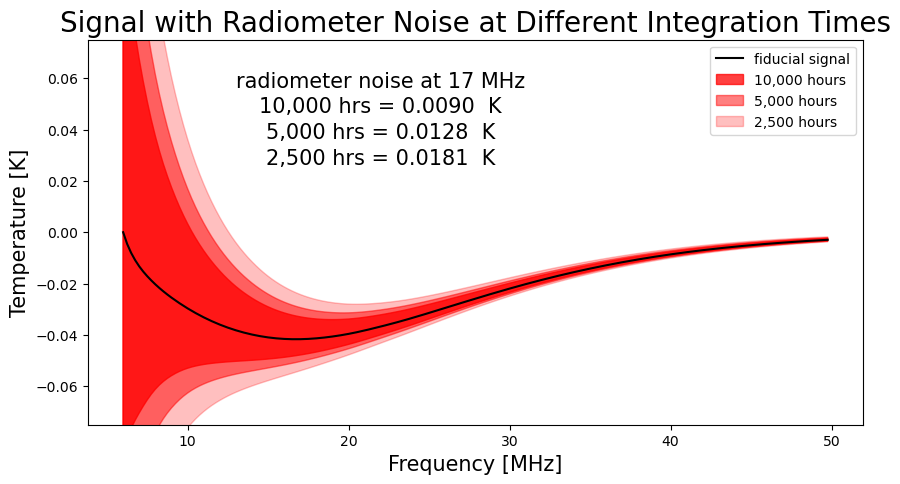

In [71]:
# This is a noise figure for Jack, but might include this in my paper near the noise section...maybe
plt.figure(figsize=(10, 5))
plt.plot(frequencies, simulation_test_beam[1],label = "fiducial signal", c="black")
plt.fill_between(frequencies, simulation_test_beam[1]+sigT(simulation_test_beam[0],N_antenna,dnu,10000*3600),simulation_test_beam[1]-sigT(simulation_test_beam[0],N_antenna,dnu,20000*3600),label="10,000 hours",alpha=0.75,color="red")
plt.fill_between(frequencies, simulation_test_beam[1]+sigT(simulation_test_beam[0],N_antenna,dnu,5000*3600),simulation_test_beam[1]-sigT(simulation_test_beam[0],N_antenna,dnu,10000*3600),label="5,000 hours",alpha=0.5,color="red")
plt.fill_between(frequencies, simulation_test_beam[1]+sigT(simulation_test_beam[0],N_antenna,dnu,2500*3600),simulation_test_beam[1]-sigT(simulation_test_beam[0],N_antenna,dnu,5000*3600),label="2,500 hours",alpha=0.25,color="red")
plt.title("Signal with Radiometer Noise at Different Integration Times",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Temperature [K]",fontsize="15")
plt.text(22, 0.055, "radiometer noise at 17 MHz", ha='center', va='bottom', fontsize=15)
plt.text(22, 0.045, f'10,000 hrs = {sigT(simulation_test_beam[0],N_antenna,dnu,10000*3600)[43]:.4f}  K', ha='center', va='bottom', fontsize=15)
plt.text(22, 0.035, f'5,000 hrs = {sigT(simulation_test_beam[0],N_antenna,dnu,5000*3600)[43]:.4f}  K', ha='center', va='bottom', fontsize=15)
plt.text(22, 0.025, f'2,500 hrs = {sigT(simulation_test_beam[0],N_antenna,dnu,2500*3600)[43]:.4f}  K', ha='center', va='bottom', fontsize=15)
plt.ylim(-0.075,0.075)
plt.legend()

plt.savefig(save_path+"Multi_error_signal")


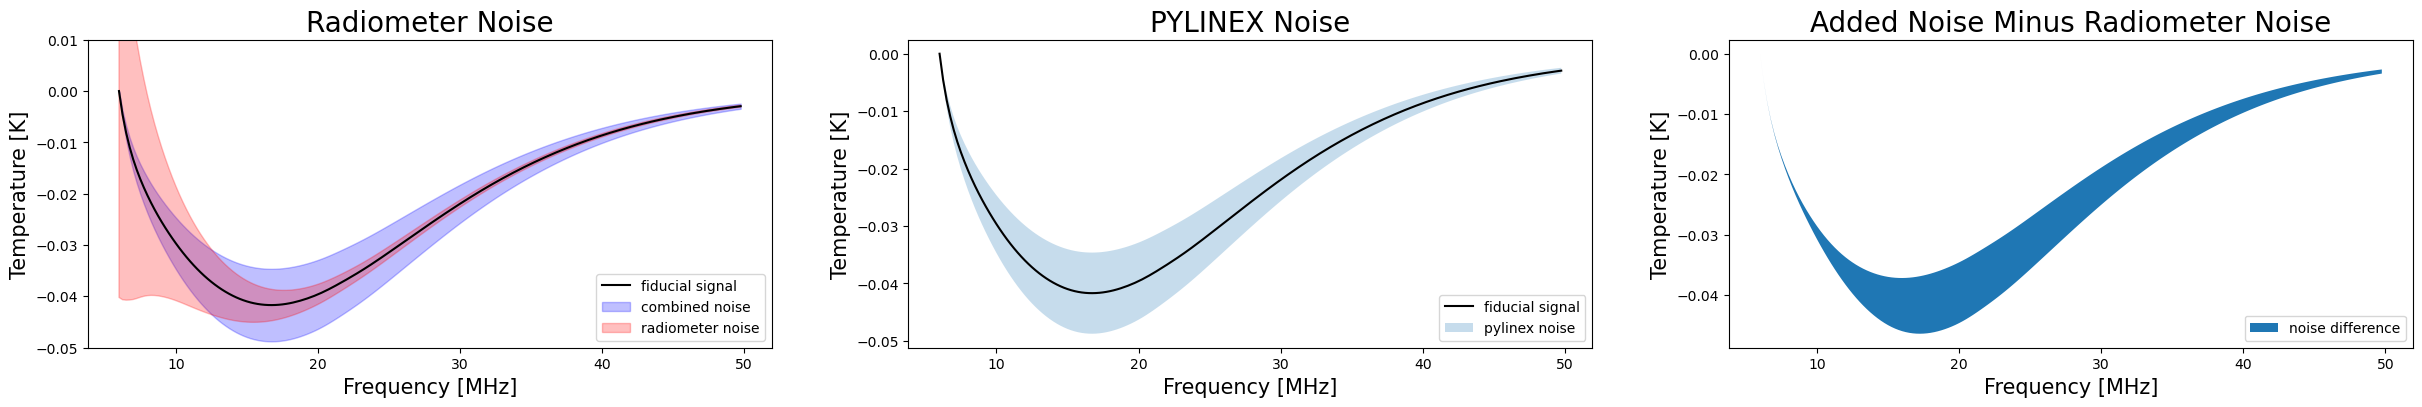

In [10]:
fig, ax = plt.subplots(1,3,figsize=(30, 4))

plt.subplot(1,3,1)
radiometer_error = sigT(simulation_test_beam[0],dnu,350000*3600)
pylinex_error = fitter2.subbasis_channel_error("Signal")
plt.plot(frequencies,fiducial_signal,c="black",label="fiducial signal")
plt.fill_between(frequencies,fiducial_signal+pylinex_error,fiducial_signal-pylinex_error,alpha=0.25,label="combined noise",color="blue")
plt.fill_between(frequencies,fiducial_signal+radiometer_error,fiducial_signal-radiometer_error,alpha=0.25,label="radiometer noise",color="red")
# plt.fill_between(frequencies,fiducial_signal+pylinex_error,fiducial_signal-pylinex_error,alpha=0.25,label="radiometer noise")

plt.title("Radiometer Noise",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Temperature [K]",fontsize="15")
plt.ylim(-0.05,0.01)
plt.legend()

plt.subplot(1,3,2)
radiometer_error = sigT(simulation_test_beam[0],dnu,350000*3600)
pylinex_error = fitter2.subbasis_channel_error("Signal")
added_error = np.sqrt(pylinex_error**2+radiometer_error**2)
plt.plot(frequencies,fiducial_signal,c="black",label="fiducial signal")
# plt.fill_between(frequencies,fiducial_signal+(added_error-radiometer_error),fiducial_signal-(added_error-radiometer_error),alpha=1,label="radiometer noise")
plt.fill_between(frequencies,fiducial_signal+pylinex_error,fiducial_signal-pylinex_error,alpha=0.25,label="pylinex noise")
plt.title("PYLINEX Noise",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Temperature [K]",fontsize="15")
plt.legend()

plt.subplot(1,3,3)
radiometer_error = sigT(simulation_test_beam[0],dnu,350000*3600)
pylinex_error = fitter2.subbasis_channel_error("Signal")
added_error = np.sqrt(pylinex_error**2+radiometer_error**2)
# plt.plot(frequencies,fiducial_signal,c="black",label="fiducial signal")
plt.fill_between(frequencies,fiducial_signal+(added_error-radiometer_error),fiducial_signal-(added_error-radiometer_error),alpha=1,label="noise difference")
# plt.fill_between(frequencies,fiducial_signal+pylinex_error,fiducial_signal-pylinex_error,alpha=0.25,label="radiometer noise")
plt.title("Added Noise Minus Radiometer Noise",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Temperature [K]",fontsize="15")
plt.legend()


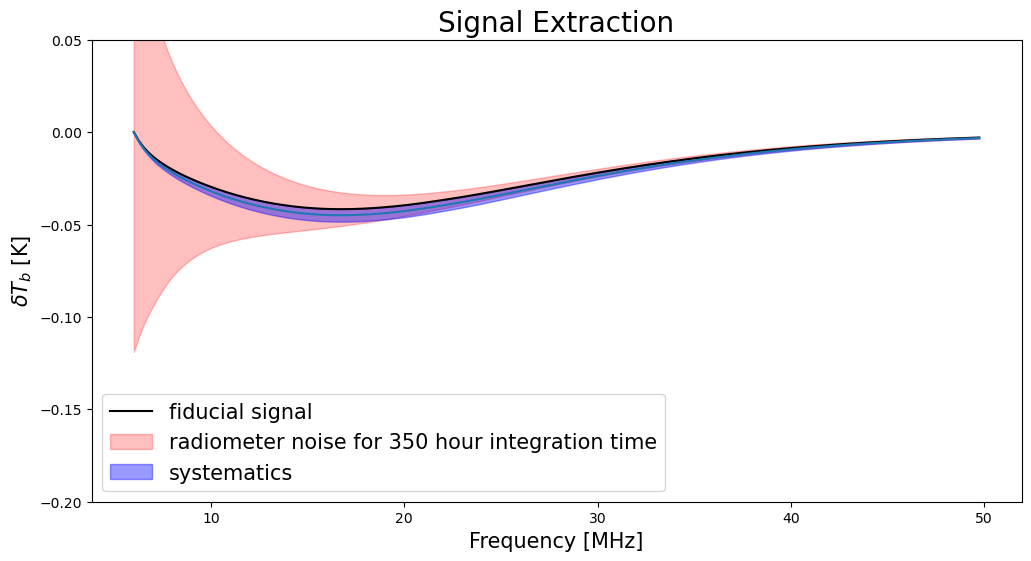

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

radiometer_error = sigT(simulation_test_beam[0],dnu,20**2*350*3600)
pylinex_error = fitter2.subbasis_channel_error("Signal")
plt.plot(frequencies,fiducial_signal,c="black",label="fiducial signal")

plt.fill_between(frequencies,fiducial_signal+radiometer_error,fiducial_signal-radiometer_error,alpha=0.25,label="radiometer noise for 350 hour integration time",color="red")
plt.fill_between(frequencies,fiducial_signal+pylinex_error,fiducial_signal-pylinex_error,alpha=0.4,label="systematics",color="blue")
# plt.fill_between(frequencies,fiducial_signal+pylinex_error,fiducial_signal-pylinex_error,alpha=0.25,label="radiometer noise")

plt.title("Signal Extraction for 10 Cross Dipole Antennas",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel(r"$\delta T_b$ [K]",fontsize="15")
plt.ylim(-0.05,0.01)
# plt.text(27.3, 0, f'radiometer error @ 17 MHz = {radiometer_error[43]:.4f} K', ha='center', va='bottom', fontsize=15)
plt.legend(fontsize=15)

# plt.subplot(1,3,2)
# radiometer_error = sigT(simulation_test_beam[0],dnu,350000*3600)
# pylinex_error = fitter2.subbasis_channel_error("Signal")
# added_error = np.sqrt(pylinex_error**2+radiometer_error**2)
# plt.plot(frequencies,fiducial_signal,c="black",label="fiducial signal")
# # plt.fill_between(frequencies,fiducial_signal+(added_error-radiometer_error),fiducial_signal-(added_error-radiometer_error),alpha=1,label="radiometer noise")
# plt.fill_between(frequencies,fiducial_signal+pylinex_error,fiducial_signal-pylinex_error,alpha=0.25,label="pylinex noise")
# plt.title("PYLINEX Noise",fontsize=20)
# plt.xlabel("Frequency [MHz]",fontsize="15")
# plt.ylabel("Temperature [K]",fontsize="15")
# plt.text(22.3, -0.01, f'pylinex error @ 17 MHz = {fitter2.subbasis_channel_error("Signal")[43]:.4f} K', ha='center', va='bottom', fontsize=15)
# plt.legend()

# plt.subplot(1,3,3)
# radiometer_error = sigT(simulation_test_beam[0],dnu,350000*3600)
# pylinex_error = fitter2.subbasis_channel_error("Signal")
# added_error = np.sqrt(pylinex_error**2+radiometer_error**2)
# # plt.plot(frequencies,fiducial_signal,c="black",label="fiducial signal")
# plt.fill_between(frequencies,fiducial_signal+(added_error-radiometer_error),fiducial_signal-(added_error-radiometer_error),alpha=1,label="noise difference")
# # plt.fill_between(frequencies,fiducial_signal+pylinex_error,fiducial_signal-pylinex_error,alpha=0.25,label="radiometer noise")
# plt.title("Added Noise Minus Radiometer Noise",fontsize=20)
# plt.xlabel("Frequency [MHz]",fontsize="15")
# plt.ylabel("Temperature [K]",fontsize="15")
# plt.legend()
plt.savefig(save_path+"350hrs_10antennas")

In [33]:
print(20**2*350)

140000


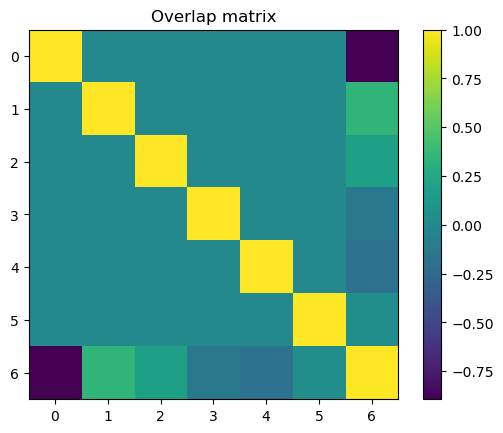

In [146]:
fitter2.plot_overlap_matrix()

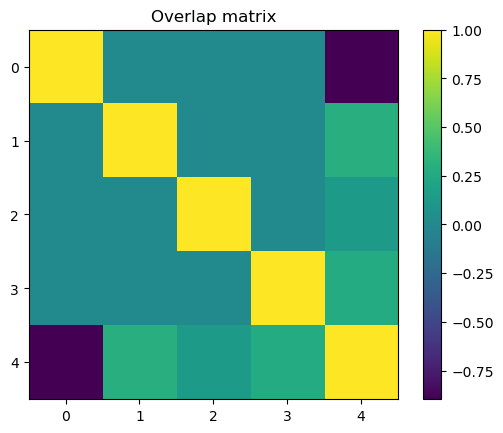

In [149]:

fitter2.plot_overlap_matrix()

In [91]:
added_error-radiometer_error

array([0.00000000e+00, 1.93168263e-07, 6.66197538e-07, 1.33290389e-06,
       2.15780868e-06, 3.12894941e-06, 4.25301277e-06, 5.54826707e-06,
       7.02630217e-06, 8.68867574e-06, 1.05388247e-05, 1.25836038e-05,
       1.48355197e-05, 1.73133307e-05, 2.00303425e-05, 2.29958782e-05,
       2.62130175e-05, 2.96816592e-05, 3.34001514e-05, 3.73671074e-05,
       4.15832979e-05, 4.60515515e-05, 5.07685130e-05, 5.57290311e-05,
       6.09293220e-05, 6.63663639e-05, 7.20299299e-05, 7.79066320e-05,
       8.39822629e-05, 9.02424664e-05, 9.66734529e-05, 1.03264268e-04,
       1.10007879e-04, 1.16897674e-04, 1.23911822e-04, 1.31023031e-04,
       1.38202941e-04, 1.45423414e-04, 1.52659260e-04, 1.59888371e-04,
       1.67092408e-04, 1.74255024e-04, 1.81352700e-04, 1.88361161e-04,
       1.95258370e-04, 2.02024349e-04, 2.08639356e-04, 2.15085712e-04,
       2.21349361e-04, 2.27418930e-04, 2.33280329e-04, 2.38921287e-04,
       2.44332396e-04, 2.49505710e-04, 2.54420892e-04, 2.59047149e-04,
      

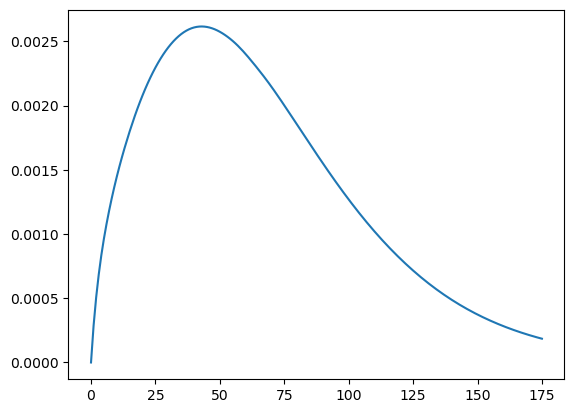

In [88]:
plt.plot(fitter2.subbasis_channel_error("Signal"))

In [25]:
# Noise levels from various integration times at 17 MHz
sig_10=sigT(simulation_test_beam[0],dnu,10000*3600)[43]
sig_5=sigT(simulation_test_beam[0],dnu,5000*3600)[43]
sig_2dot5=sigT(simulation_test_beam[0],dnu,2500*3600)[43]
print(sig_10)
print(sig_5)
print(sig_2dot5)

0.01807425279839379
0.025560853437248364
0.03614850559678758


## Training Set Curve Number Optimization Test
- Takes a long time to run, so I'll save it for last
- I would also like to add STD in a fill between for the graph

In [35]:

## Creates the bases 5 times and compares the results.
iterations = 1 # number of basis to average per value
N_vectors = 20
bases_ts_test = np.zeros((iterations,N_vectors,len(frequencies)))
average_diff = np.zeros((iterations-1))


values = [1000000]
# values = [51,100000]
average_diff_num_foreground = np.zeros((3,len(values)))
for i,N in enumerate (values):
    # numbers for the training sets
    Nb = int(np.sqrt(N))
    Nfg = int(np.sqrt(N))
    # Nb = 100
    # Nfg = 10000
    Ns = N
    for b in tqdm(range(iterations)):
        pbar = manager.counter(total=iterations, desc='Iterations')
    #### Pylinex Fit #####

        custom_parameter_range = np.array([[0.999975,1.000025],[3.39999,3.40001],[4.59999,4.60001]])  # For making a random foreground
        parameter_variation = [0.0000005,0.00000025,0.0000005]                              # For making a random foreground
        rms_mean = 0.05
        rms_std = 0.009
        ## Interpolate the varied beams to match the rest of the data
        varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
        for n in range(len(varied_regolith_training_set_raw)):
            beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
            varied_regolith_training_set[n] = beam_regolith_interp(frequencies)

        exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                                    custom_parameter_range,show_parameter_ranges=True)
        n_regions = 5
        reference_frequency = 25
        sky_map = foreground_array_minCMB[0]
        BTS_curves = exp_test[0]
        BTS_params = exp_test[1]
        beam_sky_training_set = beams[:,5:,:]
        beam_sky_training_set_params = varied_regolith_training_set_raw_params
        raw_beam_weighted_sky_maps = raw_sky_maps

        # parameter_variation = [0.05,0.025,0.05]
        determine_parameter_range = True
        new_FG_parameter_mean = None
        foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                            beam_sky_training_set,beam_sky_training_set_params,Nfg,parameter_variation,B_value_functions,\
                                                define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)



# ### This takes quite some time to run, so let's save these numbers

# # ### HDF5 data saving 
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/basis_test_data2","w")
hdf5.create_dataset("training_set",data=foreground_run_set[3])
hdf5.create_dataset("parameters",data=foreground_run_set[4])
hdf5.close()
# # ### End of HDF5 data saving


# ## Now the loop for each exotic signal training set
# values=[10000]
# # lambda CDM
# bases_ts_test = np.zeros((iterations,N_vectors,len(frequencies)))
# average_diff = np.zeros((iterations-1))
# parameter_array = np.array([[omR0,0],[omM0,0.013],[omK0,0],[omL0,0.0062],[omB0,0.00014/h**2]])
# values = [10000]
# average_diff_num_lambdaCDM = np.zeros((3,len(values)))
# for i,N in enumerate (values):
#     # numbers for the training sets
#     Nb = int(np.sqrt(N))
#     Nfg = int(np.sqrt(N))
#     # Nb = 100
#     # Nfg = 10000
#     Ns = N
#     for b in tqdm(range(iterations)):
#         pbar = manager.counter(total=iterations, desc='Iterations')
#         signal_training_set_lambdaCDM=py21cmsig.lambdaCDM_training_set(frequencies,parameter_array,N)
#         signal_training_set = signal_training_set_lambdaCDM[0]
#         noise_level = sigT(sim_data,dnu,dt)
#         signal_training_set_array = copy.deepcopy(signal_training_set)
#         signal_basis_CDM2 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)


# ### This takes quite some time to run, so let's save these numbers

# ### HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/lambdaCDM_training_set2","w")
# hdf5.create_dataset("training_set",data=signal_training_set_lambdaCDM[0])
# hdf5.create_dataset("parameters",data=signal_training_set_lambdaCDM[1])
# hdf5.close()
### End of HDF5 data saving
# N = 10000
# # DMAN
# parameters_DMAN = [[2*10e-22,1*10e-22,5*10e-23,2*10e-23,5*10e-24,2*10e-24]]
# bases_ts_test = np.zeros((iterations,N_vectors,len(frequencies)))
# average_diff = np.zeros((iterations-1))
# average_diff_num_DMAN = np.zeros((3,len(values)))

# pbar = manager.counter(total=iterations, desc='Iterations')
# DMAN_training_set=py21cmsig.DMAN_training_set(frequencies,parameters_DMAN,N)


# ### This takes quite some time to run, so let's save these numbers

# ### HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/DMAN_training_set","w")
# hdf5.create_dataset("training_set",data=DMAN_training_set[0])
# hdf5.create_dataset("parameters",data=DMAN_training_set[1])
# hdf5.close()
# ### End of HDF5 data saving

# # DMD
# bases_ts_test = np.zeros((iterations,N_vectors,len(frequencies)))
# average_diff = np.zeros((iterations-1))
# parameters_DMD = [[0.5*10e26, 1*10e26, 3*10e26, 10*10e26, 30*10e26, 100*10e26, 500*10e26]]
# average_diff_num_DMD = np.zeros((3,len(values)))

# DMD_training_set=py21cmsig.DMD_training_set(frequencies,parameters_DMD,N)


# ### This takes quite some time to run, so let's save these numbers

# ### HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/DMD_training_set","w")
# hdf5.create_dataset("training_set",data=DMD_training_set[0])
# hdf5.create_dataset("parameters",data=DMD_training_set[1])
# hdf5.close()
# ### End of HDF5 data saving

# # MCDM
# bases_ts_test = np.zeros((iterations,N_vectors,len(frequencies)))
# average_diff = np.zeros((iterations-1))
# parameters_MCDM = [[0.1,0.5,2,5,10]]
# average_diff_num_MCDM = np.zeros((3,len(values)))

# MCDM_training_set = py21cmsig.MCDM_training_set(frequencies,parameters_MCDM,N)


# ### This takes quite some time to run, so let's save these numbers

# ### HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/MCDM_training_set","w")
# hdf5.create_dataset("training_set",data=MCDM_training_set[0])
# hdf5.create_dataset("parameters",data=MCDM_training_set[1])
# hdf5.close()
# ### End of HDF5 data saving

# # EDE
# bases_ts_test = np.zeros((iterations,N_vectors,len(frequencies)))
# average_diff = np.zeros((iterations-1))
# parameters_EDE = np.array([[2e-5,4e-5],[50,100]])
# average_diff_num_EDE = np.zeros((3,len(values)))

# EDE_training_set = py21cmsig.EDE_training_set(frequencies,parameters_EDE,N)


# ### This takes quite some time to run, so let's save these numbers

# ### HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/EDE_training_set","w")
# hdf5.create_dataset("training_set",data=EDE_training_set[0])
# hdf5.create_dataset("parameters",data=EDE_training_set[1])
# hdf5.close()
# ### End of HDF5 data saving

# # ERB
# bases_ts_test = np.zeros((iterations,N_vectors,len(frequencies)))
# average_diff = np.zeros((iterations-1))
# parameters_ERB = np.array([[0.1,10,375],[25,100,200]])
# average_diff_num_ERB = np.zeros((3,len(values)))

# ERB_training_set = py21cmsig.ERB_training_set(frequencies,parameters_ERB,N)


# ### This takes quite some time to run, so let's save these numbers

# ### HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/ERB_training_set","w")
# hdf5.create_dataset("training_set",data=ERB_training_set[0])
# hdf5.create_dataset("parameters",data=ERB_training_set[1])
# hdf5.close()
# ### End of HDF5 data saving


# ### HDF5 data loading
# # hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/basis_test_data","r")
# # average_diff_num_foreground=hdf5["average_difference_foreground"]
# ### End of HDF5 data loading

# ## Subtracts the first basis from the other 4 and averages the result:

100%|██████████| 176/176 [00:01<00:00, 150.23it/s]


[[0.999975 1.000025]
 [3.39999  3.40001 ]
 [4.59999  4.60001 ]]


100%|██████████| 1/1 [00:22<00:00, 22.27s/it]


[5e-07, 2.5e-07, 5e-07]


In [330]:
# This loads the base signal training sets AND the secondary ones
## Primary Training Sets

#lambda CDM
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/lambdaCDM","r")
lambdaCDM_training_set = f["signal_training_set"]
lambdaCDM_training_set_params = f["signal_training_set_parameters"]


# Self-Annihilating Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMAN","r")
DMAN_training_set = f["signal_training_set"]
DMAN_training_set_params = f["signal_training_set_parameters"]

# Decaying Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMD","r")
DMD_training_set = f["signal_training_set"]
DMD_training_set_params = f["signal_training_set_parameters"]

# Early Dark Energy
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/EDE","r")
EDE_training_set = f["signal_training_set"]
EDE_training_set_params = f["signal_training_set_parameters"]

# Extra Radio Background
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/ERB","r")
ERB_training_set = f["signal_training_set"]
ERB_training_set_params = f["signal_training_set_parameters"]

# Baryon-Dark Matter Interaction (MCDM)
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/MCDM","r")
MCDM_training_set = f["signal_training_set"]
MCDM_training_set_params = f["signal_training_set_parameters"]

## Secondary Training Sets
#lambda CDM
f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/lambdaCDM_training_set2","r")
lambdaCDM_training_set2 = f["training_set"]
lambdaCDM_training_set_params2 = f["parameters"]

# Self-Annihilating Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/DMAN_training_set","r")
DMAN_training_set2 = f["training_set"]
DMAN_training_set_params2 = f["parameters"]

# Decaying Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/DMD_training_set","r")
DMD_training_set2 = f["training_set"]
DMD_training_set_params2 = f["parameters"]

# Early Dark Energy
f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/EDE_training_set","r")
EDE_training_set2 = f["training_set"]
EDE_training_set_params2 = f["parameters"]

# Extra Radio Background
f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/ERB_training_set","r")
ERB_training_set2 = f["training_set"]
ERB_training_set_params2 = f["parameters"]

# Baryon-Dark Matter Interaction (MCDM)
f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/MCDM_training_set","r")
MCDM_training_set2 = f["training_set"]
MCDM_training_set_params2 = f["parameters"]

#foreground training sets

f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/basis_test_data1_2mil","r")
foreground_training_set = f["training_set"]
foreground_training_set_params = f["parameters"]

f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/basis_test_data2_2mil","r")
foreground_training_set2 = f["training_set"]
foreground_training_set_params2 = f["parameters"]

# Modified 20k Lambda CDM training set with 20k for a better RMS graph
f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/lambdaCDM_training_set1_20k","r")
lambdaCDM_training_set_20k = f["training_set"]
lambdaCDM_training_set_20k_params = f["parameters"]

f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/lambdaCDM_training_set2_20k","r")
lambdaCDM_training_set_20k2 = f["training_set"]
lambdaCDM_training_set_20k2_params2 = f["parameters"]


In [332]:
# Now let's vary the selection for each and see when they stop changin
N_vectors = 20 # number of vectors used to make the basis. Usually 20 is plenty
noise_level = sigT(simulation_test_beam[4],N_antenna,dnu,dt)
sel_array_foreground = np.arange(50000,3050000,50000) #the upper index of your selection. Change this to make your training sets bigger to determine when they have lower error.
sel_array = np.arange(100,20000,100)
sel_array_mod = np.arange(100,10100,100)
RMS = lambda curve1, curve2: (((curve1-curve2)**2).sum())**(1/2) # quick little rms function for ease
rms_array_foreground = np.zeros(len(sel_array_foreground))
rms_array = np.zeros((6,len(sel_array)))
RMS_vecnum = 15

sel_fg = 3000000

# foreground
foreground_training_set_array = foreground_training_set[0:sel_fg]
foreground_basis1 = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
foreground_training_set_array = foreground_training_set2[0:sel_fg]
foreground_basis2 = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
rms = 0
for n in range(RMS_vecnum):
    rms += RMS(np.abs(foreground_basis1.basis[n]),np.abs(foreground_basis2.basis[n]))
rms_array_foreground[i] = rms

sel = 10000
# lambda CDM
signal_training_set_array = lambdaCDM_training_set_20k[0:sel]
signal_basis_CDM1 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
signal_training_set_array = lambdaCDM_training_set_20k2[0:sel]
signal_basis_CDM2 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
rms = 0
for n in range(RMS_vecnum):
    rms += RMS(np.abs(signal_basis_CDM1.basis[n]),np.abs(signal_basis_CDM2.basis[n]))
rms_array[0][i] = rms

# DMAN
signal_training_set_array = DMAN_training_set[0:sel]
signal_basis_DMAN1 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
signal_training_set_array = DMAN_training_set2[0:sel]
signal_basis_DMAN2 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
rms = 0
for n in range(RMS_vecnum):
    rms += RMS(np.abs(signal_basis_DMAN1.basis[n]),np.abs(signal_basis_DMAN2.basis[n]))
rms_array[1][i] = rms

# DMD
signal_training_set_array = DMD_training_set[0:sel]
signal_basis_DMD1 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
signal_training_set_array = DMD_training_set2[0:sel]
signal_basis_DMD2 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
rms = 0
for n in range(RMS_vecnum):
    rms += RMS(np.abs(signal_basis_DMD1.basis[n]),np.abs(signal_basis_DMD2.basis[n]))
rms_array[2][i] = rms

# MCDM
signal_training_set_array = MCDM_training_set[0:sel]
signal_basis_MCDM1 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
signal_training_set_array = MCDM_training_set2[0:sel]
signal_basis_MCDM2 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
rms = 0
for n in range(RMS_vecnum):
    rms += RMS(np.abs(signal_basis_MCDM1.basis[n]),np.abs(signal_basis_MCDM2.basis[n]))
rms_array[3][i] = rms

# EDE
signal_training_set_array = EDE_training_set[0:sel]
signal_basis_EDE1 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
signal_training_set_array = EDE_training_set2[0:sel]
signal_basis_EDE2 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)

rms = 0
for n in range(RMS_vecnum):
    rms += RMS(np.abs(signal_basis_EDE1.basis[n]),np.abs(signal_basis_EDE2.basis[n]))
rms_array[4][i] = rms
# ERB
signal_training_set_array = ERB_training_set[0:sel]
signal_basis_ERB1 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
signal_training_set_array = ERB_training_set2[0:sel]
signal_basis_ERB2 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)

rms = 0
for n in range(RMS_vecnum):
    rms += RMS(np.abs(signal_basis_ERB1.basis[n]),np.abs(signal_basis_ERB2.basis[n]))
rms_array[5][i] = rms
# Now for the plots we use to determine the changes:

sel2 = 50 #the upper index of your selection. Change this to make your training sets bigger to determine when they have lower error.
sel2_fg = 1000
# foreground
foreground_training_set_array = foreground_training_set[0:sel2]
foreground_basis1_100 = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
foreground_training_set_array = foreground_training_set2[0:sel2]
foreground_basis2_100 = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=N_vectors,error=noise_level)

# lambda CDM
signal_training_set_array = lambdaCDM_training_set[0:sel2]
signal_basis_CDM1_100 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
signal_training_set_array = lambdaCDM_training_set2[0:sel2]
signal_basis_CDM2_100 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)

# DMAN
signal_training_set_array = MCDM_training_set[0:sel2]
signal_basis_MCDM1_100 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)
signal_training_set_array = MCDM_training_set2[0:sel2]
signal_basis_MCDM2_100 = TrainedBasis(training_set=signal_training_set_array, num_basis_vectors=N_vectors,error=noise_level)


### Note: This was created in the copy of this notebook (running in parrallel to save time)

# HDF5 Loading of rms array
f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/rms_arrays","r")
signal_rms = f["signal_rms"]

f = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/rms_arrays_new","r")
foreground_rms = f["foreground_rms"]
## End HDf5 loading

In [362]:
sel_array.shape

(199,)

NameError: name 'sel_array_foreground' is not defined

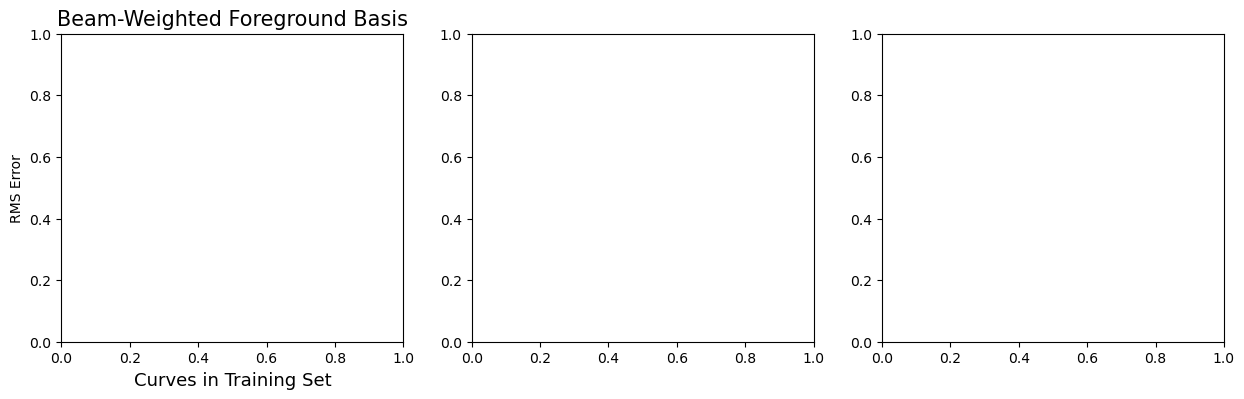

In [9]:
fig, ax = plt.subplots(1,3,figsize=(15, 4))

plt.subplot(1,3,1)
plt.title("Beam-Weighted Foreground Basis", fontsize=15)
plt.xlabel("Curves in Training Set",fontsize=13)
plt.ylabel("RMS Error")
plt.plot(sel_array_foreground,np.array(foreground_rms))

plt.subplot(1,3,2)
plt.title("Lambda CDM Basis", fontsize=15)
plt.xlabel("Curves in Training Set",fontsize=13)

plt.plot(sel_array[0:100],np.array(signal_rms[0][0:100]))

plt.subplot(1,3,3)
plt.title("Baryon - DM Interaction Basis", fontsize=15)
plt.xlabel("Curves in Training Set",fontsize=13)

plt.plot(sel_array_mod,np.array(signal_rms[3][0:100]))

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3, hspace=0.3)
# plt.savefig(save_path+"rms_term_optimization")

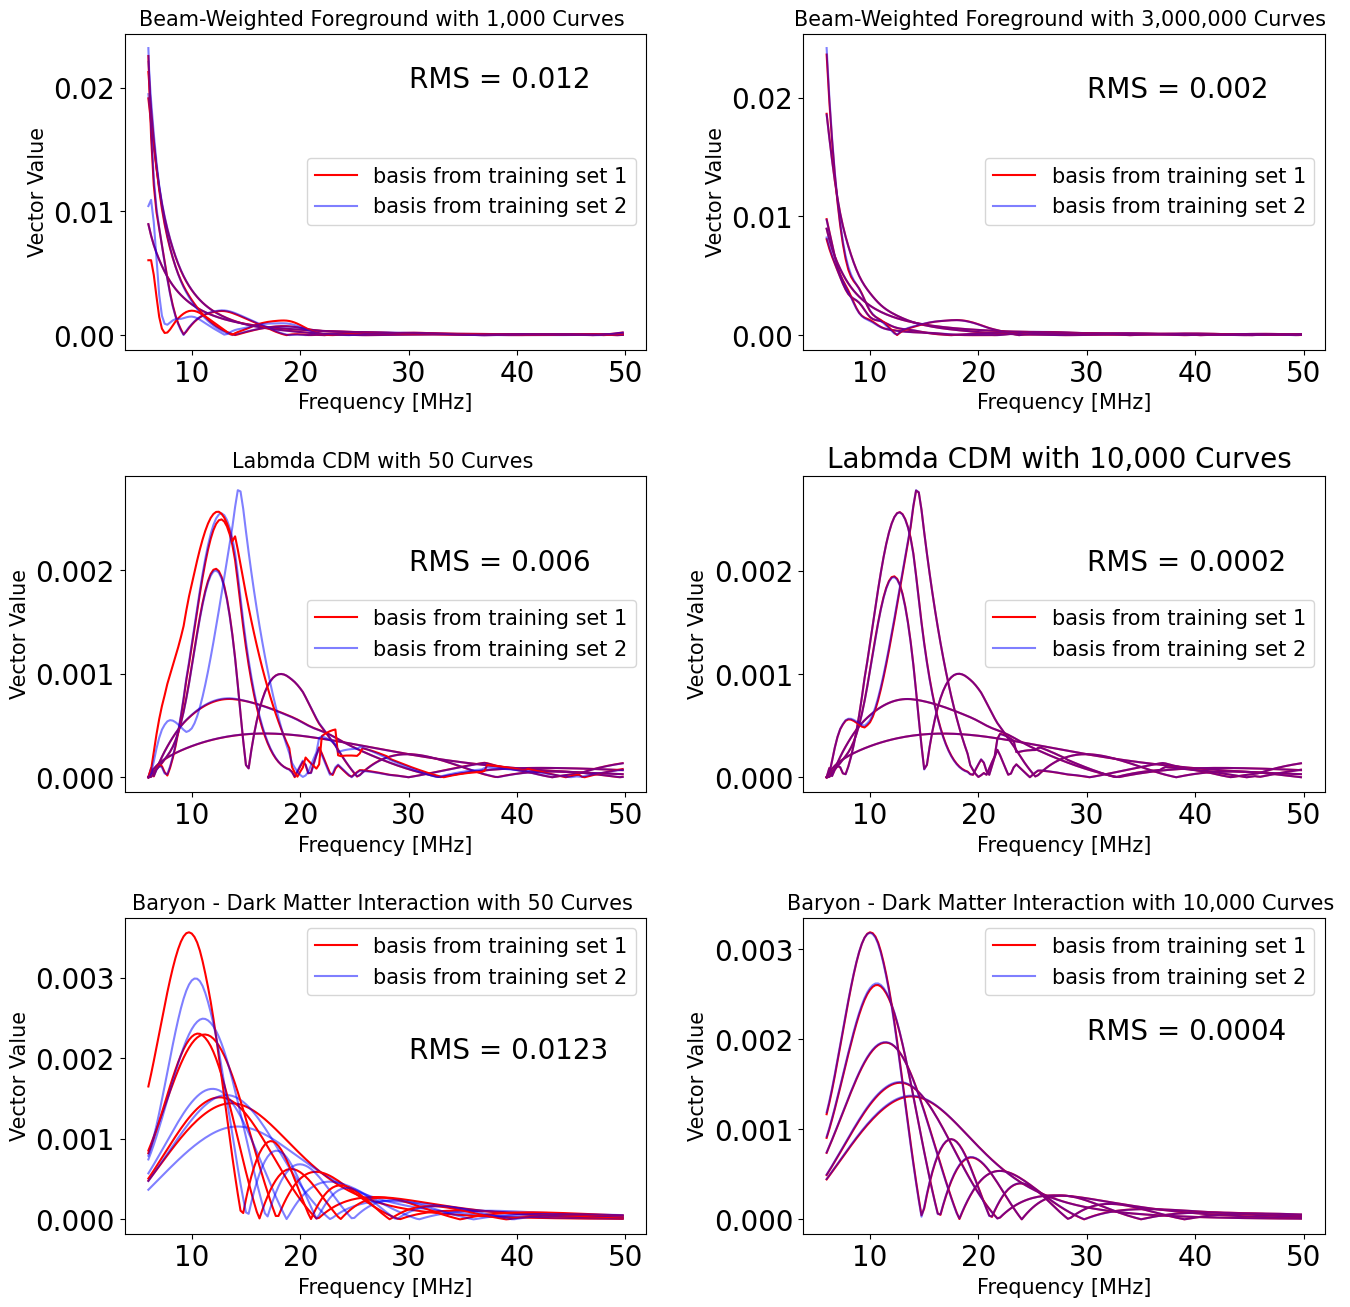

In [346]:

fig, ax = plt.subplots(3,2,figsize=(15, 15))

plt.subplot(3,2,1)
rms = 0
for n in range(5):
    if n == 0:
        plt.plot(frequencies, np.abs(foreground_basis1_100.basis[n]),c="red",label="basis from training set 1")
        plt.plot(frequencies, np.abs(foreground_basis2_100.basis[n]),c="blue",alpha=0.5,label="basis from training set 2")
    else:
        plt.plot(frequencies, np.abs(foreground_basis1_100.basis[n]),c="red")
        plt.plot(frequencies, np.abs(foreground_basis2_100.basis[n]),c="blue",alpha=0.5)
    rms += RMS(np.abs(foreground_basis1_100.basis[n]),np.abs(foreground_basis2_100.basis[n]))
plt.title(f"Beam-Weighted Foreground with {sel2_fg:,} Curves ",fontsize=15)
plt.ylabel("Vector Value",fontsize=15)
plt.xlabel("Frequency [MHz]",fontsize=15)

plt.text(30,0.02,f"RMS = {rms:.3f}",fontsize=20)
plt.legend(fontsize=15)


plt.subplot(3,2,2)
rms = 0
for n in range(5):
    if n == 0:
        plt.plot(frequencies, np.abs(foreground_basis1.basis[n]),c="red",label="basis from training set 1")
        plt.plot(frequencies, np.abs(foreground_basis2.basis[n]),c="blue",alpha=0.5,label="basis from training set 2")
    else:
        plt.plot(frequencies, np.abs(foreground_basis1.basis[n]),c="red")
        plt.plot(frequencies, np.abs(foreground_basis2.basis[n]),c="blue",alpha=0.5)
    rms += RMS(np.abs(foreground_basis1.basis[n]),np.abs(foreground_basis2.basis[n]))
plt.title(f"Beam-Weighted Foreground with {sel_fg:,} Curves ",fontsize=15)
plt.ylabel("Vector Value",fontsize=15)
plt.xlabel("Frequency [MHz]",fontsize=15)

plt.text(30,0.02,f"RMS = {rms:.3f}",fontsize=20)
plt.legend(fontsize=15)

plt.subplot(3,2,3)
rms = 0
for n in range(5):
    if n == 0:
        plt.plot(frequencies, np.abs(signal_basis_CDM1_100.basis[n]),c="red",label="basis from training set 1")
        plt.plot(frequencies, np.abs(signal_basis_CDM2_100.basis[n]),c="blue",alpha=0.5,label="basis from training set 2")
    else:
        plt.plot(frequencies, np.abs(signal_basis_CDM1_100.basis[n]),c="red")
        plt.plot(frequencies, np.abs(signal_basis_CDM2_100.basis[n]),c="blue",alpha=0.5)
    rms += RMS(np.abs(signal_basis_CDM1_100.basis[n]),np.abs(signal_basis_CDM2_100.basis[n]))
plt.title(f"Labmda CDM with {sel2} Curves ",fontsize=15)
plt.ylabel("Vector Value",fontsize=15)
plt.xlabel("Frequency [MHz]",fontsize=15)

plt.text(30,0.002,f"RMS = {rms:.3f}",fontsize=20)
plt.legend(fontsize=15)


plt.subplot(3,2,4)
rms = 0
for n in range(5):
    if n == 0:
        plt.plot(frequencies, np.abs(signal_basis_CDM1.basis[n]),c="red",label="basis from training set 1")
        plt.plot(frequencies, np.abs(signal_basis_CDM2.basis[n]),c="blue",alpha=0.5,label="basis from training set 2")
    else:
        plt.plot(frequencies, np.abs(signal_basis_CDM1.basis[n]),c="red")
        plt.plot(frequencies, np.abs(signal_basis_CDM2.basis[n]),c="blue",alpha=0.5)
    rms += RMS(np.abs(signal_basis_CDM1.basis[n]),np.abs(signal_basis_CDM2.basis[n]))
plt.title(f"Labmda CDM with {sel:,} Curves ",fontsize=20)
plt.ylabel("Vector Value",fontsize=15)
plt.xlabel("Frequency [MHz]",fontsize=15)

plt.text(30,0.002,f"RMS = {rms:.4f}",fontsize=20)
plt.legend(fontsize=15)
plt.subplot(3,2,5)
rms = 0
for n in range(5):
    if n == 0:
        plt.plot(frequencies, np.abs(signal_basis_MCDM1_100.basis[n]),c="red",label="basis from training set 1")
        plt.plot(frequencies, np.abs(signal_basis_MCDM2_100.basis[n]),c="blue",alpha=0.5,label="basis from training set 2")
    else:
        plt.plot(frequencies, np.abs(signal_basis_MCDM1_100.basis[n]),c="red")
        plt.plot(frequencies, np.abs(signal_basis_MCDM2_100.basis[n]),c="blue",alpha=0.5)
    rms += RMS(np.abs(signal_basis_MCDM1_100.basis[n]),np.abs(signal_basis_MCDM2_100.basis[n]))
plt.title(f"Baryon - Dark Matter Interaction with {sel2} Curves ",fontsize=15)
plt.ylabel("Vector Value",fontsize=15)
plt.xlabel("Frequency [MHz]",fontsize=15)

plt.text(30,0.002,f"RMS = {rms:.4f}",fontsize=20)
plt.legend(fontsize=15)
plt.subplot(3,2,6)
rms = 0
for n in range(5):
    if n == 0:
        plt.plot(frequencies, np.abs(signal_basis_MCDM1.basis[n]),c="red",label="basis from training set 1")
        plt.plot(frequencies, np.abs(signal_basis_MCDM2.basis[n]),c="blue",alpha=0.5,label="basis from training set 2")
    else:
        plt.plot(frequencies, np.abs(signal_basis_MCDM1.basis[n]),c="red")
        plt.plot(frequencies, np.abs(signal_basis_MCDM2.basis[n]),c="blue",alpha=0.5)
    rms += RMS(np.abs(signal_basis_MCDM1.basis[n]),np.abs(signal_basis_MCDM2.basis[n]))
plt.title(f"Baryon - Dark Matter Interaction with {sel:,} Curves ",fontsize=15)
plt.ylabel("Vector Value",fontsize=15)
plt.xlabel("Frequency [MHz]",fontsize=15)

plt.text(30,0.002,f"RMS = {rms:.4f}",fontsize=20)

plt.legend(fontsize=15)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3, hspace=0.4)
plt.savefig(save_path+"Basis_comparisons_term_optimization")
plt.show()

In [54]:
reload(py21cmsig)

Prepared Haslam map in 0.178 s.


<module 'py21cmsig' from '/home/dbarker7752/21_cm_group/LuCEE-Night_Simulation/py21cmsig.py'>

## Example Signal Extraction

  0%|          | 0/176 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 6770.47it/s]


[0, 0, 0]
The parameters for this simulation are [ 1.59202418e+01 -2.65279830e+00 -1.37293590e-02  1.66130589e+01
 -2.69062579e+00 -1.47582387e-02  1.89769800e+01 -2.68235795e+00
 -1.34495335e-02  2.42115565e+01 -2.66682587e+00 -1.20169084e-02
  5.22431891e+01 -2.65055339e+00 -2.42275191e-02  1.00000000e+00
  3.40000000e+00  4.60000000e+00]


100%|██████████| 176/176 [00:02<00:00, 59.23it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 1000/1000 [00:08<00:00, 116.57it/s]


[0.05, 0.025, 0.05]


100%|██████████| 2/2 [00:00<00:00, 7626.01it/s]


[[ 1.51242297e+01  1.67162539e+01 -2.58647835e+00 -2.71911826e+00
  -1.30428910e-02 -1.44158269e-02]
 [ 1.57824060e+01  1.74437118e+01 -2.62336014e+00 -2.75789143e+00
  -1.40203268e-02 -1.54961507e-02]
 [ 1.80281310e+01  1.99258289e+01 -2.61529900e+00 -2.74941689e+00
  -1.27770568e-02 -1.41220102e-02]
 [ 2.30009787e+01  2.54221344e+01 -2.60015522e+00 -2.73349652e+00
  -1.14160630e-02 -1.26177538e-02]
 [ 4.96310296e+01  5.48553485e+01 -2.58428955e+00 -2.71681722e+00
  -2.30161431e-02 -2.54388950e-02]]
[[ 1.51242297e+01  1.67162539e+01 -2.58647835e+00 -2.71911826e+00
  -1.30428910e-02 -1.44158269e-02]
 [ 1.57824060e+01  1.74437118e+01 -2.62336014e+00 -2.75789143e+00
  -1.40203268e-02 -1.54961507e-02]
 [ 1.80281310e+01  1.99258289e+01 -2.61529900e+00 -2.74941689e+00
  -1.27770568e-02 -1.41220102e-02]
 [ 2.30009787e+01  2.54221344e+01 -2.60015522e+00 -2.73349652e+00
  -1.14160630e-02 -1.26177538e-02]
 [ 4.96310296e+01  5.48553485e+01 -2.58428955e+00 -2.71681722e+00
  -2.30161431e-02 -2.543

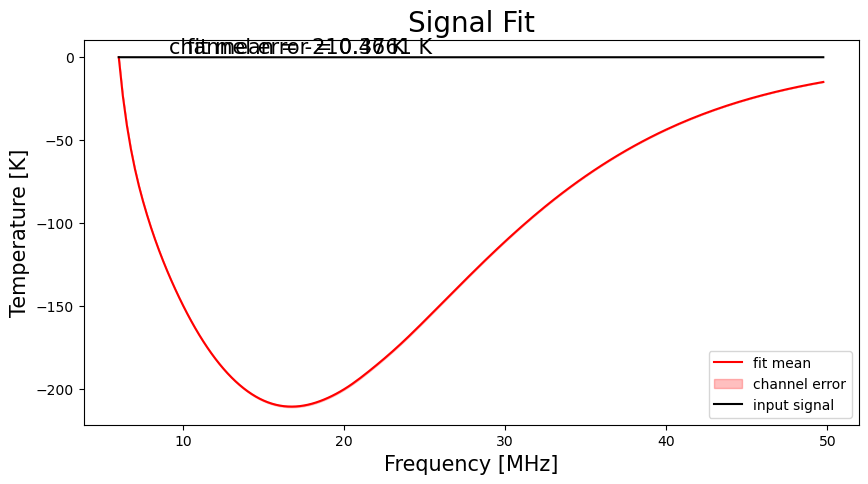

In [66]:



# ## Creates a foreground for the simulation:
# dt = 10000*3600
custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
parameter_variation = [0,0,0]

signal_model = fiducial_signal

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam = py21cmsig.simulation_run(foreground_for_sim,signal_model,N_antenna,dnu,dt)

print(f"The parameters for this simulation are {parameters_for_sim}")

## Creates a training set with varied foreground and beams:

# custom_parameter_range = np.array([[1,2],[3.3,3.5],[4.2,4.7]])
# custom_parameter_range = np.array([[0.999975,1.000025],[3.39999,3.40001],[4.59999,4.60001]])  # For making a random foreground
# parameter_variation = [0.0000005,0.00000025,0.0000005]                           # For making a random foreground
# custom_parameter_range = np.array([[0.975,1.025],[3.39,3.41],[4.59,4.61]]) 
# parameter_variation = [0.05,0.025,0.05]
custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
parameter_variation = [0.05,0.025,0.05] 
rms_mean = 0.05
rms_std = 0.009
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 1000 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1000
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
rms_values = py21cmsig.narrowed_training_set(simulation_test_beam[0],rms_mean,rms_std,foreground_run[3],foreground_run[4])[2]
new_parameter_mean = np.zeros((n_regions,3))
fg_range_array = np.zeros((n_regions,6))
foreground_parameter_variation = np.array(parameter_variation)
for r in range(n_regions):
    new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
    # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
    fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
    fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
    fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
    fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


print(fg_range_array)


print(fg_range_array)

#### Pylinex Fit #####
fg_training_set = foreground_run_set[3]
sig_training_set = lambdaCDM_training_set
IC = "DIC"
sim_data = simulation_test_beam[0]
noise_level = sigT(sim_data,N_antenna,dnu,dt)
foreground_training_set_array = copy.deepcopy(fg_training_set)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=30,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
signal_basis.generate_gaussian_prior()
foreground_basis.generate_gaussian_prior()
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,30)}, {'Signal' : np.arange(1,2)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension,)
fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter2.sizes['Foreground']
num_signal_terms = fitter2.sizes['Signal']
print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
print(f"{fitter2.subbasis_channel_mean("Signal").min()} Temperature of lowest point of the trough ")
print(f"{fitter2.subbasis_channel_error("Signal")[np.where(fitter2.subbasis_channel_mean("Signal")==fitter2.subbasis_channel_mean("Signal").min())][0]} Channel error at lowest point of the trough ")
# print(f"{fitter2.log_evidence} log evidence")
print(f"{fitter2.chi_squared} Chi Squared")
print(f"{fitter2.psi_squared} Psi Squared")
pearsonr=scipy.stats.pearsonr(fitter2.subbasis_channel_mean("Signal")/simulation_test_beam[2],(fitter2.subbasis_channel_mean("Foreground")-simulation_test_beam[2])/simulation_test_beam[2])
print(f"True {pearsonr}")

plt.figure(figsize=(10, 5))
plt.plot(frequencies, fitter2.subbasis_channel_mean("Signal"),label = "fit mean", c="red")
plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Signal")+fitter2.subbasis_channel_error("Signal"),fitter2.subbasis_channel_mean("Signal")-fitter2.subbasis_channel_error("Signal"),label="channel error",alpha=0.25,color="red")
plt.title("Signal Fit",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Temperature [K]",fontsize="15")
plt.text(17, -0.01, f'fit mean = {fitter2.subbasis_channel_mean("Signal")[43]:.2f} K', ha='center', va='bottom', fontsize=15)
plt.text(17.3, -0.015, f'channel error = {fitter2.subbasis_channel_error("Signal")[43]:.4f} K', ha='center', va='bottom', fontsize=15)
plt.plot(frequencies,simulation_test_beam[1],label="input signal",c="black")
plt.legend()
# plt.savefig(save_path+"Example_extraction")

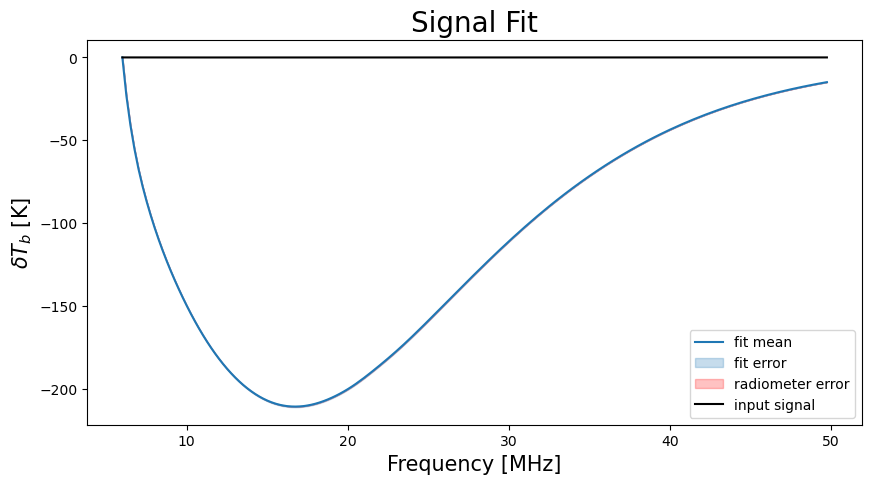

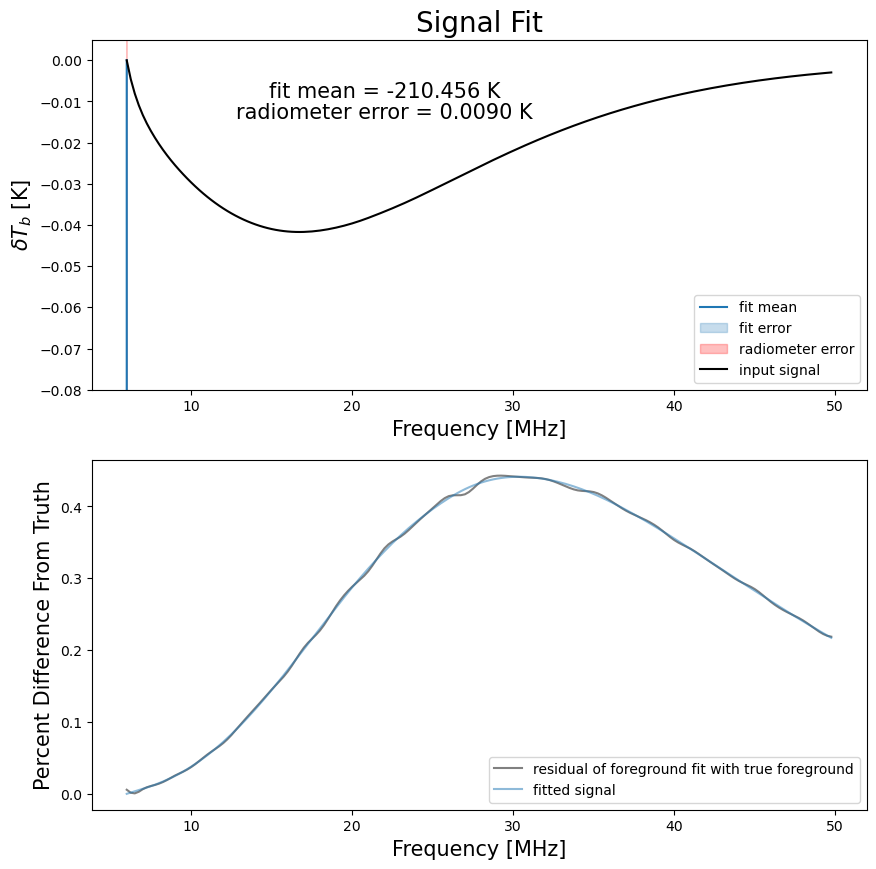

In [69]:
# #### Pylinex Fit #####
# fg_training_set = foreground_run_set[3]
# sig_training_set = lambdaCDM_training_set
# IC = "DIC"
# sim_data = simulation_test_beam[0]
# noise_level = sigT(sim_data,dnu,dt)
# foreground_training_set_array = copy.deepcopy(fg_training_set)
# foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=30,error=noise_level)
# signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
# signal_basis.generate_gaussian_prior()
# foreground_basis.generate_gaussian_prior()
# temperatures = sim_data
# basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
# quantity = AttributeQuantity(IC)
# dimension = [{'Foreground' : np.arange(1,2)}, {'Signal' : np.arange(1,20)}]  
# # priors = {"Signal_prior" : signal_basis.gaussian_prior}
# meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension,)
# fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
# num_foreground_terms = fitter2.sizes['Foreground']
# num_signal_terms = fitter2.sizes['Signal']
# print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
# print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
# print(f"{fitter2.subbasis_channel_mean("Signal").min()} Temperature of lowest point of the trough ")
# print(f"{fitter2.subbasis_channel_error("Signal")[np.where(fitter2.subbasis_channel_mean("Signal")==fitter2.subbasis_channel_mean("Signal").min())][0]} Channel error at lowest point of the trough ")
# # print(f"{fitter2.log_evidence} log evidence")
# print(f"{fitter2.chi_squared} Chi Squared")
# print(f"{fitter2.psi_squared} Psi Squared")
# pearsonr=scipy.stats.pearsonr(fitter2.subbasis_channel_mean("Signal")/simulation_test_beam[2],(fitter2.subbasis_channel_mean("Foreground")-simulation_test_beam[2])/simulation_test_beam[2])
# print(f"True {pearsonr}")
noise = sigT(simulation_test_beam[0],N_antenna,dnu,10000*3600)
plt.figure(figsize=(10, 5))
plt.plot(frequencies, fitter2.subbasis_channel_mean("Signal"),label = "fit mean", c="tab:blue")
plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Signal")+fitter2.subbasis_channel_error("Signal"),fitter2.subbasis_channel_mean("Signal")-fitter2.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="tab:blue")
plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Signal")+noise,fitter2.subbasis_channel_mean("Signal")-noise,label="radiometer error",alpha=0.24,color="red")
plt.title("Signal Fit",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel(r"$\delta T_b$ [K]",fontsize="15")
plt.plot(frequencies,simulation_test_beam[1],label="input signal",c="black")
plt.legend()
# plt.ylim(-0.09,0.04)
# plt.savefig(save_path+"Example_extraction")

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 10))

plt.subplot(2,1,1)
plt.plot(frequencies, fitter2.subbasis_channel_mean("Signal"),label = "fit mean", c="tab:blue")
plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Signal")+fitter2.subbasis_channel_error("Signal"),fitter2.subbasis_channel_mean("Signal")-fitter2.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="tab:blue")
plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Signal")+noise,fitter2.subbasis_channel_mean("Signal")-noise,label="radiometer error",alpha=0.25,color="red")
plt.title("Signal Fit",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel(r"$\delta T_b$ [K]",fontsize="15")
plt.text(22, -0.01, f'fit mean = {fitter2.subbasis_channel_mean("Signal")[43]:.3f} K', ha='center', va='bottom', fontsize=15)
plt.text(22, -0.015, f'radiometer error = {noise[43]:.4f} K', ha='center', va='bottom', fontsize=15)
plt.plot(frequencies,simulation_test_beam[1],label="input signal",c="black")
plt.ylim(-0.08,0.005)
plt.legend()


plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter2.subbasis_channel_mean("Foreground")[0:len(frequencies)]-simulation_test_beam[2]))/simulation_test_beam[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,-fitter2.subbasis_channel_mean("Signal")/simulation_test_beam[2]*100,c="tab:blue",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Percent Difference From Truth",fontsize="15")

plt.legend()

# plt.savefig(save_path+"Example_extraction_with_degen")

In [183]:
fitter2.subbasis_channel_error("Signal")

array([3.58811424e-16, 2.09982422e-04, 3.78990571e-04, 5.34361780e-04,
       6.80883038e-04, 8.18466227e-04, 9.46210232e-04, 1.06423151e-03,
       1.17559859e-03, 1.28050137e-03, 1.37895778e-03, 1.47106008e-03,
       1.55695645e-03, 1.63683680e-03, 1.71092566e-03, 1.78042064e-03,
       1.84640799e-03, 1.90879223e-03, 1.96751754e-03, 2.02254909e-03,
       2.07387007e-03, 2.12147999e-03, 2.16539319e-03, 2.20563764e-03,
       2.24225373e-03, 2.27529335e-03, 2.30481890e-03, 2.33090027e-03,
       2.35355800e-03, 2.37283660e-03, 2.38881652e-03, 2.40158653e-03,
       2.41130329e-03, 2.41854061e-03, 2.42365633e-03, 2.42682260e-03,
       2.42816551e-03, 2.42773582e-03, 2.42557652e-03, 2.42173462e-03,
       2.41626085e-03, 2.40920927e-03, 2.40063688e-03, 2.39060327e-03,
       2.37917020e-03, 2.36640124e-03, 2.35236140e-03, 2.33711674e-03,
       2.32073402e-03, 2.30328041e-03, 2.28482307e-03, 2.26542896e-03,
       2.24516445e-03, 2.22400941e-03, 2.20135038e-03, 2.17701649e-03,
      

In [238]:
signal_basis.basis/fitter2.subbasis_channel_error("Signal")

array([[-4.41574314e-01,  4.41775904e-01,  4.32492339e-01, ...,
         3.19225193e-01,  3.17199903e-01,  3.15215552e-01],
       [ 4.81534490e-03, -3.56742045e-02,  1.69488158e-01, ...,
        -7.16051102e-01, -7.20647487e-01, -7.25090545e-01],
       [ 1.09397269e+01, -2.99287132e-01, -2.92143752e-01, ...,
         6.76046120e-02,  3.56063162e-02,  2.01126936e-03],
       ...,
       [ 5.04753736e+04,  7.57997739e-01, -7.04775308e-01, ...,
        -9.40031739e-02, -1.19993179e-01, -1.48340045e-01],
       [-6.54380042e+03,  3.07879874e-01, -1.26659793e+00, ...,
         2.88659475e-01,  3.31920960e-01,  3.77349530e-01],
       [ 2.63024453e+04, -7.87689185e-01,  1.50997847e+00, ...,
        -2.55114412e-01, -3.07123422e-01, -3.59568804e-01]])

In [241]:
np.sqrt(noise_level**2+noise_level**2)

array([0.3363749 , 0.30178926, 0.27319923, 0.24920744, 0.22841612,
       0.20964943, 0.19261839, 0.17725554, 0.16349361, 0.15124348,
       0.14032985, 0.13055542, 0.12172291, 0.11365921, 0.10628583,
       0.09954848, 0.09339259, 0.08776438, 0.08261262, 0.07788656,
       0.07353563, 0.06951319, 0.06578859, 0.06233525, 0.05912656,
       0.056138  , 0.05335334, 0.0507584 , 0.04833909, 0.04608126,
       0.04397112, 0.04199482, 0.04013865, 0.03839022, 0.03674282,
       0.03519123, 0.03373013, 0.03235416, 0.03105737, 0.02983369,
       0.02867706, 0.02758186, 0.02654426, 0.02556085, 0.02462826,
       0.02374317, 0.02290262, 0.02210376, 0.02134372, 0.02061979,
       0.01992979, 0.01927174, 0.01864362, 0.01804356, 0.01747025,
       0.0169225 , 0.01639915, 0.01589899, 0.01542079, 0.01496331,
       0.01452528, 0.01410555, 0.01370327, 0.01331771, 0.01294811,
       0.01259369, 0.0122535 , 0.01192655, 0.01161186, 0.01130844,
       0.01101542, 0.01073193, 0.0104571 , 0.0101902 , 0.00993

In [185]:
fitter2.subbasis_parameter_covariance("Signal")

array([[5.13013654, 0.07939594],
       [0.07939594, 1.00152627]])

In [200]:
fitter2.parameter_mean

array([-7.95990297e+07, -3.88262159e+01,  3.80310755e+00])

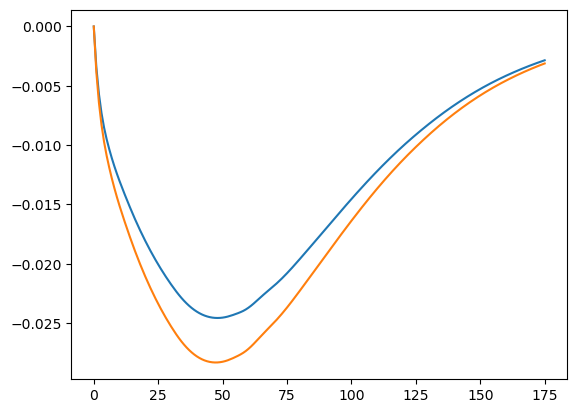

In [212]:
plt.plot(signal_basis.basis[0]*(fitter2.parameter_mean[1]+np.sqrt(5))+signal_basis.basis[1]*(fitter2.parameter_mean[2]+np.sqrt(1)))
plt.plot(signal_basis.basis[0]*(fitter2.parameter_mean[1]-np.sqrt(5))+signal_basis.basis[1]*(fitter2.parameter_mean[2]+np.sqrt(1)))

In [214]:
((signal_basis.basis[0]*(fitter2.parameter_mean[1]-np.sqrt(5))+signal_basis.basis[1]*(fitter2.parameter_mean[2]-np.sqrt(1)))-fitter2.subbasis_channel_mean("Signal"))[43]

-0.0032552217095028133

In [191]:
signal_basis.basis/noise_level**2

array([[-2.80061167e-15,  2.03707674e-03,  4.39215708e-03, ...,
         4.58261250e+01,  4.58005393e+01,  4.57604283e+01],
       [ 3.05405244e-17, -1.64497637e-04,  1.72122960e-03, ...,
        -1.02792160e+02, -1.04054394e+02, -1.05262744e+02],
       [ 6.93833993e-14, -1.38004551e-03, -2.96685313e-03, ...,
         9.70492764e+00,  5.14120108e+00,  2.91979715e-01],
       ...,
       [ 3.20131665e-10,  3.49521001e-03, -7.15731491e-03, ...,
        -1.34945527e+01, -1.73258322e+01, -2.15348005e+01],
       [-4.15029663e-11,  1.41966758e-03, -1.28628800e-02, ...,
         4.14382871e+01,  4.79261149e+01,  5.47805335e+01],
       [ 1.66818886e-10, -3.63212049e-03,  1.53345205e-02, ...,
        -3.66227516e+01, -4.43455948e+01, -5.21992724e+01]])

## Bias (Going to Need to Cook)


In [5]:
# # # This creates your 100 random beam-weighted foregrounds
# custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
# parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground

# # signal_model = signal_model_set[signal][Nsim*i+nsim]

# ## Interpolate the varied beams to match the rest of the data
# varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
# for n in range(len(varied_regolith_training_set_raw)):
#     beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
#     varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
# Nb = 10 # number of beams in the beam training set
# exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
#                             custom_parameter_range,show_parameter_ranges=False)

# BTS_curves = exp_test[0]
# BTS_params = exp_test[1]
# beam_sky_training_set = beams[:,5:,:]
# beam_sky_training_set_params = varied_regolith_training_set_raw_params
# raw_beam_weighted_sky_maps = raw_sky_maps
# Nfg = 10
# determine_parameter_range = True
# new_FG_parameter_mean = None
# foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
#                                     beam_sky_training_set,beam_sky_training_set_params,Nfg,parameter_variation, B_value_functions,\
#                                         define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)

# # plots the 100 random bwfg
# for n in range(100):
#     plt.plot((foreground_run[3][n]-simulation_test_beam[0])/simulation_test_beam[0])

# new_parameter_mean = np.zeros((n_regions,3))
# fg_range_array_random_10 = np.zeros((n_regions,6))
# foreground_parameter_variation = np.array(parameter_variation)
# for r in range(n_regions):
#     new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
#     # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
#     fg_range_array_random_10[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
#     fg_range_array_random_10[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
#     fg_range_array_random_10[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
#     fg_range_array_random_10[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
#     fg_range_array_random_10[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
#     fg_range_array_random_10[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


###This creates a training set for each of the randomly created beam-weighted foregrounds

# HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","w")
# hdf5.create_dataset("beam_weighted_curves",data=foreground_run[3])
# hdf5.create_dataset("beam_weighted_parameters",data=foreground_run[4])
# hdf5.close()
# # End of HDF5 data saving
# Nb = 10
# Nfg=10
# # ## HDF5 loading of 100 bw foreground
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","r")
curves_100 = hdf5["beam_weighted_curves"]
curves_100_params = hdf5["beam_weighted_parameters"]
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","r")
curves_100 = hdf5["beam_weighted_curves"]
curves_100_params = hdf5["beam_weighted_parameters"]
# when we made curves 100, we were willing to do 100 foregrounds, but now I realize that takes too much data
curves_10 = curves_100[[0,11,22,33,44,55,66,77,88,99]]  
curves_10_params = curves_100_params[[0,11,22,33,44,55,66,77,88,99]]  
# ## HDF5 loading end

# custom_parameter_range = np.array([[0.999975,1.000025],[3.39999,3.40001],[4.59999,4.60001]])  # For making a random foreground
# custom_parameter_range_variation = [0.000025, 0.00001,0.00001]
# parameter_variation = [0.0000005,0.00000025,0.0000005]  

# custom_parameter_range_array = np.zeros((Nb,3,2))
# foreground_means = np.zeros((Nfg,n_regions,3))
# for n in range(Nfg):
#     for r in range(n_regions):
#         foreground_means[n][r] = curves_10_params[n][r*3:r*3+3]

# for n in range(Nb):
#     custom_parameter_range_array[n]=[[curves_100_params[n][15]-curves_100_params[n][15]*custom_parameter_range_variation[0],curves_100_params[n][15]+curves_100_params[n][15]*custom_parameter_range_variation[0]],\
#                                 [curves_100_params[n][16]-curves_100_params[n][16]*custom_parameter_range_variation[1],curves_100_params[n][16]+curves_100_params[n][16]*custom_parameter_range_variation[1]],\
#                                 [curves_100_params[n][17]-curves_100_params[n][17]*custom_parameter_range_variation[2],curves_100_params[n][17]+curves_100_params[n][16]*custom_parameter_range_variation[2]]]

# dt = 10000*3600  # integration time
# N = 100000  # number of curves in the training set
# curves_10_training_sets = np.zeros((len(curves_10),N,len(frequencies)))
# curves_10_training_set_parameters = np.zeros((len(curves_10),N,len(foreground_run[4][0])))

# for nb,beam_params in enumerate(custom_parameter_range_array):
#     for nfg,mean in enumerate(foreground_means):
# ## Creates a foreground for the simulation:

#     # For making a random foreground

#     ## Interpolate the varied beams to match the rest of the data
#         custom_parameter_range = beam_params
#         parameter_variation = [0.0000005,0.00000025,0.0000005] 
#         varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
#         for n in range(len(varied_regolith_training_set_raw)):
#             beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
#             varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
#         Nb = int(np.sqrt(N)) # number of beams in the beam training set
#         exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
#                                     custom_parameter_range,show_parameter_ranges=False)

#         BTS_curves = exp_test[0]
#         BTS_params = exp_test[1]
#         beam_sky_training_set = beams[:,5:,:]
#         beam_sky_training_set_params = varied_regolith_training_set_raw_params
#         raw_beam_weighted_sky_maps = raw_sky_maps
#         Nfg = int(np.sqrt(N))
#         determine_parameter_range = False
#         new_FG_parameter_mean = mean
#         foreground_run_ts = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
#                                             beam_sky_training_set,beam_sky_training_set_params,Nfg,parameter_variation, B_value_functions,\
#                                                 define_parameter_mean=True,parameter_mean=new_FG_parameter_mean)

        # new_parameter_mean = np.zeros((n_regions,3))
        # fg_range_array = np.zeros((n_regions,6))
        # foreground_parameter_variation = np.array(parameter_variation)
        # for r in range(n_regions):
        #     new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
        #     # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
        #     fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
        #     fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
        #     fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
        #     fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
        #     fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
        #     fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]

        # curves_10_training_sets[nfg+len(foreground_means)*nb] = foreground_run_ts[3]
        # curves_10_training_set_parameters[nfg+len(foreground_means)*nb] = foreground_run_ts[4]

# HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_10_sims_ts","w")
# hdf5.create_dataset("curves_training_set",data=curves_10_training_sets)
# hdf5.create_dataset("curves_training_set_parameters",data=curves_10_training_set_parameters)
# hdf5.close()
# End of HDF5 data saving

# HDF5 loading of 10 bw foreground training sets (10,000 curves each)
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_10_sims_ts","r")
# curves_10_training_sets = hdf5["curves_training_set"]
# curves_10_training_sets_parameters = hdf5["curves_training_set_parameters"]
# HDF5 loading end

# HDF5 loading of 10 bw foreground training sets (10,000 curves each)
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims_ts","r")
curves_100_training_sets = hdf5["curves_training_set"]
curves_100_training_sets_parameters = hdf5["curves_training_set_parameters"]
# HDF5 loading end

# Curves array is shaped as follows:
# one entry per signal model (1 fiducial + 5 exotic)
# one entry per varied simulation (Nsim)
# 5 entries for different data: 0: full simulation, 1: only the signal, 2: only the foreground, 3: only the noise, 4: simulation without noise
# then the frequency array

Nsim = 1000
signal_models = ["lambdaCDM","DMAN","DMD","EDE","ERB","MCDM"]
signal_model_set = {"lambdaCDM": lambdaCDM_training_set, "DMAN": DMAN_training_set, "DMD": DMD_training_set, "EDE": EDE_training_set, "ERB": ERB_training_set, "MCDM": MCDM_training_set}
signal_parameter_set = {"lambdaCDM": lambdaCDM_training_set_params, "DMAN": DMAN_training_set_params, "DMD": DMD_training_set_params, "EDE": EDE_training_set_params, "ERB": ERB_training_set_params, "MCDM": MCDM_training_set_params}
simulation_curves_array = np.zeros((Nsim*len(signal_models),5,len(frequencies))) 
simulation_parameters_array = {}

# these expanded curves make working with the signal models a bit easier
curves_100_expanded = curves_100
for n in range(9):   # NOT GENERAL only works because we have 100 times as many singal models as foreround models
        curves_100_expanded = np.concatenate((curves_100_expanded,curves_10),axis=0)

curves_100_params_expanded = curves_100_params
for n in range(9):   # NOT GENERAL only works because we have 100 times as many singal models as foreround models
        curves_100_params_expanded = np.concatenate((curves_100_params_expanded,curves_100_params),axis=0)

for i,signal in enumerate(signal_models): 
    for nsim,bwfg,par in zip(range(Nsim),curves_100_expanded,curves_100_params_expanded):
        signal_model = signal_model_set[signal][Nsim*i+nsim]
        foreground_for_sim = bwfg
        parameters_for_sim = par

# Our simulation function
        simulation_test_beam = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

        simulation_curves_array[Nsim*i+nsim][0] = simulation_test_beam[0]
        simulation_curves_array[Nsim*i+nsim][1] = simulation_test_beam[1]
        simulation_curves_array[Nsim*i+nsim][2] = simulation_test_beam[2]
        simulation_curves_array[Nsim*i+nsim][3] = simulation_test_beam[3]
        simulation_curves_array[Nsim*i+nsim][4] = simulation_test_beam[4]

        simulation_parameters_array[Nsim*i+nsim] = {"bwfg": parameters_for_sim, "signal": signal_parameter_set[signal][Nsim*i+nsim]}


Nsim_tot = len(simulation_curves_array)
bias_scores = np.zeros((Nsim_tot))

for n in tqdm(range (Nsim_tot)):
#### Pylinex Fit #####
        foreground_training_set_array = curves_100_training_sets[n % 100]  # this index convention only works if there are 10 foregrounds and some multiple of 100 signals (such as 1000)
        signal_model_number = n // 1000  # Only works when you have 1000 signals of the same model
        print(signal_model_number)
        model = signal_models[signal_model_number]
        sig_training_set = signal_model_set[model]
        IC = "DIC"
        sim = simulation_curves_array[n]
        sim_data = sim[0]
        true_curve = sim[1]
        noise_level = sigT(sim_data,dnu,dt)
        foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
        signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
        temperatures = sim_data
        basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
        quantity = AttributeQuantity(IC)
        dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
        # priors = {"Signal_prior" : signal_basis.gaussian_prior}
        meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
        fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
        num_foreground_terms = fitter2.sizes['Foreground']
        num_signal_terms = fitter2.sizes['Signal']
        bias_scores[n] = fitter2.subbasis_bias_statistic("Signal",true_curve,norm_by_dof=True)
        

        

        # print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
        # print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
        # print(f"{fitter2.subbasis_channel_mean("Signal").min()} Temperature of lowest point of the trough ")
        # print(f"{fitter2.subbasis_channel_error("Signal")[np.where(fitter2.subbasis_channel_mean("Signal")==fitter2.subbasis_channel_mean("Signal").min())][0]} Channel error at lowest point of the trough ")
        # # print(f"{fitter2.log_evidence} log evidence")
        # print(f"{fitter2.chi_squared} Chi Squared")
        # print(f"{fitter2.psi_squared} Psi Squared")
        # pearsonr=scipy.stats.pearsonr(fitter2.subbasis_channel_mean("Signal")/simulation_test_beam[2],(fitter2.subbasis_channel_mean("Foreground")-simulation_test_beam[2])/simulation_test_beam[2])
        # print(f"True {pearsonr}")

        plt.figure(figsize=(10, 5))
        plt.plot(frequencies, fitter2.subbasis_channel_mean("Signal"),label = "fit mean", c="red")
        plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Signal")+fitter2.subbasis_channel_error("Signal"),fitter2.subbasis_channel_mean("Signal")-fitter2.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="red")
        plt.title("Signal Fit",fontsize=20)
        plt.xlabel("Frequency [MHz]",fontsize="15")
        plt.ylabel("Temperature [K]",fontsize="15")
        plt.text(17, -0.01, f'fit mean = {fitter2.subbasis_channel_mean("Signal")[43]:.2f} K', ha='center', va='bottom', fontsize=15)
        plt.text(17.3, -0.015, f'fit error = {fitter2.subbasis_channel_error("Signal")[43]:.4f} K', ha='center', va='bottom', fontsize=15)
        plt.plot(frequencies,sim[1],label="input signal",c="black")
        plt.legend()
        # plt.savefig(save_path+"Example_extraction")


TypeError: simulation_run() missing 1 required positional argument: 'dt'

In [ ]:
### this is a separate cell for running the 5mil single fg training set.

# # This creates your 100 random beam-weighted foregrounds
# custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
# parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground

# # signal_model = signal_model_set[signal][Nsim*i+nsim]

# ## Interpolate the varied beams to match the rest of the data
# varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
# for n in range(len(varied_regolith_training_set_raw)):
#     beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
#     varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
# Nb = 10 # number of beams in the beam training set
# exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
#                             custom_parameter_range,show_parameter_ranges=False)

# BTS_curves = exp_test[0]
# BTS_params = exp_test[1]
# beam_sky_training_set = beams[:,5:,:]
# beam_sky_training_set_params = varied_regolith_training_set_raw_params
# raw_beam_weighted_sky_maps = raw_sky_maps
# Nfg = 10
# determine_parameter_range = True
# new_FG_parameter_mean = None
# foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
#                                     beam_sky_training_set,beam_sky_training_set_params,Nfg,parameter_variation, B_value_functions,\
#                                         define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)

# # plots the 100 random bwfg
# for n in range(100):
#     plt.plot((foreground_run[3][n]-simulation_test_beam[0])/simulation_test_beam[0])

# new_parameter_mean = np.zeros((n_regions,3))
# fg_range_array_random_10 = np.zeros((n_regions,6))
# foreground_parameter_variation = np.array(parameter_variation)
# for r in range(n_regions):
#     new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
#     # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
#     fg_range_array_random_10[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
#     fg_range_array_random_10[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
#     fg_range_array_random_10[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
#     fg_range_array_random_10[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
#     fg_range_array_random_10[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
#     fg_range_array_random_10[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]


###This creates a training set for each of the randomly created beam-weighted foregrounds

# HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","w")
# hdf5.create_dataset("beam_weighted_curves",data=foreground_run[3])
# hdf5.create_dataset("beam_weighted_parameters",data=foreground_run[4])
# hdf5.close()
# # End of HDF5 data saving
# Nb = 10
# Nfg=10
# # # # ## HDF5 loading of 100 bw foreground
# # # hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","r")
# # # curves_100 = hdf5["beam_weighted_curves"]
# # # curves_100_params = hdf5["beam_weighted_parameters"]
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","r")
# curves_100 = hdf5["beam_weighted_curves"]
# curves_100_params = hdf5["beam_weighted_parameters"]
# # when we made curves 100, we were willing to do 100 foregrounds, but now I realize that takes too much data
# # curves_10 = curves_100[[0,11,22,33,44,55,66,77,88,99]]  
# # curves_10_params = curves_100_params[[0,11,22,33,44,55,66,77,88,99]]  
# ## HDF5 loading end

# custom_parameter_range = np.array([[0.999975,1.000025],[3.39999,3.40001],[4.59999,4.60001]])  # For making a random foreground
# custom_parameter_range_variation = [0.000025, 0.00001,0.00001]
# parameter_variation = [0.0000005,0.00000025,0.0000005]  

# custom_parameter_range_array = np.zeros((Nb,3,2))
# foreground_means = np.zeros((Nfg,n_regions,3))
# for n in range(Nfg):
#     for r in range(n_regions):
#         foreground_means[n][r] = curves_100_params[n][r*3:r*3+3]

# for n in range(Nb):
#     custom_parameter_range_array[n]=[[curves_100_params[n*10][15]-curves_100_params[n*10][15]*custom_parameter_range_variation[0],curves_100_params[n*10][15]+curves_100_params[n*10][15]*custom_parameter_range_variation[0]],\
#                                 [curves_100_params[n*10][16]-curves_100_params[n*10][16]*custom_parameter_range_variation[1],curves_100_params[n*10][16]+curves_100_params[n*10][16]*custom_parameter_range_variation[1]],\
#                                 [curves_100_params[n*10][17]-curves_100_params[n*10][17]*custom_parameter_range_variation[2],curves_100_params[n*10][17]+curves_100_params[n*10][16]*custom_parameter_range_variation[2]]]

# dt = 10000*3600  # integration time
# N = 100000  # number of curves in the training set
# Nb = int(np.sqrt(N))
# Nfg = int(np.sqrt(N))
# curves_100_training_sets = np.zeros((len(curves_100),Nfg*Nb,len(frequencies)))
# curves_100_training_set_parameters = np.zeros((len(curves_100),Nfg*Nb,len(foreground_run[4][0])))

# for nb,beam_params in enumerate(custom_parameter_range_array):
#     for nfg,mean in enumerate(foreground_means):
# ## Creates a foreground for the simulation:

#     # For making a random foreground

#     ## Interpolate the varied beams to match the rest of the data
#         custom_parameter_range = beam_params
#         parameter_variation = [0.0000005,0.00000025,0.0000005] 
#         varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
#         for n in range(len(varied_regolith_training_set_raw)):
#             beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
#             varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
#         Nb = int(np.sqrt(N)) # number of beams in the beam training set
#         exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
#                                     custom_parameter_range,show_parameter_ranges=False)

#         BTS_curves = exp_test[0]
#         BTS_params = exp_test[1]
#         beam_sky_training_set = beams[:,5:,:]
#         beam_sky_training_set_params = varied_regolith_training_set_raw_params
#         raw_beam_weighted_sky_maps = raw_sky_maps
#         Nfg = int(np.sqrt(N))
#         determine_parameter_range = False
#         new_FG_parameter_mean = mean
#         foreground_run_ts = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
#                                             beam_sky_training_set,beam_sky_training_set_params,Nfg,parameter_variation, B_value_functions,\
#                                                 define_parameter_mean=True,parameter_mean=new_FG_parameter_mean)

#         new_parameter_mean = np.zeros((n_regions,3))
#         fg_range_array = np.zeros((n_regions,6))
#         foreground_parameter_variation = np.array(parameter_variation)
#         for r in range(n_regions):
#             new_parameter_mean[r] = foreground_run[0].flatten()[3*r:3*(r+1)]
#             # populates an array that displays the range of values the the foreground parameters. Useful to see how well the annealing is doing
#             fg_range_array[r][0] = new_parameter_mean[r][0] - new_parameter_mean[r][0]*foreground_parameter_variation[0]
#             fg_range_array[r][1] = new_parameter_mean[r][0] + new_parameter_mean[r][0]*foreground_parameter_variation[0]
#             fg_range_array[r][2] = new_parameter_mean[r][1] - new_parameter_mean[r][1]*foreground_parameter_variation[1]
#             fg_range_array[r][3] = new_parameter_mean[r][1] + new_parameter_mean[r][1]*foreground_parameter_variation[1]
#             fg_range_array[r][4] = new_parameter_mean[r][2] - new_parameter_mean[r][2]*foreground_parameter_variation[2]
#             fg_range_array[r][5] = new_parameter_mean[r][2] + new_parameter_mean[r][2]*foreground_parameter_variation[2]

#         curves_100_training_sets[nfg+len(foreground_means)*nb] = foreground_run_ts[3]
#         curves_100_training_set_parameters[nfg+len(foreground_means)*nb] = foreground_run_ts[4]

# # HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims_ts_100000","w")
# hdf5.create_dataset("curves_training_set",data=curves_100_training_sets)
# hdf5.create_dataset("curves_training_set_parameters",data=curves_100_training_set_parameters)
# hdf5.close()
# # End of HDF5 data saving

# HDF5 loading of 10 bw foreground training sets (10,000 curves each)
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_10_sims_ts","r")
# curves_10_training_sets = hdf5["curves_training_set"]
# curves_10_training_sets_parameters = hdf5["curves_training_set_parameters"]
# HDF5 loading end
bias_function = lambda frequencies,model_curve, fit_curve, noise: np.sqrt(1/len(frequencies)*(((model_curve-fit_curve)**2)/noise**2).sum())
# HDF5 loading of 1 bw foreground training sets (5mil curves each)
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_single_sims_ts_5mil","r")
curves_100_training_sets = hdf5["curves_training_set"]
curves_100_training_sets_parameters = hdf5["curves_training_set_parameters"]
# HDF5 loading end

#foreground_basis = TrainedBasis(training_set=curves_100_training_sets, num_basis_vectors=100,error=noise_level)  #uncomment this when you are starting the notebook. It probably will crash the kernel though. Best to do it in a separate cell

# # HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/trained_basis_5mil","w")
# hdf5.create_dataset("foreground_basis",data=foreground_basis)
# hdf5.close()
# # End of HDF5 data saving

# Curves array is shaped as follows:
# one entry per signal model (1 fiducial + 5 exotic)
# one entry per varied simulation (Nsim)
# 5 entries for different data: 0: full simulation, 1: only the signal, 2: only the foreground, 3: only the noise, 4: simulation without noise
# then the frequency array

Nsim = 1000
signal_models = ["lambdaCDM","DMAN","DMD","EDE","ERB","MCDM"]
signal_model_set = {"lambdaCDM": lambdaCDM_training_set, "DMAN": DMAN_training_set, "DMD": DMD_training_set, "EDE": EDE_training_set, "ERB": ERB_training_set, "MCDM": MCDM_training_set}
signal_parameter_set = {"lambdaCDM": lambdaCDM_training_set_params, "DMAN": DMAN_training_set_params, "DMD": DMD_training_set_params, "EDE": EDE_training_set_params, "ERB": ERB_training_set_params, "MCDM": MCDM_training_set_params}
simulation_curves_array = np.zeros((Nsim*len(signal_models),5,len(frequencies))) 
simulation_parameters_array = {}

Nb = 10
Nfg=10
# # # ## HDF5 loading of 100 bw foreground
# # hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","r")
# # curves_100 = hdf5["beam_weighted_curves"]
# # curves_100_params = hdf5["beam_weighted_parameters"]
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","r")
curves_100 = hdf5["beam_weighted_curves"]
curves_100_params = hdf5["beam_weighted_parameters"]

noise_level = sigT(curves_100[0],dnu,dt)

hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_single_sims_ts_5mil","r")
curves_100_training_sets = hdf5["curves_training_set"]
curves_100_training_sets_parameters = hdf5["curves_training_set_parameters"]
# HDF5 loading end

# foreground_basis = TrainedBasis(training_set=curves_100_training_sets, num_basis_vectors=100,error=noise_level)

# # these expanded curves make working with the signal models a bit easier
# curves_100_expanded = curves_100
# for n in range(9):   # NOT GENERAL only works because we have 100 times as many singal models as foreround models
#         curves_100_expanded = np.concatenate((curves_100_expanded,curves_100),axis=0)

# curves_100_params_expanded = curves_100_params
# for n in range(9):   # NOT GENERAL only works because we have 100 times as many singal models as foreround models
#         curves_100_params_expanded = np.concatenate((curves_100_params_expanded,curves_100_params),axis=0)

foreground_for_sim = curves_100[0]
parameters_for_sim = curves_100_params[0]
for i,signal in enumerate(signal_models): 
    bwfg = curves_100[0]
    par = curves_100_params[0]
    for nsim in range(Nsim):
        signal_model = signal_model_set[signal][Nsim*i+nsim]

# Our simulation function
        simulation_test_beam = py21cmsig.simulation_run(foreground_for_sim,signal_model,dnu,dt)

        simulation_curves_array[Nsim*i+nsim][0] = simulation_test_beam[0]
        simulation_curves_array[Nsim*i+nsim][1] = simulation_test_beam[1]
        simulation_curves_array[Nsim*i+nsim][2] = simulation_test_beam[2]
        simulation_curves_array[Nsim*i+nsim][3] = simulation_test_beam[3]
        simulation_curves_array[Nsim*i+nsim][4] = simulation_test_beam[4]

        simulation_parameters_array[Nsim*i+nsim] = {"bwfg": parameters_for_sim, "signal": signal_parameter_set[signal][Nsim*i+nsim]}


Nsim_tot = len(simulation_curves_array)
bias_scores = np.zeros((len(signal_models),Nsim))

for si,s in enumerate(signal_models):
        for n in tqdm(range (Nsim)):

#### Pylinex Fit #####
                signal_model_number = s  # Only works when you have 1000 signals of the same model
                model = s
                print(model)
                sig_training_set = signal_model_set[model]
                IC = "DIC"
                sim = simulation_curves_array[n+Nsim*si]
                sim_data = sim[0]
                true_curve = sim[1]
                noise_level = sigT(sim_data,dnu,dt)
                signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
                temperatures = sim_data
                basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
                quantity = AttributeQuantity(IC)
                dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
                # priors = {"Signal_prior" : signal_basis.gaussian_prior}
                meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
                fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
                num_foreground_terms = fitter2.sizes['Foreground']
                num_signal_terms = fitter2.sizes['Signal']
                print(f"foreground_terms = {num_foreground_terms}")
                print(f"signal_terms = {num_signal_terms}")
                # only works for our specific frequency range right now, but I'm in a rush so sue me.
                bias_statistic = bias_function (frequencies[10:150],sim[1][10:150],fitter2.subbasis_channel_mean("Signal")[10:150],\
                                                    fitter2.subbasis_channel_error("Signal")[10:150])
                bias_scores[si][n] = bias_statistic
                print(bias_statistic)

        
# # HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/bias_scores_5mil_1fg","w")
# hdf5.create_dataset("bias_scores",data=bias_scores)
# hdf5.close()
# End of HDF5 data saving

# HDF5 loading of 10 bw foreground training sets (10,000 curves each)
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/bias_scores_5mil_1fg","r")
bias_scores = hdf5["bias_scores"]
# HDF5 loading end
        

        # print(f'The MetaFitter chose %i foreground terms based on {IC} minimization.' % num_foreground_terms)
        # print(f'The MetaFitter chose %i signal terms based on {IC} minimization.' % num_signal_terms)
        # print(f"{fitter2.subbasis_channel_mean("Signal").min()} Temperature of lowest point of the trough ")
        # print(f"{fitter2.subbasis_channel_error("Signal")[np.where(fitter2.subbasis_channel_mean("Signal")==fitter2.subbasis_channel_mean("Signal").min())][0]} Channel error at lowest point of the trough ")
        # # print(f"{fitter2.log_evidence} log evidence")
        # print(f"{fitter2.chi_squared} Chi Squared")
        # print(f"{fitter2.psi_squared} Psi Squared")
        # pearsonr=scipy.stats.pearsonr(fitter2.subbasis_channel_mean("Signal")/simulation_test_beam[2],(fitter2.subbasis_channel_mean("Foreground")-simulation_test_beam[2])/simulation_test_beam[2])
        # print(f"True {pearsonr}")

                # plt.figure(figsize=(10, 5))
                # plt.plot(frequencies, fitter2.subbasis_channel_mean("Signal"),label = "fit mean", c="red")
                # plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Signal")+fitter2.subbasis_channel_error("Signal"),fitter2.subbasis_channel_mean("Signal")-fitter2.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="red")
                # plt.title("Signal Fit",fontsize=20)
                # plt.xlabel("Frequency [MHz]",fontsize="15")
                # plt.ylabel("Temperature [K]",fontsize="15")
                # plt.text(17, -0.01, f'fit mean = {fitter2.subbasis_channel_mean("Signal")[43]:.2f} K', ha='center', va='bottom', fontsize=15)
                # plt.text(17.3, -0.015, f'fit error = {fitter2.subbasis_channel_error("Signal")[43]:.4f} K', ha='center', va='bottom', fontsize=15)
                # plt.plot(frequencies,sim[1],label="input signal",c="black")
                # plt.legend()
                # plt.show()
        # plt.savefig(save_path+"Example_extraction")


In [ ]:
#["lambdaCDM","DMAN","DMD","EDE","ERB","MCDM"]  # order of the bias_score index
plt.figure(figsize=(8*1.5, 5*1.5))

a = 1

# lambda_CDM
CDM_data = bias_scores[0]
data = CDM_data
data.sort()
data_std=data.std()
data_mean=data.mean()
data_range = np.arange(data.min(),data.max(),(data.max()-data.min())/len(data))
data_CDF_values = np.arange(1, len(data) + 1) / len(data)
plt.plot(data, data_CDF_values,label = "lambda CDM", c="darkred",alpha = a)

# DMAN

DMAN_data = bias_scores[1]
data = DMAN_data
data.sort()
data_std=data.std()
data_mean=data.mean()
data_range = np.arange(data.min(),data.max(),(data.max()-data.min())/len(data))
data_CDF_values = np.arange(1, len(data) + 1) / len(data)
plt.plot(data, data_CDF_values,label = "Dark Matter Self-Annihilation", c="darkorange",alpha = a)

# DMD

DMD_data = bias_scores[2]
data = DMD_data
data.sort()
data_std=data.std()
data_mean=data.mean()
data_range = np.arange(data.min(),data.max(),(data.max()-data.min())/len(data))
data_CDF_values = np.arange(1, len(data) + 1) / len(data)
plt.plot(data, data_CDF_values,label = "Dark Matter Decay", c="darkgreen",alpha = a)

# EDE

EDE_data = bias_scores[3]
data = EDE_data
data.sort()
data_std=data.std()
data_mean=data.mean()
data_range = np.arange(data.min(),data.max(),(data.max()-data.min())/len(data))
data_CDF_values = np.arange(1, len(data) + 1) / len(data)
plt.plot(data, data_CDF_values,label = "Early Dark Energy", c="purple",alpha = a)

# ERB

ERB_data = bias_scores[4]
data = ERB_data
data.sort()
data_std=data.std()
data_mean=data.mean()
data_range = np.arange(data.min(),data.max(),(data.max()-data.min())/len(data))
data_CDF_values = np.arange(1, len(data) + 1) / len(data)
plt.plot(data, data_CDF_values,label = "Excess Radio Background", c="black",alpha = a)

# MCDM

MCDM_data = bias_scores[5]
data = MCDM_data
data.sort()
data_std=data.std()
data_mean=data.mean()
data_range = np.arange(data.min(),data.max(),(data.max()-data.min())/len(data))
data_CDF_values = np.arange(1, len(data) + 1) / len(data)
plt.plot(data, data_CDF_values,label = "Baryon-Dark Matter Interaction", c="darkblue",alpha = a)

# Expected CDF
x=range(0,5)
y=scipy.stats.norm.cdf(np.arange(0,5))*2-1
interp=scipy.interpolate.CubicSpline(x,y)
plt.plot(np.arange(0,3.8,0.001),interp(np.arange(0,3.8,0.001)) ,label = "Expected Normal Distribution", c="black", ls=":")

# plt.axhline(0.68,ls="--",c="black",label="68%")
# plt.axhline(0.95,ls=":",c="black",label="95%")
# plt.axhline(0.998,ls="-.",c="black",label="99.8%")
plt.title("Bias for Each Signal Model",fontsize=20)
plt.xlabel("Bias Statistic",fontsize="15")
plt.ylabel("Cumulative Probability",fontsize="15")
plt.xlim(-0.2,5)
# plt.text(17, -0.01, f'fit mean = {fitter2.subbasis_channel_mean("Signal")[43]:.2f} K', ha='center', va='bottom', fontsize=15)
# plt.text(17.3, -0.015, f'fit error = {fitter2.subbasis_channel_error("Signal")[43]:.4f} K', ha='center', va='bottom', fontsize=15)
# plt.plot(frequencies,simulation_test_beam[1],label="input signal",c="black")
plt.legend()
plt.savefig(save_path+"Bias_statistic")



### some useful troubleshooting graphs
# N = 99
# for n in range(10000):
#     plt.plot((curves_100_training_sets[N][n]-curves_100[N])/curves_100[N])

# plt.figure(figsize=(10, 5))
# plt.plot(frequencies, fitter2.subbasis_channel_mean("Signal"),label = "fit mean", c="red")
# plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Signal")+fitter2.subbasis_channel_error("Signal"),fitter2.subbasis_channel_mean("Signal")-fitter2.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="red")
# plt.title("Signal Fit",fontsize=20)
# plt.xlabel("Frequency [MHz]",fontsize="15")
# plt.ylabel("Temperature [K]",fontsize="15")
# plt.text(17, -0.01, f'fit mean = {fitter2.subbasis_channel_mean("Signal")[43]:.2f} K', ha='center', va='bottom', fontsize=15)
# plt.text(17.3, -0.015, f'fit error = {fitter2.subbasis_channel_error("Signal")[43]:.4f} K', ha='center', va='bottom', fontsize=15)
# plt.plot(frequencies,sim[1],label="input signal",c="black")
# plt.legend()
# plt.savefig(save_path+"Example_extraction")

# h=60
# for n in range(100):
#     plt.plot((curves_100_training_sets[h][n]-curves_100[1])/curves_100[1])
# plt.plot(sigT(curves_100[h],dnu,dt)/curves_100[h]*10)
# plt.plot(-sigT(curves_100[h],dnu,dt)/curves_100[h]*10)

# K-S test

In [6]:
bias_scores[0:93]

array([1.1570396 , 6.67617165, 1.44585309, 0.62785501, 0.98783616,
              nan, 0.70903775, 1.02160672, 1.88511995, 2.05686161,
       0.32773023, 1.3130067 , 0.26848608, 1.11945564, 1.59055306,
              inf,        nan, 2.28449359, 0.73230565, 1.26539487,
       0.36356642, 0.46821773, 5.36207597,        nan, 1.06412887,
       1.37734548, 0.92013636, 0.24397832, 2.25284089, 6.97142457,
       1.09532329, 1.03168416, 2.34024657, 0.25749415, 1.62505064,
       2.3407135 ,        inf, 1.24384215, 0.96362815, 9.9311097 ,
       0.3391071 , 4.53666387, 2.03085031, 1.52707351, 2.02500995,
       2.5421141 , 0.41749648, 0.54735821, 2.34327023, 1.60078861,
       0.99696703, 1.0031328 , 1.70366542, 1.45329842,        inf,
              inf, 1.33222995, 0.33915587,        nan, 2.88114909,
       0.26749755, 2.91045328, 2.38680362, 7.51600259, 0.40169822,
       9.2600588 , 0.28398846, 1.69465921, 0.85567971, 0.36787865,
       1.77706294, 1.45473941, 0.4373503 , 8.61680206, 1.15020

In [11]:
for n in range(1000):
    plt.plot(curves_10_training_sets[0]-curves_10[0])

: 

In [9]:
2939 % 10

9

In [644]:
bias_scores

array([nan,  0.,  0., ...,  0.,  0.,  0.])

In [642]:
bias_scores

array([3.27084218e+00, 4.35423388e+07, 1.56059335e+07, 2.41592720e+07,
       1.20316159e+06, 8.60395319e+06, 7.19076513e+06, 3.74423393e+06,
       2.55796841e+06, 4.08283825e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [550]:
5879 % 10

9

In [543]:
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","r")
curves_100 = hdf5["beam_weighted_curves"]
curves_100_params = hdf5["beam_weighted_parameters"]
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims","r")
curves_100 = hdf5["beam_weighted_curves"]
curves_100_params = hdf5["beam_weighted_parameters"]
# when we made curves 100, we were willing to do 100 foregrounds, but now I realize that takes too much data
curves_10 = curves_100[[0,11,22,33,44,55,66,77,88,99]]  
curves_10_params = curves_100_params[[0,11,22,33,44,55,66,77,88,99]]  

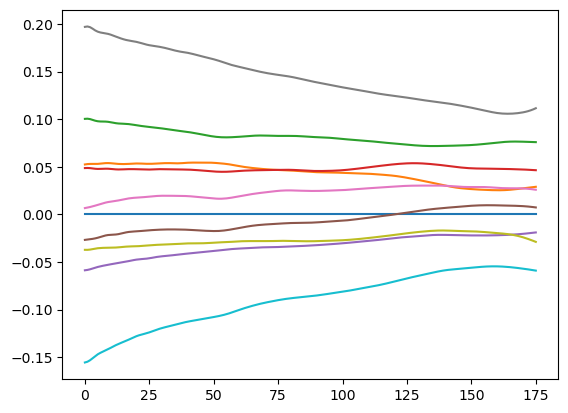

In [542]:
for n in range (10):
    plt.plot((curves_10[n]-curves_100[0])/curves_100[0])

In [107]:
# fitter2.subbasis_channel_bias("Signal",true_curve)
fitter2.subbasis_bias_statistic("Signal",true_curve)

126797149350641.11

In [16]:
# cleans the nans from the bias scores. No idea why the nans show up in the first place, but whatever.
bias_scores[0:93]

data = bias_scores[0:93]
clean_bias = data[~np.isnan(data)]
super_clean_bias = clean_bias[~np.isinf(clean_bias)] # Keep only finite values


In [17]:
CDM_data.shape

(8,)

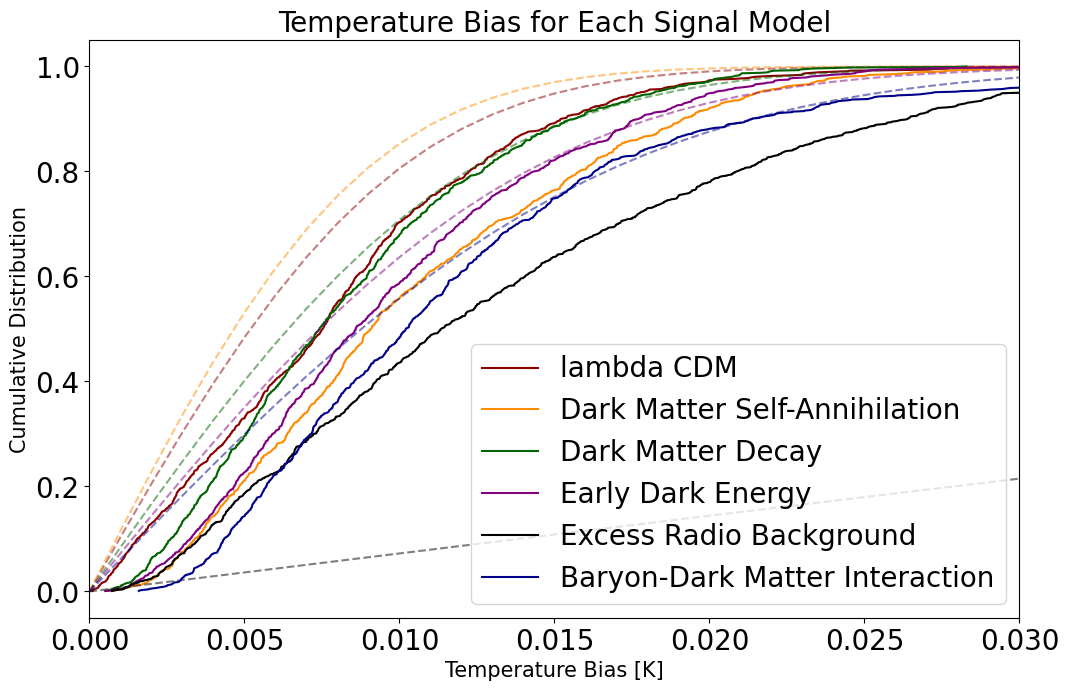

In [300]:

# HDF5 loading of 10 bw foreground training sets (10,000 curves each)
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/bias_scores_5mil_1fg","r")
bias_scores = hdf5["bias_scores"]
C_k = np.sqrt(((fitter.subbasis_channel_error("Signal")**2).sum())/len(frequencies)) # conversion to Kelvin
# HDF5 loading end
#["lambdaCDM","DMAN","DMD","EDE","ERB","MCDM"]  # order of the bias_score index
plt.figure(figsize=(8*1.5, 5*1.5))

a = 1
b=0.5

# lambda_CDM
CDM_data2 = bias_scores[0]*C_k
data = CDM_data2
data.sort()
data_std=data.std()
data_mean=data.mean()
data_range = np.arange(data.min(),data.max(),(data.max()-data.min())/len(data))
data_CDF_values = np.arange(1, len(data) + 1) / len(data)
plt.plot(data, data_CDF_values,label = "lambda CDM", c="darkred",alpha = a)

x=np.arange(0,0.05,0.001)
cdf_values = scipy.stats.norm.cdf(x, loc=0, scale=0.0077)*2-1

# Plotting the CDF
plt.plot(x, cdf_values,color="darkred",ls="--",alpha=b)

# DMAN

DMAN_data2 = bias_scores[1]*C_k
data = DMAN_data2
data.sort()
data_std=data.std()
data_mean=data.mean()
data_range = np.arange(data.min(),data.max(),(data.max()-data.min())/len(data))
data_CDF_values = np.arange(1, len(data) + 1) / len(data)
plt.plot(data, data_CDF_values,label = "Dark Matter Self-Annihilation", c="darkorange",alpha = a)

x=np.arange(0,0.05,0.001)
cdf_values = scipy.stats.norm.cdf(x, loc=0, scale=0.0069)*2-1

# Plotting the CDF
plt.plot(x, cdf_values,color="darkorange",ls="--",alpha=b)

# DMD

DMD_data2 = bias_scores[2]*C_k
data = DMD_data2
data.sort()
data_std=data.std()
data_mean=data.mean()
data_range = np.arange(data.min(),data.max(),(data.max()-data.min())/len(data))
data_CDF_values = np.arange(1, len(data) + 1) / len(data)
plt.plot(data, data_CDF_values,label = "Dark Matter Decay", c="darkgreen",alpha = a)

x=np.arange(0,0.05,0.001)
cdf_values = scipy.stats.norm.cdf(x, loc=0, scale=0.0095)*2-1

# Plotting the CDF
plt.plot(x, cdf_values,color="darkgreen",ls="--",alpha=b)

# EDE

EDE_data2 = bias_scores[3]*C_k
data = EDE_data2
data.sort()
data_std=data.std()
data_mean=data.mean()
data_range = np.arange(data.min(),data.max(),(data.max()-data.min())/len(data))
data_CDF_values = np.arange(1, len(data) + 1) / len(data)
plt.plot(data, data_CDF_values,label = "Early Dark Energy", c="purple",alpha = a)

x=np.arange(0,0.05,0.001)
cdf_values = scipy.stats.norm.cdf(x, loc=0, scale=0.011)*2-1

# Plotting the CDF
plt.plot(x, cdf_values,color="purple",ls="--",alpha=b)

# ERB

ERB_data2 = bias_scores[4]*C_k
data = ERB_data2
data.sort()
data_std=data.std()
data_mean=data.mean()
data_range = np.arange(data.min(),data.max(),(data.max()-data.min())/len(data))
data_CDF_values = np.arange(1, len(data) + 1) / len(data)
plt.plot(data, data_CDF_values,label = "Excess Radio Background", c="black",alpha = a)

x=np.arange(0,0.05,0.001)
cdf_values = scipy.stats.norm.cdf(x, loc=0, scale=0.11)*2-1

# Plotting the CDF
plt.plot(x, cdf_values,color="black",ls="--",alpha=b)

# MCDM

MCDM_data2 = bias_scores[5]*C_k
data = MCDM_data2
data.sort()
data_std=data.std()
data_mean=data.mean()
data_range = np.arange(data.min(),data.max(),(data.max()-data.min())/len(data))
data_CDF_values = np.arange(1, len(data) + 1) / len(data)
plt.plot(data, data_CDF_values,label = "Baryon-Dark Matter Interaction", c="darkblue",alpha = a)

x=np.arange(0,0.05,0.001)
cdf_values = scipy.stats.norm.cdf(x, loc=0, scale=0.013)*2-1

# Plotting the CDF
plt.plot(x, cdf_values,color="darkblue",ls="--",alpha=b)

# # Expected CDF
# x=np.arange(0,0.05,0.001)
# cdf_values = scipy.stats.norm.cdf(x, loc=0, scale=0.0077)*2-1

# # Plotting the CDF
# plt.plot(x, cdf_values)
# plt.grid(True)

# x=np.arange(0,0.05,0.01)
# y=scipy.stats.norm.cdf(np.arange(0,0.05,0.01))*2-1
# interp=scipy.interpolate.CubicSpline(x,y)
# plt.plot(np.arange(0,0.05,0.001),interp(np.arange(0,0.05,0.001)) ,label = "Expected Normal Distribution", c="black", ls=":")

# plt.axhline(0.68,ls="--",c="black",label="68%")
# plt.axhline(0.95,ls=":",c="black",label="95%")
# plt.axhline(0.998,ls="-.",c="black",label="99.8%")
plt.title("Temperature Bias for Each Signal Model",fontsize=20)
plt.xlabel("Temperature Bias [K]",fontsize="15")
plt.ylabel("Cumulative Distribution",fontsize="15")
# plt.axvline(np.sqrt((noise_level[10:150]**2).sum()/len(frequencies[10:150])), label="bias from radiometer noise",ls=":")
# plt.axhline(0.68,ls=":",color="black", label=f"0.68 (1 $\sigma$)")
plt.xlim(0,0.03)
# plt.text(17, -0.01, f'fit mean = {fitter2.subbasis_channel_mean("Signal")[43]:.2f} K', ha='center', va='bottom', fontsize=15)
# plt.text(17.3, -0.015, f'fit error = {fitter2.subbasis_channel_error("Signal")[43]:.4f} K', ha='center', va='bottom', fontsize=15)
# plt.plot(frequencies,simulation_test_beam[1],label="input signal",c="black")
plt.legend()
plt.savefig(save_path+"Bias_statistic")



### some useful troubleshooting graphs
# N = 99
# for n in range(10000):
#     plt.plot((curves_100_training_sets[N][n]-curves_100[N])/curves_100[N])

# plt.figure(figsize=(10, 5))
# plt.plot(frequencies, fitter2.subbasis_channel_mean("Signal"),label = "fit mean", c="red")
# plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Signal")+fitter2.subbasis_channel_error("Signal"),fitter2.subbasis_channel_mean("Signal")-fitter2.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="red")
# plt.title("Signal Fit",fontsize=20)
# plt.xlabel("Frequency [MHz]",fontsize="15")
# plt.ylabel("Temperature [K]",fontsize="15")
# plt.text(17, -0.01, f'fit mean = {fitter2.subbasis_channel_mean("Signal")[43]:.2f} K', ha='center', va='bottom', fontsize=15)
# plt.text(17.3, -0.015, f'fit error = {fitter2.subbasis_channel_error("Signal")[43]:.4f} K', ha='center', va='bottom', fontsize=15)
# plt.plot(frequencies,sim[1],label="input signal",c="black")
# plt.legend()
# plt.savefig(save_path+"Example_extraction")

# h=60
# for n in range(100):
#     plt.plot((curves_100_training_sets[h][n]-curves_100[1])/curves_100[1])
# plt.plot(sigT(curves_100[h],dnu,dt)/curves_100[h]*10)
# plt.plot(-sigT(curves_100[h],dnu,dt)/curves_100[h]*10)

# K-S test

In [224]:
np.sqrt((noise_level[10:150]**2).sum()/len(frequencies[10:150]))

0.013128999036697711

Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.
Minimizing DIC over grid.


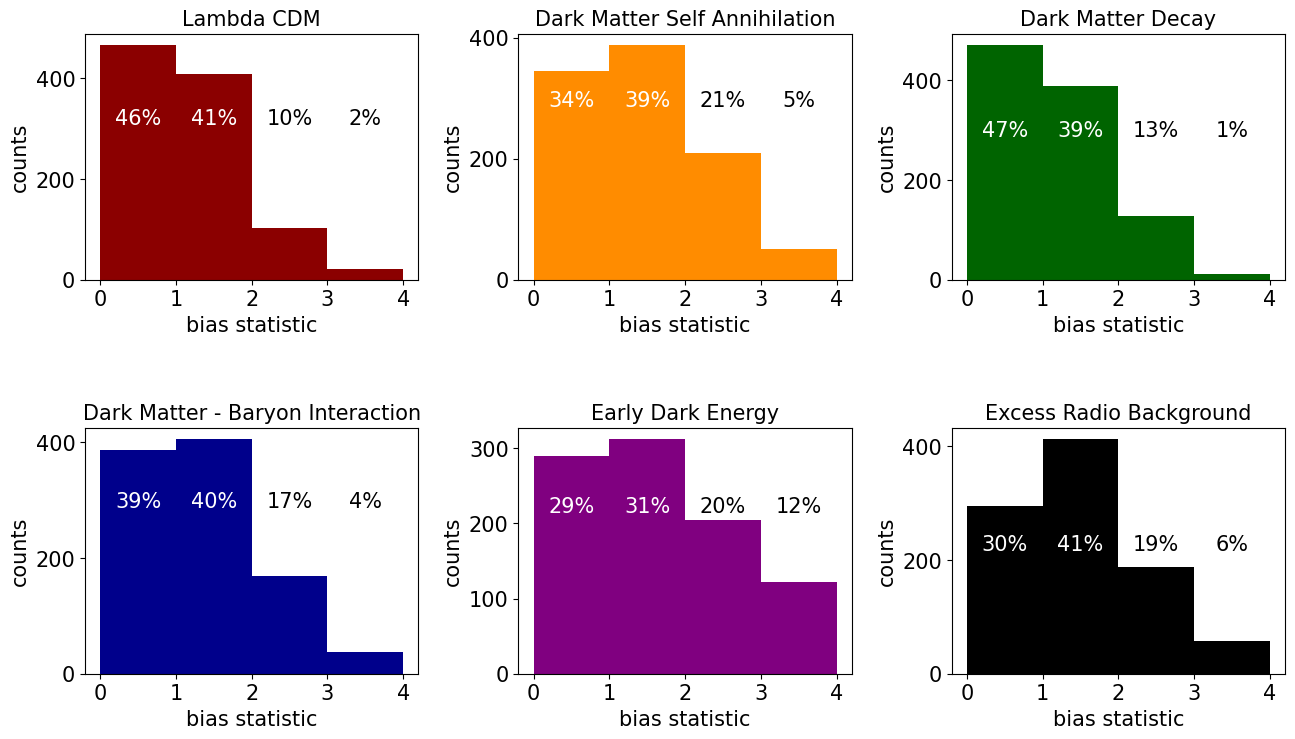

In [280]:
# This is the bias statistic figure that also includes example extractions. Give the people what they want!

hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/bias_scores_5mil_1fg","r")
bias_scores = hdf5["bias_scores"]

# HDF5 loading of 10 bw foreground training sets (10,000 curves each)
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_100_sims_ts","r")
curves_100_training_sets = hdf5["curves_training_set"]
curves_100_training_sets_parameters = hdf5["curves_training_set_parameters"]
# HDF5 loading end

## HDF5 loading block
# lambda CDM
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/CDM_SVD_test_data","r")
CDM_data=np.array(hdf5["data"])
CDM_signal=np.array(hdf5["signal"])
CDM_foreground=np.array(hdf5["foreground"])
CDM_noise=np.array(hdf5["noise"])
CDM_data_no_noise=np.array(hdf5["data_no_noise"])
CDM_foreground_terms=np.array(hdf5["foreground_terms"])
CDM_signal_terms=np.array(hdf5["signal_terms"])

# DMAN
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/DMAN_SVD_test_data","r")
DMAN_data=np.array(hdf5["data"])
DMAN_signal=np.array(hdf5["signal"])
DMAN_foreground=np.array(hdf5["foreground"])
DMAN_noise=np.array(hdf5["noise"])
DMAN_data_no_noise=np.array(hdf5["data_no_noise"])
DMAN_foreground_terms=np.array(hdf5["foreground_terms"])
DMAN_signal_terms=np.array(hdf5["signal_terms"])

# DMD
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/DMD_SVD_test_data","r")
DMD_data=np.array(hdf5["data"])
DMD_signal=np.array(hdf5["signal"])
DMD_foreground=np.array(hdf5["foreground"])
DMD_noise=np.array(hdf5["noise"])
DMD_data_no_noise=np.array(hdf5["data_no_noise"])
DMD_foreground_terms=np.array(hdf5["foreground_terms"])
DMD_signal_terms=np.array(hdf5["signal_terms"])

# MCDM
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/MCDM_SVD_test_data","r")
MCDM_data=np.array(hdf5["data"])
MCDM_signal=np.array(hdf5["signal"])
MCDM_foreground=np.array(hdf5["foreground"])
MCDM_noise=np.array(hdf5["noise"])
MCDM_data_no_noise=np.array(hdf5["data_no_noise"])
MCDM_foreground_terms=np.array(hdf5["foreground_terms"])
MCDM_signal_terms=np.array(hdf5["signal_terms"])

# EDE
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/EDE_SVD_test_data","r")
EDE_data=np.array(hdf5["data"])
EDE_signal=np.array(hdf5["signal"])
EDE_foreground=np.array(hdf5["foreground"])
EDE_noise=np.array(hdf5["noise"])
EDE_data_no_noise=np.array(hdf5["data_no_noise"])
EDE_foreground_terms=np.array(hdf5["foreground_terms"])
EDE_signal_terms=np.array(hdf5["signal_terms"])

# ERB
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/ERB_SVD_test_data","r")
ERB_data=np.array(hdf5["data"])
ERB_signal=np.array(hdf5["signal"])
ERB_foreground=np.array(hdf5["foreground"])
ERB_noise=np.array(hdf5["noise"])
ERB_data_no_noise=np.array(hdf5["data_no_noise"])
ERB_foreground_terms=np.array(hdf5["foreground_terms"])
ERB_signal_terms=np.array(hdf5["signal_terms"])

# lambda CDM
sig_training_set = lambdaCDM_training_set
foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
IC = "DIC"
sim_data = CDM_data[0]
noise_level = sigT(sim_data,N_antenna,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2_CDM = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))

# DMAN
sig_training_set = DMAN_training_set
foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
sig_training_set
IC = "DIC"
sim_data = DMAN_data[0]
noise_level = sigT(sim_data,N_antenna,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2_DMAN = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))

# DMD
foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
sig_training_set = DMD_training_set
IC = "DIC"
sim_data = DMD_data[20]
noise_level = sigT(sim_data,N_antenna,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2_DMD = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))

# MCDM
foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
sig_training_set = MCDM_training_set
IC = "DIC"
sim_data = MCDM_data[0]
noise_level = sigT(sim_data,N_antenna,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2_MCDM = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))

# EDE
foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
sig_training_set = EDE_training_set
IC = "DIC"
sim_data = EDE_data[0]
noise_level = sigT(sim_data,N_antenna,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2_EDE = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))

# ERB
foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
sig_training_set = ERB_training_set
IC = "DIC"
sim_data = ERB_data[0]
noise_level = sigT(sim_data,N_antenna,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2_ERB = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))

# plt.savefig(save_path+"SVD_trainingset_test")


fig, (ax1, ax2,) = plt.subplots(2,3,figsize=(15, 8))

# lambda CDM

plt.subplot(2,3,1)
plt.title("Lambda CDM",fontsize=15)
hist=plt.hist(bias_scores[0],color="darkred",bins=[0,1,2,3,4])
percentages = hist[0]/1000*100
plt.ylabel("counts",fontsize=15)
plt.xlabel("bias statistic",fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15,ticks=[0,1,2,3,4])
plt.text(0.5, 300, f'{percentages[0]:.0f}%', ha='center', va='bottom', fontsize=15,color="white")
plt.text(1.5, 300, f'{percentages[1]:.0f}%', ha='center', va='bottom', fontsize=15,color="white")
plt.text(2.5, 300, f'{percentages[2]:.0f}%', ha='center', va='bottom', fontsize=15,color="black")
plt.text(3.5, 300, f'{percentages[3]:.0f}%', ha='center', va='bottom', fontsize=15,color="black")

# DMAN
plt.subplot(2,3,2)
plt.title("Dark Matter Self Annihilation",fontsize=15)
hist=plt.hist(bias_scores[1],color="darkorange",bins=[0,1,2,3,4])
percentages = hist[0]/1000*100
plt.ylabel("counts",fontsize=15)
plt.xlabel("bias statistic",fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15,ticks=[0,1,2,3,4])
plt.text(0.5, 280, f'{percentages[0]:.0f}%', ha='center', va='bottom', fontsize=15,color="white")
plt.text(1.5, 280, f'{percentages[1]:.0f}%', ha='center', va='bottom', fontsize=15,color="white")
plt.text(2.5, 280, f'{percentages[2]:.0f}%', ha='center', va='bottom', fontsize=15,color="black")
plt.text(3.5, 280, f'{percentages[3]:.0f}%', ha='center', va='bottom', fontsize=15,color="black")

# DMD
plt.subplot(2,3,3)
plt.title("Dark Matter Decay",fontsize=15)
hist=plt.hist(bias_scores[2],color="darkgreen",bins=[0,1,2,3,4])
percentages = hist[0]/1000*100
plt.ylabel("counts",fontsize=15)
plt.xlabel("bias statistic",fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15,ticks=[0,1,2,3,4])
plt.text(0.5, 280, f'{percentages[0]:.0f}%', ha='center', va='bottom', fontsize=15,color="white")
plt.text(1.5, 280, f'{percentages[1]:.0f}%', ha='center', va='bottom', fontsize=15,color="white")
plt.text(2.5, 280, f'{percentages[2]:.0f}%', ha='center', va='bottom', fontsize=15,color="black")
plt.text(3.5, 280, f'{percentages[3]:.0f}%', ha='center', va='bottom', fontsize=15,color="black")

# MCDM
plt.subplot(2,3,4)
plt.title("Dark Matter - Baryon Interaction",fontsize=15)
hist=plt.hist(bias_scores[3],color="darkblue",bins=[0,1,2,3,4])
percentages = hist[0]/1000*100
plt.ylabel("counts",fontsize=15)
plt.xlabel("bias statistic",fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15,ticks=[0,1,2,3,4])
plt.text(0.5, 280, f'{percentages[0]:.0f}%', ha='center', va='bottom', fontsize=15,color="white")
plt.text(1.5, 280, f'{percentages[1]:.0f}%', ha='center', va='bottom', fontsize=15,color="white")
plt.text(2.5, 280, f'{percentages[2]:.0f}%', ha='center', va='bottom', fontsize=15,color="black")
plt.text(3.5, 280, f'{percentages[3]:.0f}%', ha='center', va='bottom', fontsize=15,color="black")

# EDE
plt.subplot(2,3,5)
plt.title("Early Dark Energy",fontsize=15)
hist=plt.hist(bias_scores[4],color="purple",bins=[0,1,2,3,4])
percentages = hist[0]/1000*100
plt.ylabel("counts",fontsize=15)
plt.xlabel("bias statistic",fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15,ticks=[0,1,2,3,4])
plt.text(0.5, 210, f'{percentages[0]:.0f}%', ha='center', va='bottom', fontsize=15,color="white")
plt.text(1.5, 210, f'{percentages[1]:.0f}%', ha='center', va='bottom', fontsize=15,color="white")
plt.text(2.5, 210, f'{percentages[2]:.0f}%', ha='center', va='bottom', fontsize=15,color="black")
plt.text(3.5, 210, f'{percentages[3]:.0f}%', ha='center', va='bottom', fontsize=15,color="black")

# ERB
plt.subplot(2,3,6)
plt.title("Excess Radio Background",fontsize=15)
hist=plt.hist(bias_scores[5],color="black",bins=[0,1,2,3,4])
percentages = hist[0]/1000*100
plt.ylabel("counts",fontsize=15)
plt.xlabel("bias statistic",fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15,ticks=[0,1,2,3,4])
plt.text(0.5, 210, f'{percentages[0]:.0f}%', ha='center', va='bottom', fontsize=15,color="white")
plt.text(1.5, 210, f'{percentages[1]:.0f}%', ha='center', va='bottom', fontsize=15,color="white")
plt.text(2.5, 210, f'{percentages[2]:.0f}%', ha='center', va='bottom', fontsize=15,color="black")
plt.text(3.5, 210, f'{percentages[3]:.0f}%', ha='center', va='bottom', fontsize=15,color="black")

# plt.subplot(4,3,1)
# plt.title("Early Dark Energy",fontsize=15)
# plt.hist(EDE_foreground_terms, label="foreground term counts",color="magenta",hatch="/")
# mean= EDE_foreground_terms.mean()
# std= EDE_foreground_terms.std()
# ranger = np.arange(0,int(EDE_foreground_terms.max())+10,0.1)
# plt.hist(EDE_signal_terms,bins=10, label="signal term counts",color="purple")
# mean= EDE_signal_terms.mean()
# std= EDE_signal_terms.std()
# ranger = np.arange(0,int(EDE_signal_terms.max())+10,0.1)
# plt.axvline(mean,color="purple",ls="--",label="mean")
# plt.axvline(std+mean,color="purple",ls=":",label="standard deviation")
# plt.ylabel("counts",fontsize=10)
# plt.xlabel("number of terms",fontsize=10)
# plt.xticks(np.arange(20))
# plt.legend()

# plt.subplot(4,3,1)
# plt.title("Excess Radio Background",fontsize=15)
# plt.hist(ERB_foreground_terms, label="foreground term counts",color="gray",hatch="/")
# mean= ERB_foreground_terms.mean()
# std= ERB_foreground_terms.std()
# ranger = np.arange(0,int(ERB_foreground_terms.max())+10,0.1)
# plt.hist(ERB_signal_terms,bins=10, label="signal term counts",color="black")
# mean= ERB_signal_terms.mean()
# std= ERB_signal_terms.std()
# ranger = np.arange(0,int(ERB_signal_terms.max())+10,0.1)
# plt.axvline(mean,color="black",ls="--",label="mean")
# plt.axvline(std+mean,color="black",ls=":",label="standard deviation")
# plt.ylabel("counts",fontsize=10)
# plt.xlabel("number of terms",fontsize=10)
# plt.xticks(np.arange(20))
# plt.legend()

# plt.subplot(4,3,1)
# plt.title("Incorrect Signal Inputs For a Lambda CDM Training Set",fontsize=15)
# plt.hist(CDM_foreground_terms,color="red",hatch="/",alpha=0.25)
# mean= CDM_foreground_terms.mean()
# std= CDM_foreground_terms.std()
# ranger = np.arange(0,int(CDM_foreground_terms.max())+10,0.1)
# plt.hist(CDM_signal_terms,bins=10,color="darkred",alpha=0.25)
# mean= CDM_signal_terms.mean()
# std= CDM_signal_terms.std()
# ranger = np.arange(0,int(CDM_signal_terms.max())+10,0.1)
# plt.axvline(mean,color="darkred",ls="--",alpha=0.25)
# plt.axvline(std+mean,color="darkred",ls=":",alpha=0.25)
# plt.ylabel("counts",fontsize=10)
# plt.xlabel("number of terms",fontsize=10)
# plt.xticks(np.arange(20))
# plt.axvline(num_signal_terms_DMAN,color="darkorange",ls="-.",label="Dark Matter Annihilation")
# plt.axvline(num_signal_terms_DMD+0.1,color="darkgreen",ls="-.",label="Dark Matter Decay")
# plt.axvline(num_signal_terms_MCDM,color="darkblue",ls="-.",label="Dark Matter - Baryon Interaction")
# plt.axvline(num_signal_terms_EDE,color="purple",ls="-.",label="Early Dark Energy")
# plt.axvline(num_signal_terms_ERB,color="black",ls="-.",label="Excess Radio Background")
# plt.legend()

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3, hspace=0.6)

# plt.savefig(save_path+"SVD_trainingset_test")



In [151]:
((fitter2_CDM.subbasis_channel_error("Signal")**2).sum())/len(frequencies)*bias_scores[0].mean()

0.06556444804538608

In [ ]:
bias_scores[0].mean()*

1.135966670842073

In [156]:
fitter2_CDM.subbasis_channel_error("Signal")

array([1.61941970e-12, 4.04697500e-02, 7.45502091e-02, 1.05279917e-01,
       1.33359844e-01, 1.58987032e-01, 1.82282050e-01, 2.03541609e-01,
       2.23460950e-01, 2.42321836e-01, 2.60336241e-01, 2.77686444e-01,
       2.94528769e-01, 3.10997309e-01, 3.27360695e-01, 3.43315651e-01,
       3.59018185e-01, 3.74191779e-01, 3.88603066e-01, 4.02058192e-01,
       4.14397280e-01, 4.25490388e-01, 4.35234094e-01, 4.43548578e-01,
       4.50375111e-01, 4.55673904e-01, 4.59422248e-01, 4.61603280e-01,
       4.62235263e-01, 4.61314485e-01, 4.58875360e-01, 4.54958965e-01,
       4.48626660e-01, 4.44779180e-01, 4.40778237e-01, 4.36578039e-01,
       4.30112433e-01, 4.23574531e-01, 4.17043444e-01, 4.10524787e-01,
       4.04024877e-01, 3.97550475e-01, 3.91108561e-01, 3.84706162e-01,
       3.78350201e-01, 3.72047380e-01, 3.65804089e-01, 3.59626332e-01,
       3.53519670e-01, 3.47489192e-01, 3.41539482e-01, 3.35674611e-01,
       3.29887627e-01, 3.24030697e-01, 3.18616648e-01, 3.13075807e-01,
      

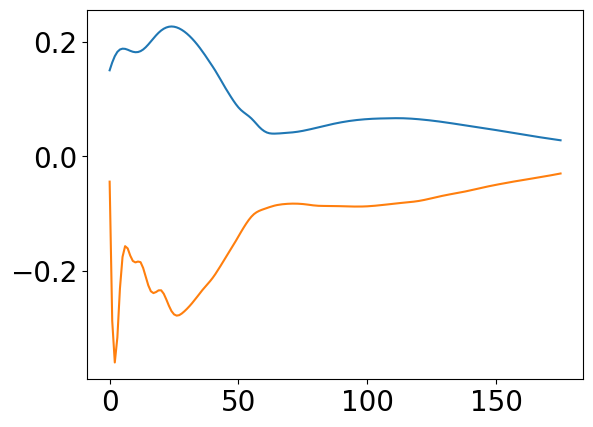

In [198]:
# plt.plot(fitter2_DMAN.subbasis_channel_mean("Signal"))
plt.plot(fitter2_EDE.subbasis_channel_mean("Signal"))
plt.plot(fitter2_EDE.subbasis_channel_mean("Foreground")-EDE_foreground[0])
# for n in range(1000):
#     plt.plot((CDM_foreground[100]-curves_100_training_sets[0][n])/CDM_foreground[0])

In [ ]:
CDM_data

(1000, 176)

## SVD Training Set Fit Graph

Minimizing DIC over grid.
number of foreground terms: 5
number of signal terms: 1
Minimizing DIC over grid.
number of foreground terms: 1
number of signal terms: 7
Minimizing DIC over grid.
number of foreground terms: 3
number of signal terms: 7
Minimizing DIC over grid.
number of foreground terms: 3
number of signal terms: 2
Minimizing DIC over grid.
number of foreground terms: 4
number of signal terms: 3


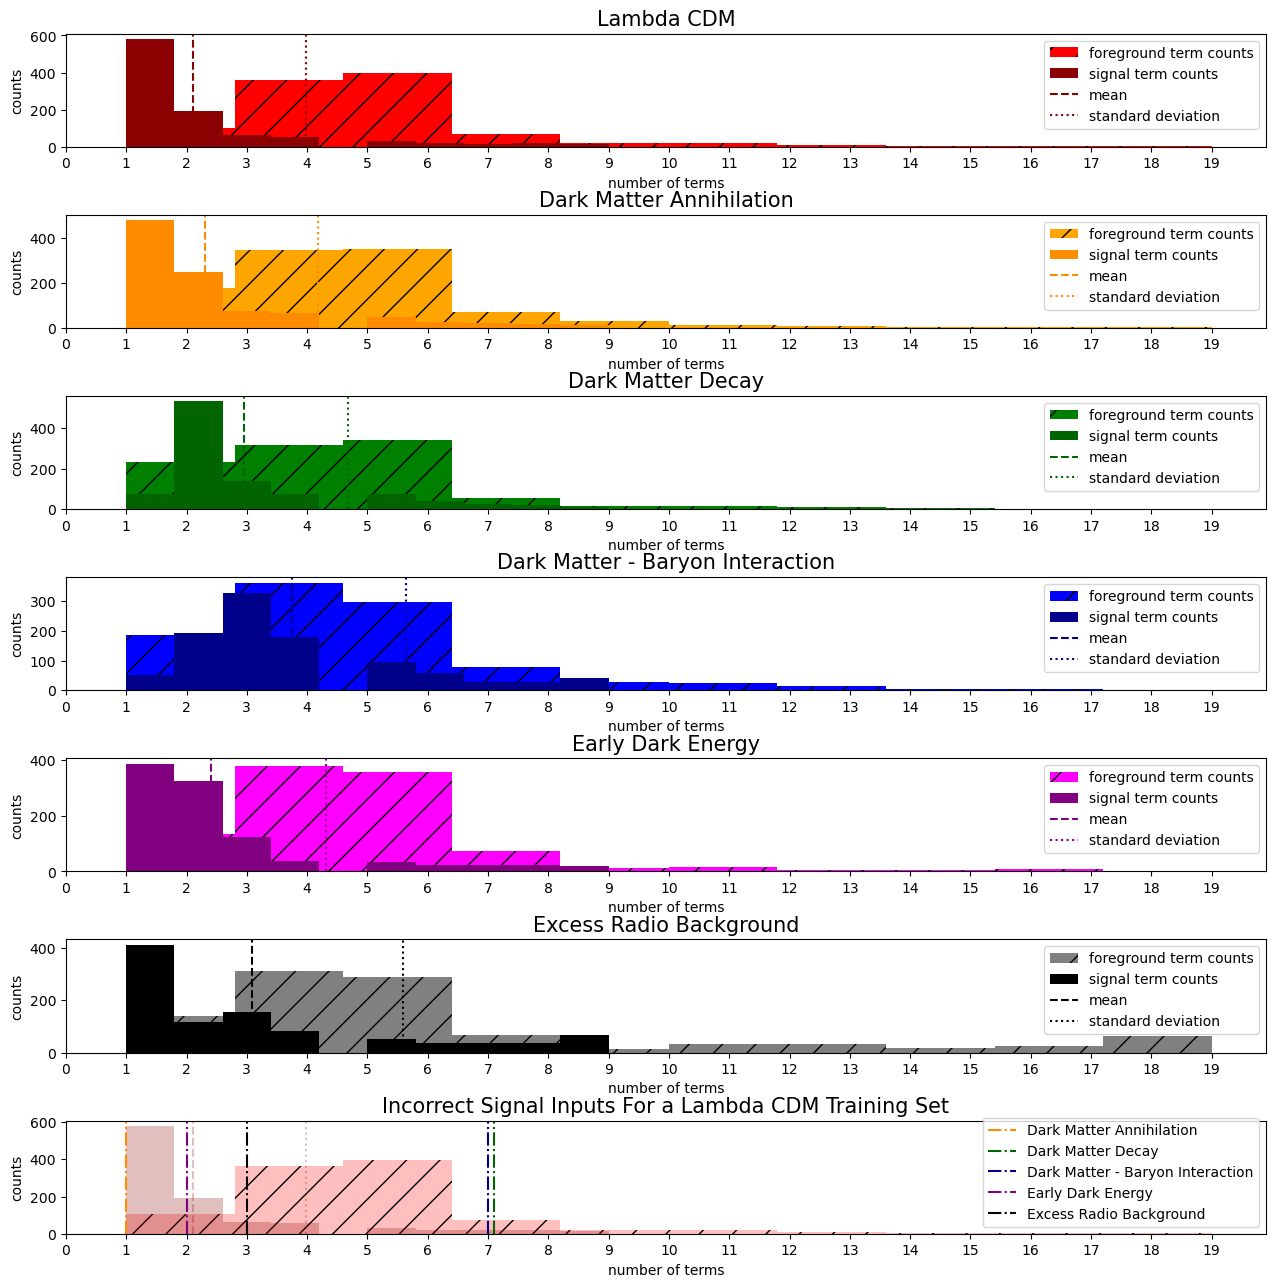

In [8]:
# SVD Training Set Fit Graph
## HDF5 loading of 100 bw foreground training sets (10,000 curves each)
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_weighted_fg_10_sims_ts","r")
curves_100_training_sets = hdf5["curves_training_set"]
curves_100_training_sets_parameters = hdf5["curves_training_set_parameters"]

## Loaded in signal training sets

#lambda CDM
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/lambdaCDM","r")
lambdaCDM_training_set = f["signal_training_set"]
lambdaCDM_training_set_params = f["signal_training_set_parameters"]

# Self-Annihilating Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMAN","r")
DMAN_training_set = f["signal_training_set"]
DMAN_training_set_params = f["signal_training_set_parameters"]

# Decaying Dark Matter
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/DMD","r")
DMD_training_set = f["signal_training_set"]
DMD_training_set_params = f["signal_training_set_parameters"]

# Early Dark Energy
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/EDE","r")
EDE_training_set = f["signal_training_set"]
EDE_training_set_params = f["signal_training_set_parameters"]

# Extra Radio Background
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/ERB","r")
ERB_training_set = f["signal_training_set"]
ERB_training_set_params = f["signal_training_set_parameters"]

# Baryon-Dark Matter Interaction (MCDM)
f = h5py.File("/home/dbarker7752/21_cm_group/signal_training_sets/MCDM","r")
MCDM_training_set = f["signal_training_set"]
MCDM_training_set_params = f["signal_training_set_parameters"]

# ## HDF5 loading end
# Ncurves = 1000
# # lambda CDM SVD test:
# CDM_test_sims = np.zeros((Ncurves,len(frequencies)))
# CDM_test_fg = np.zeros((Ncurves,len(frequencies)))
# CDM_test_sig = np.zeros((Ncurves,len(frequencies)))
# CDM_test_noise = np.zeros((Ncurves,len(frequencies)))
# CDM_test_nonoise = np.zeros((Ncurves,len(frequencies)))

# for n in range(Ncurves):
#     random_index1=int(np.random.random()*len(curves_100_training_sets[0]))
#     random_index2=int(np.random.random()*len(lambdaCDM_training_set))
#     CDM_test_sims[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],lambdaCDM_training_set[random_index2],dnu,dt)[0]
#     CDM_test_fg[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],lambdaCDM_training_set[random_index2],dnu,dt)[2]
#     CDM_test_sig[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],lambdaCDM_training_set[random_index2],dnu,dt)[1]
#     CDM_test_noise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],lambdaCDM_training_set[random_index2],dnu,dt)[3]
#     CDM_test_nonoise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],lambdaCDM_training_set[random_index2],dnu,dt)[4]



# CDM_foreground_terms = np.zeros((Ncurves))
# CDM_signal_terms = np.zeros((Ncurves))
# sig_training_set = lambdaCDM_training_set
# sim_curves = CDM_test_sims
# for n in (range (Ncurves)):
# #### Pylinex Fit #####
#     foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
#     sig_training_set
#     IC = "DIC"
#     sim = simulation_curves_array[n]
#     sim_data = sim_curves[n]
#     noise_level = sigT(sim_data,dnu,dt)
#     foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
#     signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
#     temperatures = sim_data
#     basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
#     quantity = AttributeQuantity(IC)
#     dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
#     # priors = {"Signal_prior" : signal_basis.gaussian_prior}
#     meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
#     fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
#     CDM_foreground_terms[n] = fitter2.sizes['Foreground']
#     CDM_signal_terms[n] = fitter2.sizes['Signal']
# ### End PYLINEX fit

# # HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/CDM_SVD_test_data","w")
# hdf5.create_dataset("data",data=CDM_test_sims)
# hdf5.create_dataset("foreground",data=CDM_test_fg)
# hdf5.create_dataset("signal",data=CDM_test_sig)
# hdf5.create_dataset("noise",data=CDM_test_noise)
# hdf5.create_dataset("data_no_noise",data=CDM_test_nonoise)
# hdf5.create_dataset("foreground_terms",data=CDM_foreground_terms)
# hdf5.create_dataset("signal_terms",data=CDM_signal_terms)
# hdf5.close()
# ## End of HDF5 data saving

# # DMAN SVD test:
# DMAN_test_sims = np.zeros((Ncurves,len(frequencies)))
# DMAN_test_fg = np.zeros((Ncurves,len(frequencies)))
# DMAN_test_sig = np.zeros((Ncurves,len(frequencies)))
# DMAN_test_noise = np.zeros((Ncurves,len(frequencies)))
# DMAN_test_nonoise = np.zeros((Ncurves,len(frequencies)))

# for n in range(Ncurves):
#     random_index1=int(np.random.random()*len(curves_100_training_sets[0]))
#     random_index2=int(np.random.random()*len(DMAN_training_set))
#     DMAN_test_sims[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],DMAN_training_set[random_index2],dnu,dt)[0]
#     DMAN_test_fg[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],DMAN_training_set[random_index2],dnu,dt)[2]
#     DMAN_test_sig[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],DMAN_training_set[random_index2],dnu,dt)[1]
#     DMAN_test_noise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],DMAN_training_set[random_index2],dnu,dt)[3]
#     DMAN_test_nonoise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],DMAN_training_set[random_index2],dnu,dt)[4]




# DMAN_foreground_terms = np.zeros((Ncurves))
# DMAN_signal_terms = np.zeros((Ncurves))
# sig_training_set = DMAN_training_set
# sim_curves = DMAN_test_sims
# for n in (range (Ncurves)):
# #### Pylinex Fit #####
#     foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
#     sig_training_set
#     IC = "DIC"
#     sim = simulation_curves_array[n]
#     sim_data = sim_curves[n]
#     noise_level = sigT(sim_data,dnu,dt)
#     foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
#     signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
#     temperatures = sim_data
#     basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
#     quantity = AttributeQuantity(IC)
#     dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
#     # priors = {"Signal_prior" : signal_basis.gaussian_prior}
#     meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
#     fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
#     DMAN_foreground_terms[n] = fitter2.sizes['Foreground']
#     DMAN_signal_terms[n] = fitter2.sizes['Signal']
# ### End PYLINEX fit

#     # HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/DMAN_SVD_test_data","w")
# hdf5.create_dataset("data",data=DMAN_test_sims)
# hdf5.create_dataset("foreground",data=DMAN_test_fg)
# hdf5.create_dataset("signal",data=DMAN_test_sig)
# hdf5.create_dataset("noise",data=DMAN_test_noise)
# hdf5.create_dataset("data_no_noise",data=DMAN_test_nonoise)
# hdf5.create_dataset("foreground_terms",data=DMAN_foreground_terms)
# hdf5.create_dataset("signal_terms",data=DMAN_signal_terms)
# hdf5.close()
# ## End of HDF5 data saving

# # DMD SVD test:
# DMD_test_sims = np.zeros((Ncurves,len(frequencies)))
# DMD_test_fg = np.zeros((Ncurves,len(frequencies)))
# DMD_test_sig = np.zeros((Ncurves,len(frequencies)))
# DMD_test_noise = np.zeros((Ncurves,len(frequencies)))
# DMD_test_nonoise = np.zeros((Ncurves,len(frequencies)))

# for n in range(Ncurves):
#     random_index1=int(np.random.random()*len(curves_100_training_sets[0]))
#     random_index2=int(np.random.random()*len(DMD_training_set))
#     DMD_test_sims[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],DMD_training_set[random_index2],dnu,dt)[0]
#     DMD_test_fg[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],DMD_training_set[random_index2],dnu,dt)[2]
#     DMD_test_sig[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],DMD_training_set[random_index2],dnu,dt)[1]
#     DMD_test_noise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],DMD_training_set[random_index2],dnu,dt)[3]
#     DMD_test_nonoise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],DMD_training_set[random_index2],dnu,dt)[4]




# DMD_foreground_terms = np.zeros((Ncurves))
# DMD_signal_terms = np.zeros((Ncurves))
# sig_training_set = DMD_training_set
# sim_curves = DMD_test_sims
# for n in (range (Ncurves)):
# #### Pylinex Fit #####
#     foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
#     sig_training_set
#     IC = "DIC"
#     sim = simulation_curves_array[n]
#     sim_data = sim_curves[n]
#     noise_level = sigT(sim_data,dnu,dt)
#     foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
#     signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
#     temperatures = sim_data
#     basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
#     quantity = AttributeQuantity(IC)
#     dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
#     # priors = {"Signal_prior" : signal_basis.gaussian_prior}
#     meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
#     fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
#     DMD_foreground_terms[n] = fitter2.sizes['Foreground']
#     DMD_signal_terms[n] = fitter2.sizes['Signal']
# ### End PYLINEX fit

#     # HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/DMD_SVD_test_data","w")
# hdf5.create_dataset("data",data=DMD_test_sims)
# hdf5.create_dataset("foreground",data=DMD_test_fg)
# hdf5.create_dataset("signal",data=DMD_test_sig)
# hdf5.create_dataset("noise",data=DMD_test_noise)
# hdf5.create_dataset("data_no_noise",data=DMD_test_nonoise)
# hdf5.create_dataset("foreground_terms",data=DMD_foreground_terms)
# hdf5.create_dataset("signal_terms",data=DMD_signal_terms)
# hdf5.close()
# ## End of HDF5 data saving

# # MCDM SVD test:
# MCDM_test_sims = np.zeros((Ncurves,len(frequencies)))
# MCDM_test_fg = np.zeros((Ncurves,len(frequencies)))
# MCDM_test_sig = np.zeros((Ncurves,len(frequencies)))
# MCDM_test_noise = np.zeros((Ncurves,len(frequencies)))
# MCDM_test_nonoise = np.zeros((Ncurves,len(frequencies)))

# for n in range(Ncurves):
#     random_index1=int(np.random.random()*len(curves_100_training_sets[0]))
#     random_index2=int(np.random.random()*len(MCDM_training_set))
#     MCDM_test_sims[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],MCDM_training_set[random_index2],dnu,dt)[0]
#     MCDM_test_fg[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],MCDM_training_set[random_index2],dnu,dt)[2]
#     MCDM_test_sig[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],MCDM_training_set[random_index2],dnu,dt)[1]
#     MCDM_test_noise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],MCDM_training_set[random_index2],dnu,dt)[3]
#     MCDM_test_nonoise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],MCDM_training_set[random_index2],dnu,dt)[4]




# MCDM_foreground_terms = np.zeros((Ncurves))
# MCDM_signal_terms = np.zeros((Ncurves))
# sig_training_set = MCDM_training_set
# sim_curves = MCDM_test_sims
# for n in (range (Ncurves)):
# #### Pylinex Fit #####
#     foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
#     sig_training_set
#     IC = "DIC"
#     sim = simulation_curves_array[n]
#     sim_data = sim_curves[n]
#     noise_level = sigT(sim_data,dnu,dt)
#     foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
#     signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
#     temperatures = sim_data
#     basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
#     quantity = AttributeQuantity(IC)
#     dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
#     # priors = {"Signal_prior" : signal_basis.gaussian_prior}
#     meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
#     fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
#     MCDM_foreground_terms[n] = fitter2.sizes['Foreground']
#     MCDM_signal_terms[n] = fitter2.sizes['Signal']
# ### End PYLINEX fit

#     # HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/MCDM_SVD_test_data","w")
# hdf5.create_dataset("data",data=MCDM_test_sims)
# hdf5.create_dataset("foreground",data=MCDM_test_fg)
# hdf5.create_dataset("signal",data=MCDM_test_sig)
# hdf5.create_dataset("noise",data=MCDM_test_noise)
# hdf5.create_dataset("data_no_noise",data=MCDM_test_nonoise)
# hdf5.create_dataset("foreground_terms",data=MCDM_foreground_terms)
# hdf5.create_dataset("signal_terms",data=MCDM_signal_terms)
# hdf5.close()
# ## End of HDF5 data saving

# # EDE SVD test:
# EDE_test_sims = np.zeros((Ncurves,len(frequencies)))
# EDE_test_fg = np.zeros((Ncurves,len(frequencies)))
# EDE_test_sig = np.zeros((Ncurves,len(frequencies)))
# EDE_test_noise = np.zeros((Ncurves,len(frequencies)))
# EDE_test_nonoise = np.zeros((Ncurves,len(frequencies)))

# for n in range(Ncurves):
#     random_index1=int(np.random.random()*len(curves_100_training_sets[0]))
#     random_index2=int(np.random.random()*len(EDE_training_set))
#     EDE_test_sims[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],EDE_training_set[random_index2],dnu,dt)[0]
#     EDE_test_fg[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],EDE_training_set[random_index2],dnu,dt)[2]
#     EDE_test_sig[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],EDE_training_set[random_index2],dnu,dt)[1]
#     EDE_test_noise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],EDE_training_set[random_index2],dnu,dt)[3]
#     EDE_test_nonoise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],EDE_training_set[random_index2],dnu,dt)[4]




# EDE_foreground_terms = np.zeros((Ncurves))
# EDE_signal_terms = np.zeros((Ncurves))
# sig_training_set = EDE_training_set
# sim_curves = EDE_test_sims
# for n in (range (Ncurves)):
# #### Pylinex Fit #####
#     foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
#     sig_training_set
#     IC = "DIC"
#     sim = simulation_curves_array[n]
#     sim_data = sim_curves[n]
#     noise_level = sigT(sim_data,dnu,dt)
#     foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
#     signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
#     temperatures = sim_data
#     basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
#     quantity = AttributeQuantity(IC)
#     dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
#     # priors = {"Signal_prior" : signal_basis.gaussian_prior}
#     meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
#     fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
#     EDE_foreground_terms[n] = fitter2.sizes['Foreground']
#     EDE_signal_terms[n] = fitter2.sizes['Signal']
# ### End PYLINEX fit

#     # HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/EDE_SVD_test_data","w")
# hdf5.create_dataset("data",data=EDE_test_sims)
# hdf5.create_dataset("foreground",data=EDE_test_fg)
# hdf5.create_dataset("signal",data=EDE_test_sig)
# hdf5.create_dataset("noise",data=EDE_test_noise)
# hdf5.create_dataset("data_no_noise",data=EDE_test_nonoise)
# hdf5.create_dataset("foreground_terms",data=EDE_foreground_terms)
# hdf5.create_dataset("signal_terms",data=EDE_signal_terms)
# hdf5.close()
# ## End of HDF5 data saving

# # ERB SVD test:
# ERB_test_sims = np.zeros((Ncurves,len(frequencies)))
# ERB_test_fg = np.zeros((Ncurves,len(frequencies)))
# ERB_test_sig = np.zeros((Ncurves,len(frequencies)))
# ERB_test_noise = np.zeros((Ncurves,len(frequencies)))
# ERB_test_nonoise = np.zeros((Ncurves,len(frequencies)))

# for n in range(Ncurves):
#     random_index1=int(np.random.random()*len(curves_100_training_sets[0]))
#     random_index2=int(np.random.random()*len(ERB_training_set))
#     ERB_test_sims[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],ERB_training_set[random_index2],dnu,dt)[0]
#     ERB_test_fg[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],ERB_training_set[random_index2],dnu,dt)[2]
#     ERB_test_sig[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],ERB_training_set[random_index2],dnu,dt)[1]
#     ERB_test_noise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],ERB_training_set[random_index2],dnu,dt)[3]
#     ERB_test_nonoise[n] = py21cmsig.simulation_run(curves_100_training_sets[0][random_index1],ERB_training_set[random_index2],dnu,dt)[4]




# ERB_foreground_terms = np.zeros((Ncurves))
# ERB_signal_terms = np.zeros((Ncurves))
# sig_training_set = ERB_training_set
# sim_curves = ERB_test_sims
# for n in (range (Ncurves)):
#     #### Pylinex Fit #####
#     foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
#     sig_training_set
#     IC = "DIC"
#     sim = simulation_curves_array[n]
#     sim_data = sim_curves[n]
#     noise_level = sigT(sim_data,dnu,dt)
#     foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
#     signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
#     temperatures = sim_data
#     basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
#     quantity = AttributeQuantity(IC)
#     dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
#     # priors = {"Signal_prior" : signal_basis.gaussian_prior}
#     meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
#     fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
#     ERB_foreground_terms[n] = fitter2.sizes['Foreground']
#     ERB_signal_terms[n] = fitter2.sizes['Signal']
#     ### End PYLINEX fit

#     # HDF5 data saving 
# hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/ERB_SVD_test_data","w")
# hdf5.create_dataset("data",data=ERB_test_sims)
# hdf5.create_dataset("foreground",data=ERB_test_fg)
# hdf5.create_dataset("signal",data=ERB_test_sig)
# hdf5.create_dataset("noise",data=ERB_test_noise)
# hdf5.create_dataset("data_no_noise",data=ERB_test_nonoise)
# hdf5.create_dataset("foreground_terms",data=ERB_foreground_terms)
# hdf5.create_dataset("signal_terms",data=ERB_signal_terms)
# hdf5.close()
# # End of HDF5 data saving

## HDF5 loading block
# lambda CDM
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/CDM_SVD_test_data","r")
CDM_data=np.array(hdf5["data"])
CDM_signal=np.array(hdf5["signal"])
CDM_foreground=np.array(hdf5["foreground"])
CDM_noise=np.array(hdf5["noise"])
CDM_data_no_noise=np.array(hdf5["data_no_noise"])
CDM_foreground_terms=np.array(hdf5["foreground_terms"])
CDM_signal_terms=np.array(hdf5["signal_terms"])

# DMAN
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/DMAN_SVD_test_data","r")
DMAN_data=np.array(hdf5["data"])
DMAN_signal=np.array(hdf5["signal"])
DMAN_foreground=np.array(hdf5["foreground"])
DMAN_noise=np.array(hdf5["noise"])
DMAN_data_no_noise=np.array(hdf5["data_no_noise"])
DMAN_foreground_terms=np.array(hdf5["foreground_terms"])
DMAN_signal_terms=np.array(hdf5["signal_terms"])

# DMD
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/DMD_SVD_test_data","r")
DMD_data=np.array(hdf5["data"])
DMD_signal=np.array(hdf5["signal"])
DMD_foreground=np.array(hdf5["foreground"])
DMD_noise=np.array(hdf5["noise"])
DMD_data_no_noise=np.array(hdf5["data_no_noise"])
DMD_foreground_terms=np.array(hdf5["foreground_terms"])
DMD_signal_terms=np.array(hdf5["signal_terms"])

# MCDM
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/MCDM_SVD_test_data","r")
MCDM_data=np.array(hdf5["data"])
MCDM_signal=np.array(hdf5["signal"])
MCDM_foreground=np.array(hdf5["foreground"])
MCDM_noise=np.array(hdf5["noise"])
MCDM_data_no_noise=np.array(hdf5["data_no_noise"])
MCDM_foreground_terms=np.array(hdf5["foreground_terms"])
MCDM_signal_terms=np.array(hdf5["signal_terms"])

# EDE
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/EDE_SVD_test_data","r")
EDE_data=np.array(hdf5["data"])
EDE_signal=np.array(hdf5["signal"])
EDE_foreground=np.array(hdf5["foreground"])
EDE_noise=np.array(hdf5["noise"])
EDE_data_no_noise=np.array(hdf5["data_no_noise"])
EDE_foreground_terms=np.array(hdf5["foreground_terms"])
EDE_signal_terms=np.array(hdf5["signal_terms"])

# ERB
hdf5 = h5py.File("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/ERB_SVD_test_data","r")
ERB_data=np.array(hdf5["data"])
ERB_signal=np.array(hdf5["signal"])
ERB_foreground=np.array(hdf5["foreground"])
ERB_noise=np.array(hdf5["noise"])
ERB_data_no_noise=np.array(hdf5["data_no_noise"])
ERB_foreground_terms=np.array(hdf5["foreground_terms"])
ERB_signal_terms=np.array(hdf5["signal_terms"])


# Use this for the examples of bad stuff
#signal_training_set =   # Fill this out with the correct (or incorrect) signal training set
#sim_curves =  # 
sig_training_set = lambdaCDM_training_set
foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
sig_training_set
IC = "DIC"
sim_data = DMAN_data[0]
noise_level = sigT(sim_data,1,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2_DMAN = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms_DMAN = fitter2_DMAN.sizes['Foreground']
num_signal_terms_DMAN = fitter2_DMAN.sizes['Signal']
print(f"number of foreground terms: {num_foreground_terms_DMAN}")
print(f"number of signal terms: {num_signal_terms_DMAN}")

foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
sig_training_set
IC = "DIC"
sim_data = DMD_data[20]
noise_level = sigT(sim_data,1,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2_DMD = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms_DMD = fitter2_DMD.sizes['Foreground']
num_signal_terms_DMD = fitter2_DMD.sizes['Signal']
print(f"number of foreground terms: {num_foreground_terms_DMD}")
print(f"number of signal terms: {num_signal_terms_DMD}")

foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
sig_training_set
IC = "DIC"
sim_data = MCDM_data[0]
noise_level = sigT(sim_data,1,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2_MCDM = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms_MCDM = fitter2_MCDM.sizes['Foreground']
num_signal_terms_MCDM = fitter2_MCDM.sizes['Signal']
print(f"number of foreground terms: {num_foreground_terms_MCDM}")
print(f"number of signal terms: {num_signal_terms_MCDM}")

foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
sig_training_set
IC = "DIC"
sim_data = EDE_data[0]
noise_level = sigT(sim_data,1,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2_EDE = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms_EDE = fitter2_EDE.sizes['Foreground']
num_signal_terms_EDE = fitter2_EDE.sizes['Signal']
print(f"number of foreground terms: {num_foreground_terms_EDE}")
print(f"number of signal terms: {num_signal_terms_EDE}")

foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
sig_training_set
IC = "DIC"
sim_data = ERB_data[0]
noise_level = sigT(sim_data,1,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2_ERB = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms_ERB = fitter2_ERB.sizes['Foreground']
num_signal_terms_ERB = fitter2_ERB.sizes['Signal']
print(f"number of foreground terms: {num_foreground_terms_ERB}")
print(f"number of signal terms: {num_signal_terms_ERB}")

# plt.savefig(save_path+"SVD_trainingset_test")


fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7,1,figsize=(15, 15))

plt.subplot(7,1,1)
plt.title("Lambda CDM",fontsize=15)
plt.hist(CDM_foreground_terms, label="foreground term counts",color="red",hatch="/")
mean= CDM_foreground_terms.mean()
std= CDM_foreground_terms.std()
ranger = np.arange(0,int(CDM_foreground_terms.max())+10,0.1)
plt.hist(CDM_signal_terms,bins=10, label="signal term counts",color="darkred")
mean= CDM_signal_terms.mean()
std= CDM_signal_terms.std()
ranger = np.arange(0,int(CDM_signal_terms.max())+10,0.1)
plt.axvline(mean,color="darkred",ls="--",label="mean")
plt.axvline(std+mean,color="darkred",ls=":",label="standard deviation")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.xticks(np.arange(20))
plt.legend()


plt.subplot(7,1,2)
plt.title("Dark Matter Annihilation",fontsize=15)
plt.hist(DMAN_foreground_terms, label="foreground term counts",color="orange",hatch="/")
mean= DMAN_foreground_terms.mean()
std= DMAN_foreground_terms.std()
ranger = np.arange(0,int(DMAN_foreground_terms.max())+10,0.1)
plt.hist(DMAN_signal_terms,bins=10, label="signal term counts",color="darkorange")
mean= DMAN_signal_terms.mean()
std= DMAN_signal_terms.std()
ranger = np.arange(0,int(DMAN_signal_terms.max())+10,0.1)
plt.axvline(mean,color="darkorange",ls="--",label="mean")
plt.axvline(std+mean,color="darkorange",ls=":",label="standard deviation")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.xticks(np.arange(20))
plt.legend()

plt.subplot(7,1,3)
plt.title("Dark Matter Decay",fontsize=15)
plt.hist(DMD_foreground_terms, label="foreground term counts",color="green",hatch="/")
mean= DMD_foreground_terms.mean()
std= DMD_foreground_terms.std()
ranger = np.arange(0,int(DMD_foreground_terms.max())+10,0.1)
plt.hist(DMD_signal_terms,bins=10, label="signal term counts",color="darkgreen")
mean= DMD_signal_terms.mean()
std= DMD_signal_terms.std()
ranger = np.arange(0,int(DMD_signal_terms.max())+10,0.1)
plt.axvline(mean,color="darkgreen",ls="--",label="mean")
plt.axvline(std+mean,color="darkgreen",ls=":",label="standard deviation")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.xticks(np.arange(20))
plt.legend()

plt.subplot(7,1,4)
plt.title("Dark Matter - Baryon Interaction",fontsize=15)
plt.hist(MCDM_foreground_terms, label="foreground term counts",color="blue",hatch="/")
mean= MCDM_foreground_terms.mean()
std= MCDM_foreground_terms.std()
ranger = np.arange(0,int(MCDM_foreground_terms.max())+10,0.1)
plt.hist(MCDM_signal_terms,bins=10, label="signal term counts",color="darkblue")
mean= MCDM_signal_terms.mean()
std= MCDM_signal_terms.std()
ranger = np.arange(0,int(MCDM_signal_terms.max())+10,0.1)
plt.axvline(mean,color="darkblue",ls="--",label="mean")
plt.axvline(std+mean,color="darkblue",ls=":",label="standard deviation")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.xticks(np.arange(20))
plt.legend()

plt.subplot(7,1,5)
plt.title("Early Dark Energy",fontsize=15)
plt.hist(EDE_foreground_terms, label="foreground term counts",color="magenta",hatch="/")
mean= EDE_foreground_terms.mean()
std= EDE_foreground_terms.std()
ranger = np.arange(0,int(EDE_foreground_terms.max())+10,0.1)
plt.hist(EDE_signal_terms,bins=10, label="signal term counts",color="purple")
mean= EDE_signal_terms.mean()
std= EDE_signal_terms.std()
ranger = np.arange(0,int(EDE_signal_terms.max())+10,0.1)
plt.axvline(mean,color="purple",ls="--",label="mean")
plt.axvline(std+mean,color="purple",ls=":",label="standard deviation")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.xticks(np.arange(20))
plt.legend()

plt.subplot(7,1,6)
plt.title("Excess Radio Background",fontsize=15)
plt.hist(ERB_foreground_terms, label="foreground term counts",color="gray",hatch="/")
mean= ERB_foreground_terms.mean()
std= ERB_foreground_terms.std()
ranger = np.arange(0,int(ERB_foreground_terms.max())+10,0.1)
plt.hist(ERB_signal_terms,bins=10, label="signal term counts",color="black")
mean= ERB_signal_terms.mean()
std= ERB_signal_terms.std()
ranger = np.arange(0,int(ERB_signal_terms.max())+10,0.1)
plt.axvline(mean,color="black",ls="--",label="mean")
plt.axvline(std+mean,color="black",ls=":",label="standard deviation")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.xticks(np.arange(20))
plt.legend()

plt.subplot(7,1,7)
plt.title("Incorrect Signal Inputs For a Lambda CDM Training Set",fontsize=15)
plt.hist(CDM_foreground_terms,color="red",hatch="/",alpha=0.25)
mean= CDM_foreground_terms.mean()
std= CDM_foreground_terms.std()
ranger = np.arange(0,int(CDM_foreground_terms.max())+10,0.1)
plt.hist(CDM_signal_terms,bins=10,color="darkred",alpha=0.25)
mean= CDM_signal_terms.mean()
std= CDM_signal_terms.std()
ranger = np.arange(0,int(CDM_signal_terms.max())+10,0.1)
plt.axvline(mean,color="darkred",ls="--",alpha=0.25)
plt.axvline(std+mean,color="darkred",ls=":",alpha=0.25)
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.xticks(np.arange(20))
plt.axvline(num_signal_terms_DMAN,color="darkorange",ls="-.",label="Dark Matter Annihilation")
plt.axvline(num_signal_terms_DMD+0.1,color="darkgreen",ls="-.",label="Dark Matter Decay")
plt.axvline(num_signal_terms_MCDM,color="darkblue",ls="-.",label="Dark Matter - Baryon Interaction")
plt.axvline(num_signal_terms_EDE,color="purple",ls="-.",label="Early Dark Energy")
plt.axvline(num_signal_terms_ERB,color="black",ls="-.",label="Excess Radio Background")
plt.legend()

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.6)

plt.savefig(save_path+"SVD_trainingset_test")




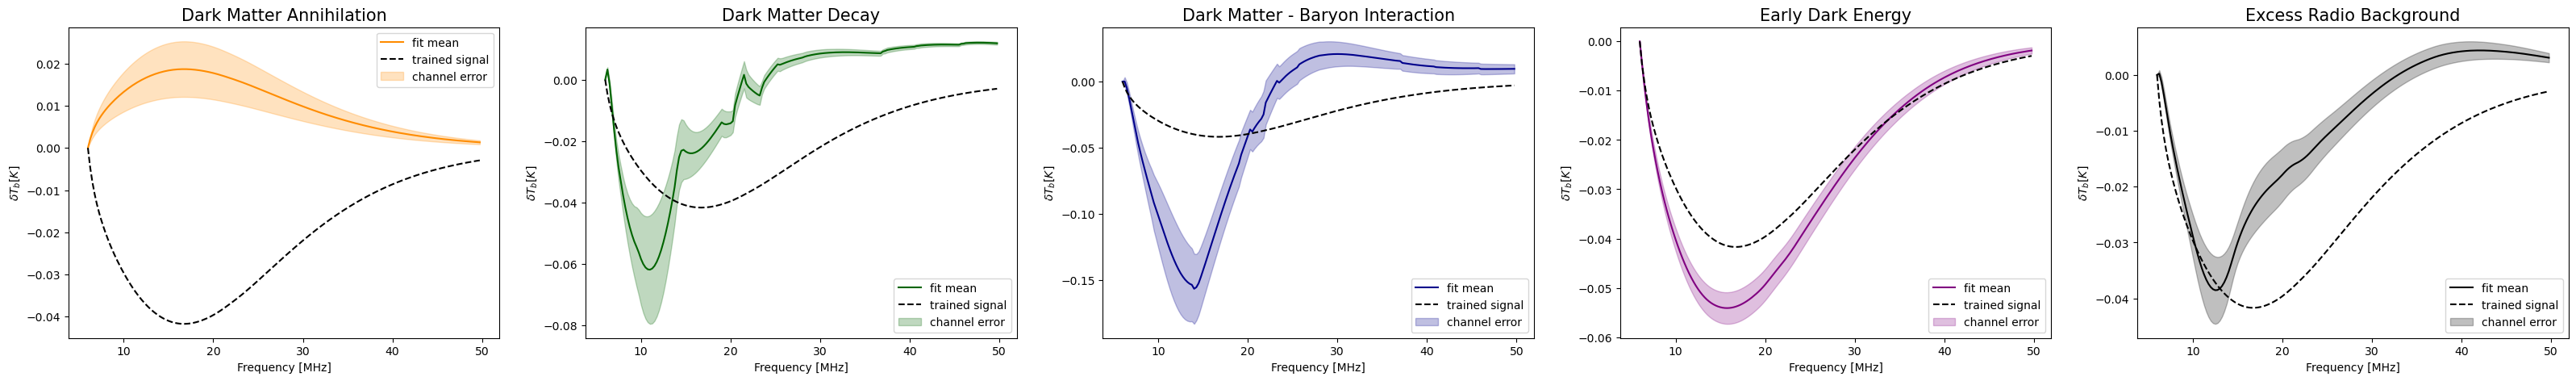

In [9]:
fig, ax = plt.subplots(1,5,figsize=(40, 5))
plt.subplot(1,5,1)
data = fitter2_DMAN.subbasis_channel_mean("Signal")
error = fitter2_DMAN.subbasis_channel_error("Signal")
plt.title("Dark Matter Annihilation",fontsize=15)
plt.plot(frequencies, data, label="fit mean",c="darkorange")
plt.plot(frequencies,fiducial_signal,c="black",ls="--",label="trained signal")
plt.fill_between(frequencies,data+error,data-error,alpha=0.25,label="channel error",color="darkorange")


plt.ylabel(r"$\delta T_b [K]$",fontsize=10)
plt.xlabel("Frequency [MHz]",fontsize=10)
plt.legend()

plt.subplot(1,5,2)
data = fitter2_DMD.subbasis_channel_mean("Signal")
error = fitter2_DMD.subbasis_channel_error("Signal")
plt.title("Dark Matter Decay",fontsize=15)
plt.plot(frequencies, data, label="fit mean",c="darkgreen")
plt.plot(frequencies,fiducial_signal,c="black",ls="--",label="trained signal")
plt.fill_between(frequencies,data+error,data-error,alpha=0.25,label="channel error",color="darkgreen")


plt.ylabel(r"$\delta T_b [K]$",fontsize=10)
plt.xlabel("Frequency [MHz]",fontsize=10)
plt.legend()

plt.subplot(1,5,3)
data = fitter2_MCDM.subbasis_channel_mean("Signal")
error = fitter2_MCDM.subbasis_channel_error("Signal")
plt.title("Dark Matter - Baryon Interaction",fontsize=15)
plt.plot(frequencies, data, label="fit mean",c="darkblue")
plt.plot(frequencies,fiducial_signal,c="black",ls="--",label="trained signal")
plt.fill_between(frequencies,data+error,data-error,alpha=0.25,label="channel error",color="darkblue")


plt.ylabel(r"$\delta T_b [K]$",fontsize=10)
plt.xlabel("Frequency [MHz]",fontsize=10)
plt.legend()

plt.subplot(1,5,4)
data = fitter2_EDE.subbasis_channel_mean("Signal")
error = fitter2_EDE.subbasis_channel_error("Signal")
plt.title("Early Dark Energy",fontsize=15)
plt.plot(frequencies, data, label="fit mean",c="purple")
plt.plot(frequencies,fiducial_signal,c="black",ls="--",label="trained signal")
plt.fill_between(frequencies,data+error,data-error,alpha=0.25,label="channel error",color="purple")


plt.ylabel(r"$\delta T_b [K]$",fontsize=10)
plt.xlabel("Frequency [MHz]",fontsize=10)
plt.legend()

plt.subplot(1,5,5)
data = fitter2_ERB.subbasis_channel_mean("Signal")
error = fitter2_ERB.subbasis_channel_error("Signal")
plt.title("Excess Radio Background",fontsize=15)
plt.plot(frequencies, data, label="fit mean",c="black")
plt.plot(frequencies,fiducial_signal,c="black",ls="--",label="trained signal")
plt.fill_between(frequencies,data+error,data-error,alpha=0.25,label="channel error",color="black")


plt.ylabel(r"$\delta T_b [K]$",fontsize=10)
plt.xlabel("Frequency [MHz]",fontsize=10)
plt.legend()

plt.savefig(save_path+"example_curves_for_SVD")

Minimizing DIC over grid.
number of foreground terms: 5
number of signal terms: 2
Minimizing DIC over grid.
number of foreground terms: 2
number of signal terms: 3
Minimizing DIC over grid.
number of foreground terms: 2
number of signal terms: 5
Minimizing DIC over grid.
number of foreground terms: 3
number of signal terms: 2
Minimizing DIC over grid.
number of foreground terms: 4
number of signal terms: 1


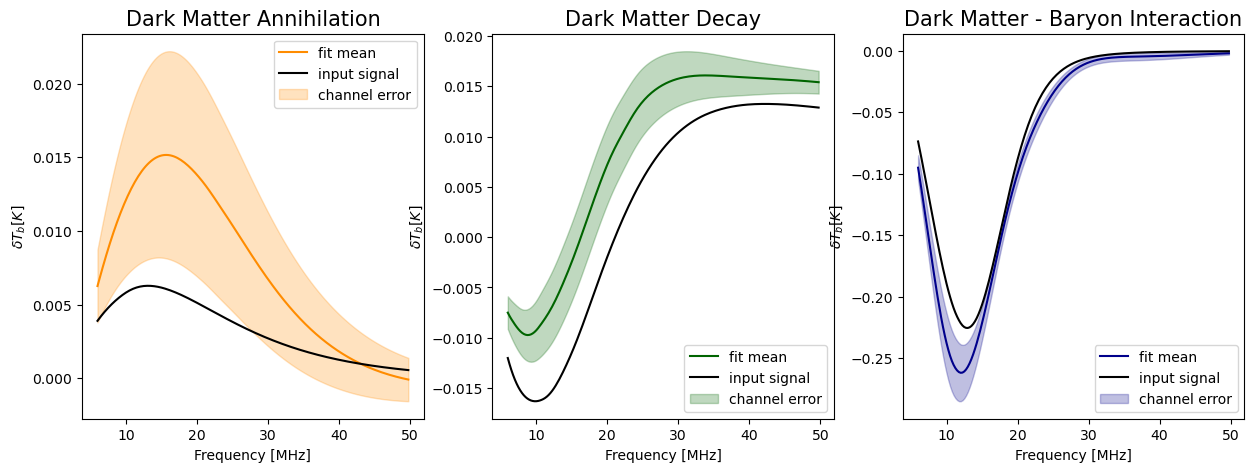

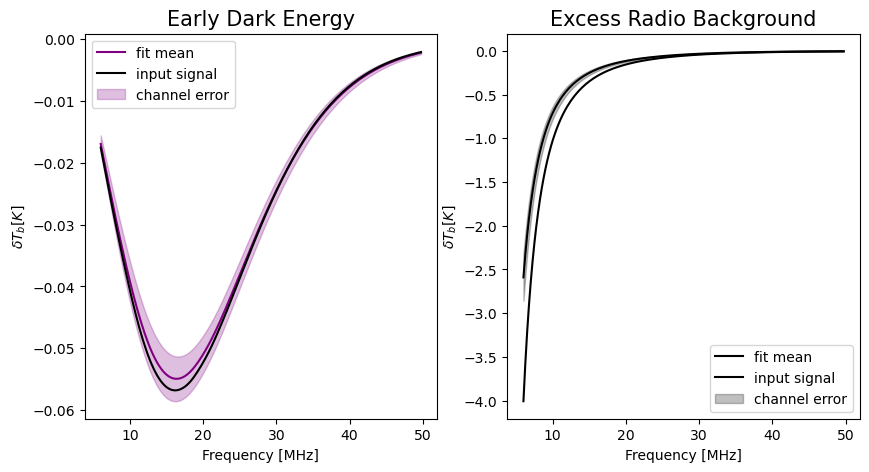

In [13]:
# Use this for the examples of bad stuff
#signal_training_set =   # Fill this out with the correct (or incorrect) signal training set
#sim_curves =  # 
sig_training_set = lambdaCDM_training_set
foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
sig_training_set = DMAN_training_set
IC = "DIC"
sim_data = DMAN_data[0]
noise_level = sigT(sim_data,1,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2_DMAN = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms_DMAN = fitter2_DMAN.sizes['Foreground']
num_signal_terms_DMAN = fitter2_DMAN.sizes['Signal']
print(f"number of foreground terms: {num_foreground_terms_DMAN}")
print(f"number of signal terms: {num_signal_terms_DMAN}")

foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
sig_training_set = DMD_training_set
IC = "DIC"
sim_data = DMD_data[20]
noise_level = sigT(sim_data,1,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2_DMD = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms_DMD = fitter2_DMD.sizes['Foreground']
num_signal_terms_DMD = fitter2_DMD.sizes['Signal']
print(f"number of foreground terms: {num_foreground_terms_DMD}")
print(f"number of signal terms: {num_signal_terms_DMD}")

foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
sig_training_set = MCDM_training_set
IC = "DIC"
sim_data = MCDM_data[0]
noise_level = sigT(sim_data,1,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2_MCDM = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms_MCDM = fitter2_MCDM.sizes['Foreground']
num_signal_terms_MCDM = fitter2_MCDM.sizes['Signal']
print(f"number of foreground terms: {num_foreground_terms_MCDM}")
print(f"number of signal terms: {num_signal_terms_MCDM}")

foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
sig_training_set = EDE_training_set
IC = "DIC"
sim_data = EDE_data[0]
noise_level = sigT(sim_data,1,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2_EDE = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms_EDE = fitter2_EDE.sizes['Foreground']
num_signal_terms_EDE = fitter2_EDE.sizes['Signal']
print(f"number of foreground terms: {num_foreground_terms_EDE}")
print(f"number of signal terms: {num_signal_terms_EDE}")

foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
sig_training_set = ERB_training_set
IC = "DIC"
sim_data = ERB_data[0]
noise_level = sigT(sim_data,1,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2_ERB = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms_ERB = fitter2_ERB.sizes['Foreground']
num_signal_terms_ERB = fitter2_ERB.sizes['Signal']
print(f"number of foreground terms: {num_foreground_terms_ERB}")
print(f"number of signal terms: {num_signal_terms_ERB}")


fig, ax = plt.subplots(1,3,figsize=(15, 5))
plt.subplot(1,3,1)
data = fitter2_DMAN.subbasis_channel_mean("Signal")
error = fitter2_DMAN.subbasis_channel_error("Signal")
plt.title("Dark Matter Annihilation",fontsize=15)
plt.plot(frequencies, data, label="fit mean",c="darkorange")
plt.plot(frequencies,DMAN_signal[0],c="black",label="input signal")
plt.fill_between(frequencies,data+error,data-error,alpha=0.25,label="channel error",color="darkorange")


plt.ylabel(r"$\delta T_b [K]$",fontsize=10)
plt.xlabel("Frequency [MHz]",fontsize=10)
plt.legend()

plt.subplot(1,3,2)
data = fitter2_DMD.subbasis_channel_mean("Signal")
error = fitter2_DMD.subbasis_channel_error("Signal")
plt.title("Dark Matter Decay",fontsize=15)
plt.plot(frequencies, data, label="fit mean",c="darkgreen")
plt.plot(frequencies,DMD_signal[20],c="black",label="input signal")
plt.fill_between(frequencies,data+error,data-error,alpha=0.25,label="channel error",color="darkgreen")


plt.ylabel(r"$\delta T_b [K]$",fontsize=10)
plt.xlabel("Frequency [MHz]",fontsize=10)
plt.legend()

plt.subplot(1,3,3)
data = fitter2_MCDM.subbasis_channel_mean("Signal")
error = fitter2_MCDM.subbasis_channel_error("Signal")
plt.title("Dark Matter - Baryon Interaction",fontsize=15)
plt.plot(frequencies, data, label="fit mean",c="darkblue")
plt.plot(frequencies,MCDM_signal[0],c="black",label="input signal")
plt.fill_between(frequencies,data+error,data-error,alpha=0.25,label="channel error",color="darkblue")
plt.ylabel(r"$\delta T_b [K]$",fontsize=10)
plt.xlabel("Frequency [MHz]",fontsize=10)
plt.legend()


fig, ax = plt.subplots(1,2,figsize=(10, 5))

plt.subplot(1,2,1)
data = fitter2_EDE.subbasis_channel_mean("Signal")
error = fitter2_EDE.subbasis_channel_error("Signal")
plt.title("Early Dark Energy",fontsize=15)
plt.plot(frequencies, data, label="fit mean",c="purple")
plt.plot(frequencies,EDE_signal[0],c="black",label="input signal")
plt.fill_between(frequencies,data+error,data-error,alpha=0.25,label="channel error",color="purple")


plt.ylabel(r"$\delta T_b [K]$",fontsize=10)
plt.xlabel("Frequency [MHz]",fontsize=10)
plt.legend()

plt.subplot(1,2,2)
data = fitter2_ERB.subbasis_channel_mean("Signal")
error = fitter2_ERB.subbasis_channel_error("Signal")
plt.title("Excess Radio Background",fontsize=15)
plt.plot(frequencies, data, label="fit mean",c="black")
plt.plot(frequencies,ERB_signal[0],c="black",label="input signal")
plt.fill_between(frequencies,data+error,data-error,alpha=0.25,label="channel error",color="black")


plt.ylabel(r"$\delta T_b [K]$",fontsize=10)
plt.xlabel("Frequency [MHz]",fontsize=10)
plt.legend()

plt.savefig(save_path+"example_curves_for_SVD")

In [ ]:
#DMAN = 

 20%|██        | 2/10 [00:00<00:01,  5.30it/s]

Minimizing DIC over grid.
number of foreground terms: 5
number of signal terms: 1
1
Minimizing DIC over grid.
number of foreground terms: 3
number of signal terms: 1
1


 40%|████      | 4/10 [00:00<00:01,  5.58it/s]

Minimizing DIC over grid.
number of foreground terms: 2
number of signal terms: 4
4
Minimizing DIC over grid.
number of foreground terms: 5
number of signal terms: 1
1


 50%|█████     | 5/10 [00:00<00:00,  5.61it/s]

Minimizing DIC over grid.
number of foreground terms: 5
number of signal terms: 3
3
Minimizing DIC over grid.
number of foreground terms: 5
number of signal terms: 1


 70%|███████   | 7/10 [00:01<00:00,  5.35it/s]

1
Minimizing DIC over grid.
number of foreground terms: 7
number of signal terms: 3
3


 80%|████████  | 8/10 [00:01<00:00,  5.33it/s]

Minimizing DIC over grid.
number of foreground terms: 4
number of signal terms: 1
1
Minimizing DIC over grid.
number of foreground terms: 1
number of signal terms: 8
8


100%|██████████| 10/10 [00:01<00:00,  5.36it/s]


Minimizing DIC over grid.
number of foreground terms: 5
number of signal terms: 1
1


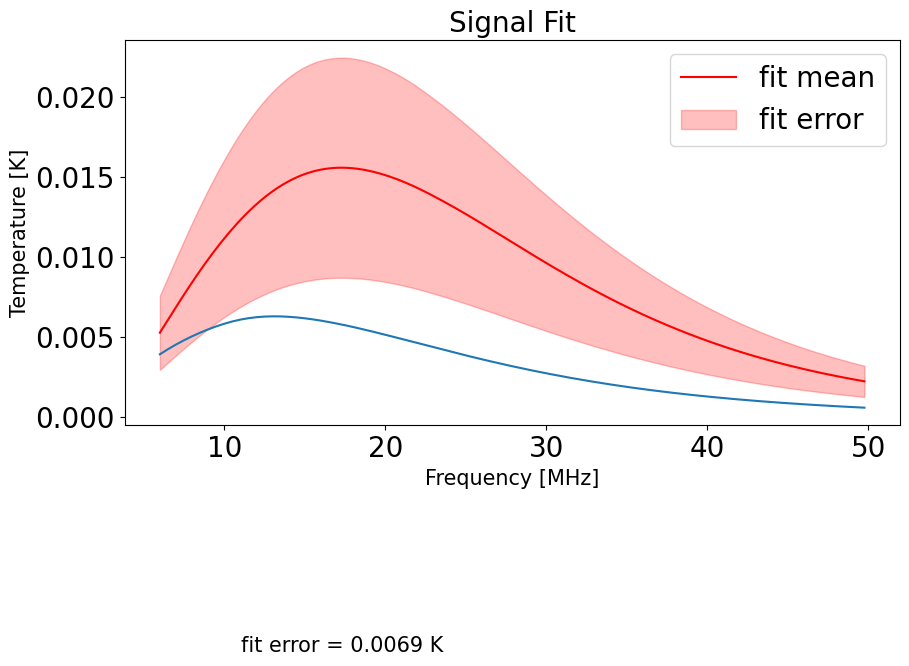

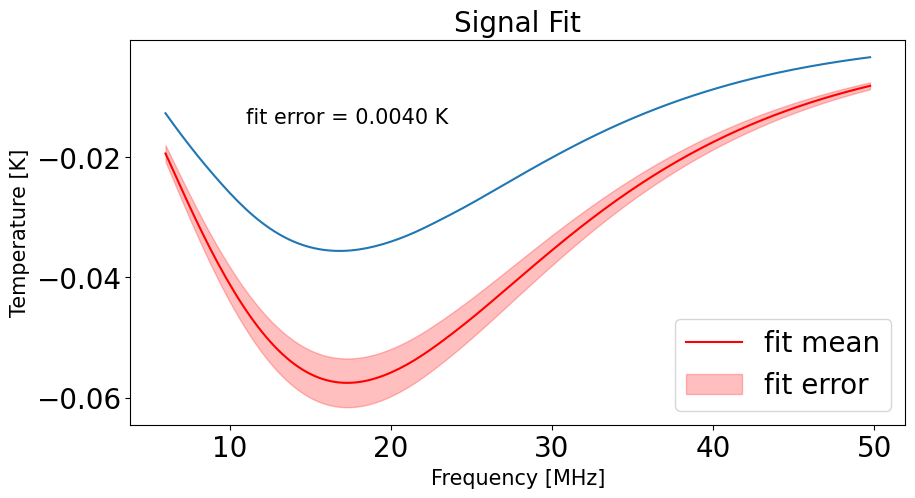

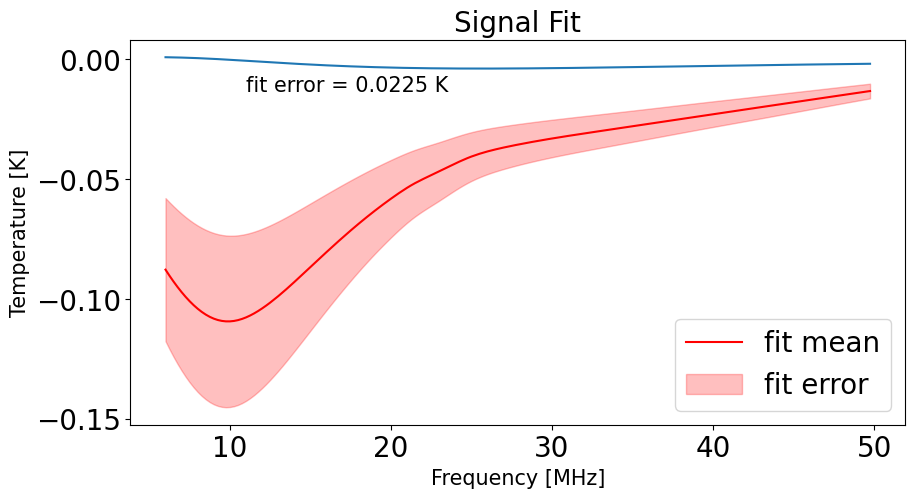

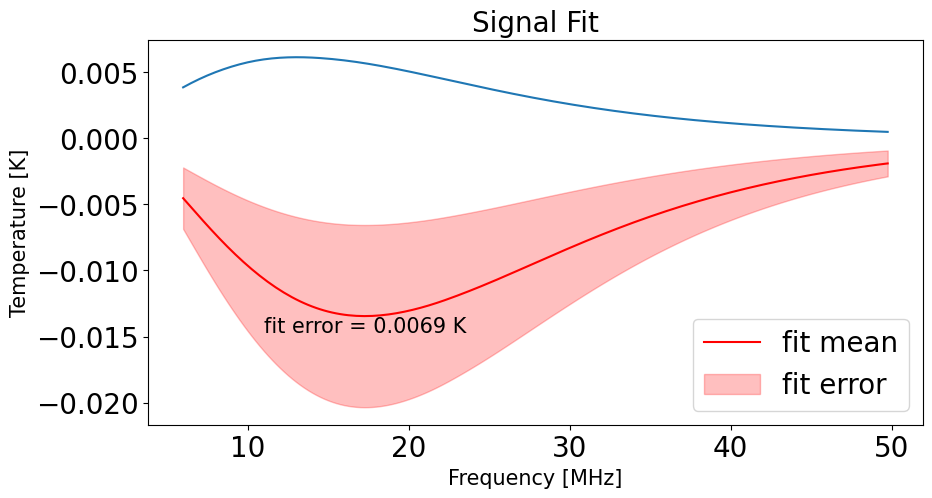

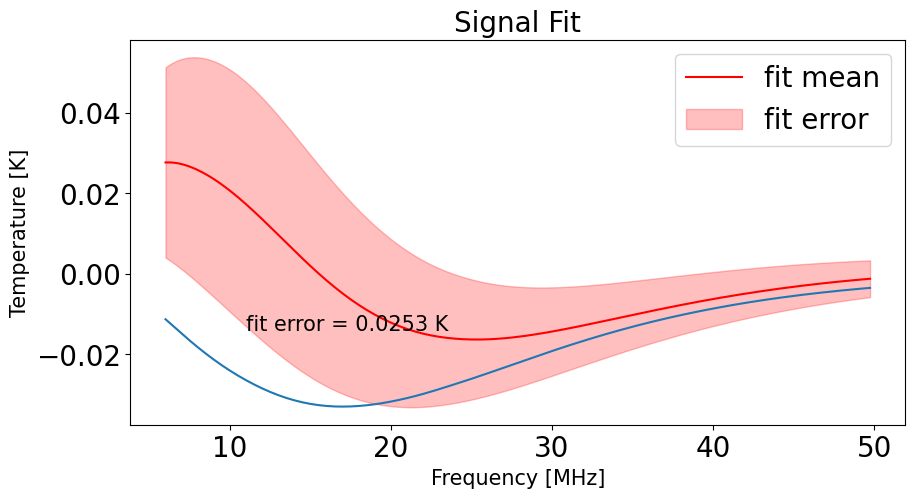

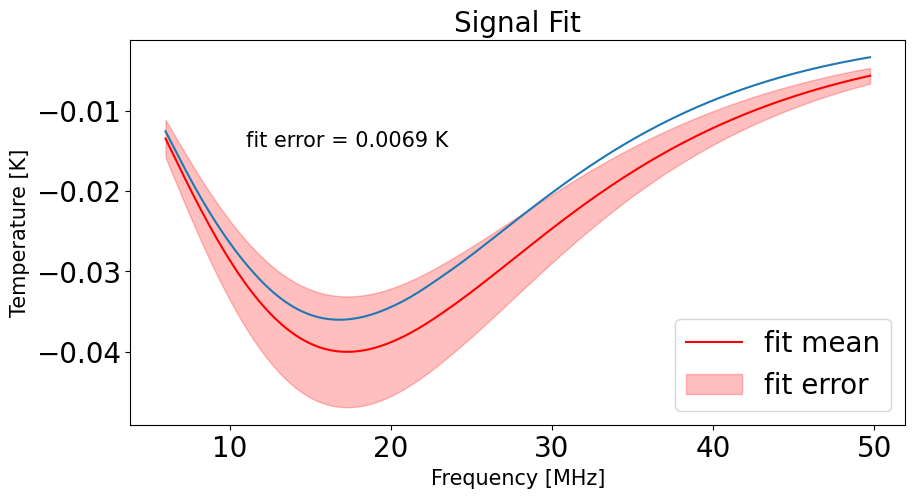

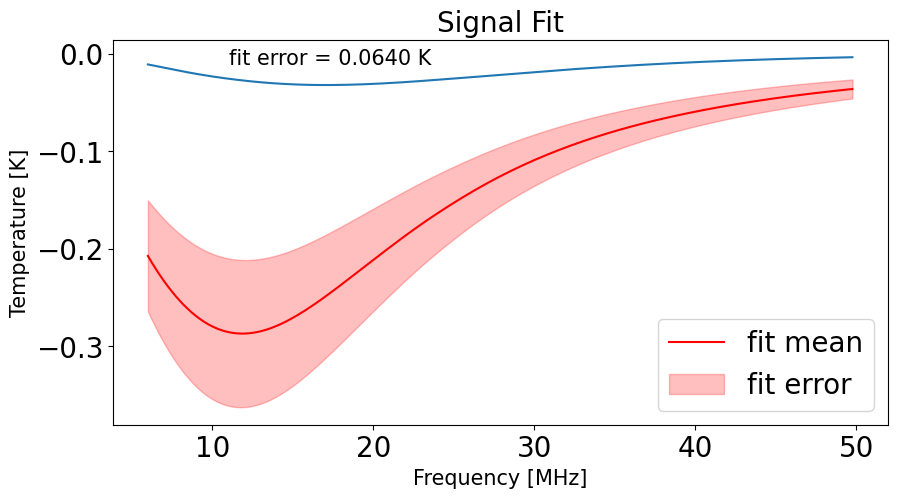

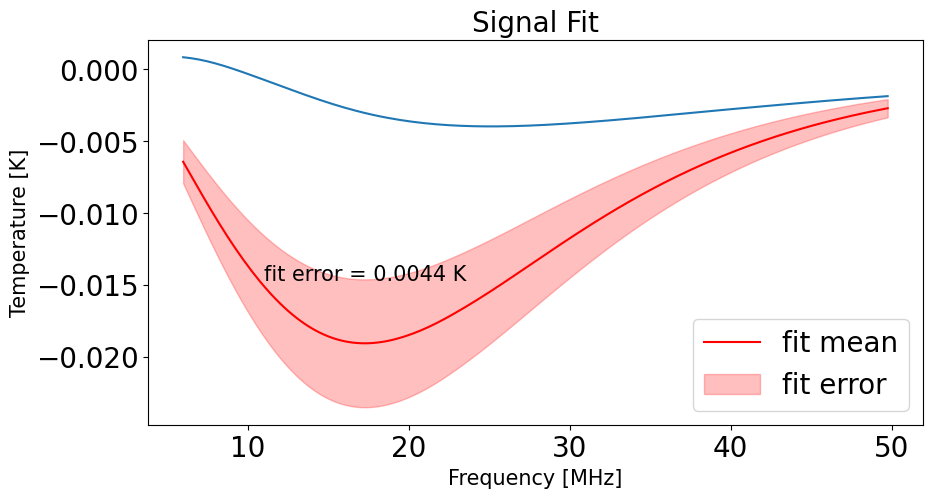

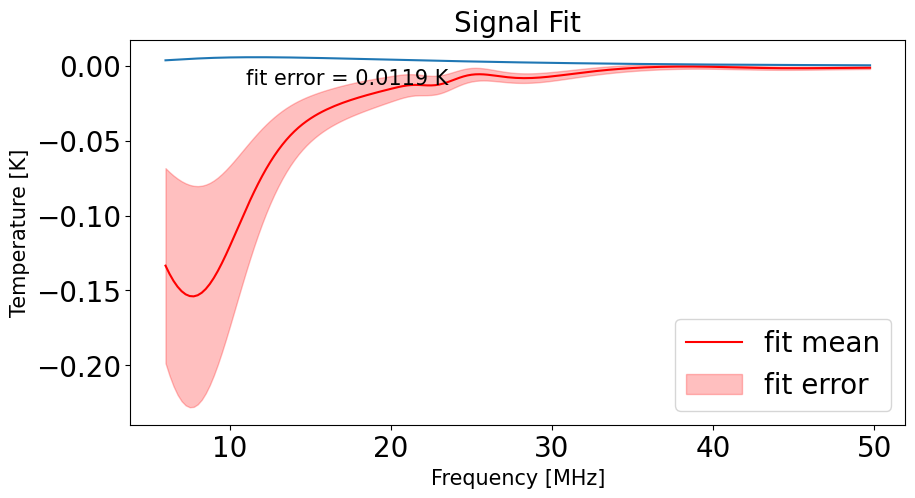

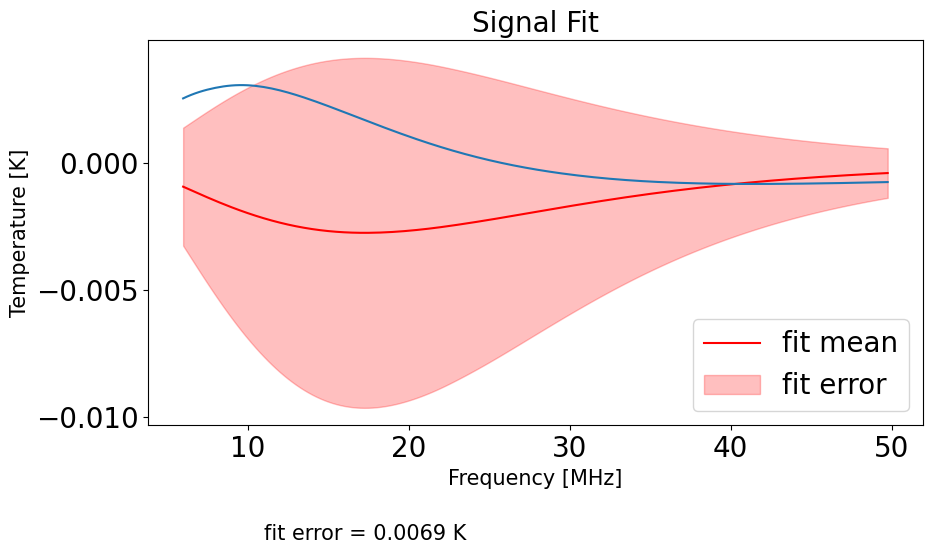

In [365]:
number = 0
for n in tqdm(range(10)):
    sig_training_set = DMAN_training_set
    foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
    sig_training_set
    IC = "DIC"
    sim_data = DMAN_data[n]
    noise_level = sigT(sim_data,1,dnu,dt)
    foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
    signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
    temperatures = sim_data
    basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
    quantity = AttributeQuantity(IC)
    dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
    # priors = {"Signal_prior" : signal_basis.gaussian_prior}
    meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
    fitter_test = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
    num_foreground_terms_DMAN = fitter_test.sizes['Foreground']
    num_signal_terms_DMAN = fitter_test.sizes['Signal']
    print(f"number of foreground terms: {num_foreground_terms_DMAN}")
    print(f"number of signal terms: {num_signal_terms_DMAN}")

    plt.figure(figsize=(10, 5))
    plt.plot(frequencies, fitter_test.subbasis_channel_mean("Signal"),label = "fit mean", c="red")
    plt.fill_between(frequencies, fitter_test.subbasis_channel_mean("Signal")+fitter_test.subbasis_channel_error("Signal"),fitter_test.subbasis_channel_mean("Signal")-fitter_test.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="red")
    plt.title("Signal Fit",fontsize=20)
    plt.xlabel("Frequency [MHz]",fontsize="15")
    plt.ylabel("Temperature [K]",fontsize="15")
    # plt.text(17, -0.01, f'fit mean = {fitter_test.subbasis_channel_mean("Signal")[43]:.2f} K', ha='center', va='bottom', fontsize=15)
    plt.text(17.3, -0.015, f'fit error = {fitter_test.subbasis_channel_error("Signal")[43]:.4f} K', ha='center', va='bottom', fontsize=15)
    # plt.plot(frequencies,[1],label="input signal",c="black")
    plt.legend()

    plt.plot(frequencies,DMAN_signal[n])

    print(num_signal_terms_DMAN)
    number += fitter_test.subbasis_channel_error("Signal").max()

average = number/10

In [292]:
average


0.33923770890667443

(1000,)

In [4]:
# Use this for the examples of bad stuff
#signal_training_set =   # Fill this out with the correct (or incorrect) signal training set
#sim_curves =  # 
sig_training_set = lambdaCDM_training_set
foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
sig_training_set
IC = "DIC"
sim_data = ERB_data[115]
noise_level = sigT(sim_data,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms_DMAN = fitter2.sizes['Foreground']
num_signal_terms_DMAN = fitter2.sizes['Signal']
print(f"number of foreground terms: {num_foreground_terms}")
print(f"number of signal terms: {num_signal_terms}")

foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
sig_training_set
IC = "DIC"
sim_data = DMD_test_sims[0]
noise_level = sigT(sim_data,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms_DMD = fitter2.sizes['Foreground']
num_signal_terms_DMD = fitter2.sizes['Signal']
print(f"number of foreground terms: {num_foreground_terms}")
print(f"number of signal terms: {num_signal_terms}")

foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
sig_training_set
IC = "DIC"
sim_data = MCDM_test_sims
noise_level = sigT(sim_data,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms_MCDM = fitter2.sizes['Foreground']
num_signal_terms_MCDM = fitter2.sizes['Signal']
print(f"number of foreground terms: {num_foreground_terms}")
print(f"number of signal terms: {num_signal_terms}")

foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
sig_training_set
IC = "DIC"
sim_data = EDE_test_sims[0]
noise_level = sigT(sim_data,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms_EDE = fitter2.sizes['Foreground']
num_signal_terms_EDE = fitter2.sizes['Signal']
print(f"number of foreground terms: {num_foreground_terms}")
print(f"number of signal terms: {num_signal_terms}")

foreground_training_set_array = curves_100_training_sets[0]  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
sig_training_set
IC = "DIC"
sim_data = ERB_test_sims[0]
noise_level = sigT(sim_data,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter2 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms_ERB = fitter2.sizes['Foreground']
num_signal_terms_ERB = fitter2.sizes['Signal']
print(f"number of foreground terms: {num_foreground_terms}")
print(f"number of signal terms: {num_signal_terms}")

NameError: name 'curves_100_training_sets' is not defined

7
1.4126775458487133


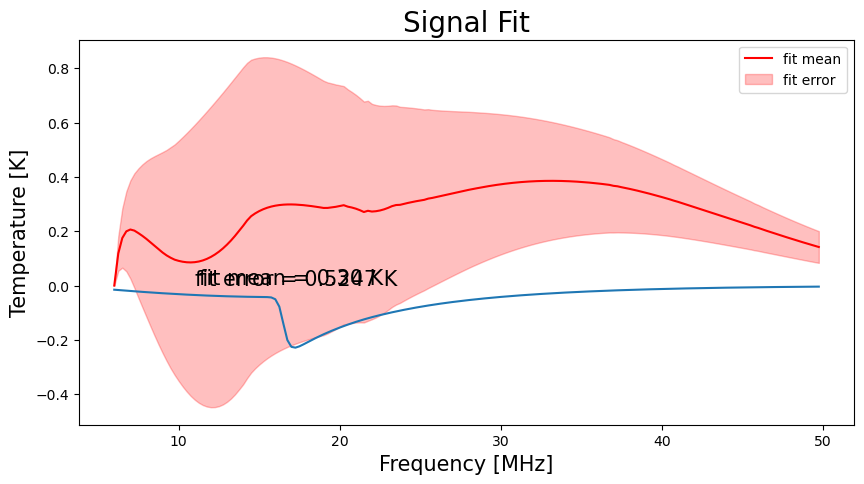

In [156]:

plt.figure(figsize=(10, 5))
plt.plot(frequencies, fitter2.subbasis_channel_mean("Signal"),label = "fit mean", c="red")
plt.fill_between(frequencies, fitter2.subbasis_channel_mean("Signal")+fitter2.subbasis_channel_error("Signal"),fitter2.subbasis_channel_mean("Signal")-fitter2.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="red")
plt.title("Signal Fit",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Temperature [K]",fontsize="15")
plt.text(17, -0.01, f'fit mean = {fitter2.subbasis_channel_mean("Signal")[43]:.2f} K', ha='center', va='bottom', fontsize=15)
plt.text(17.3, -0.015, f'fit error = {fitter2.subbasis_channel_error("Signal")[43]:.4f} K', ha='center', va='bottom', fontsize=15)
# plt.plot(frequencies,[1],label="input signal",c="black")
plt.legend()

plt.plot(frequencies,ERB_signal[115])

print(num_signal_terms_DMAN)
print(fitter2.reduced_chi_squared)

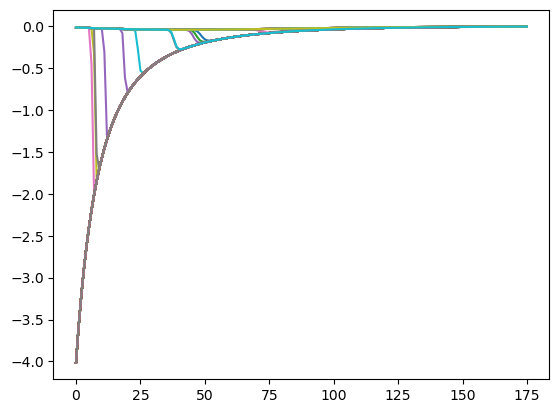

In [137]:
for n in range(100):
    plt.plot(ERB_signal[n]) 

In [26]:
num_signal_terms_DMAN

3

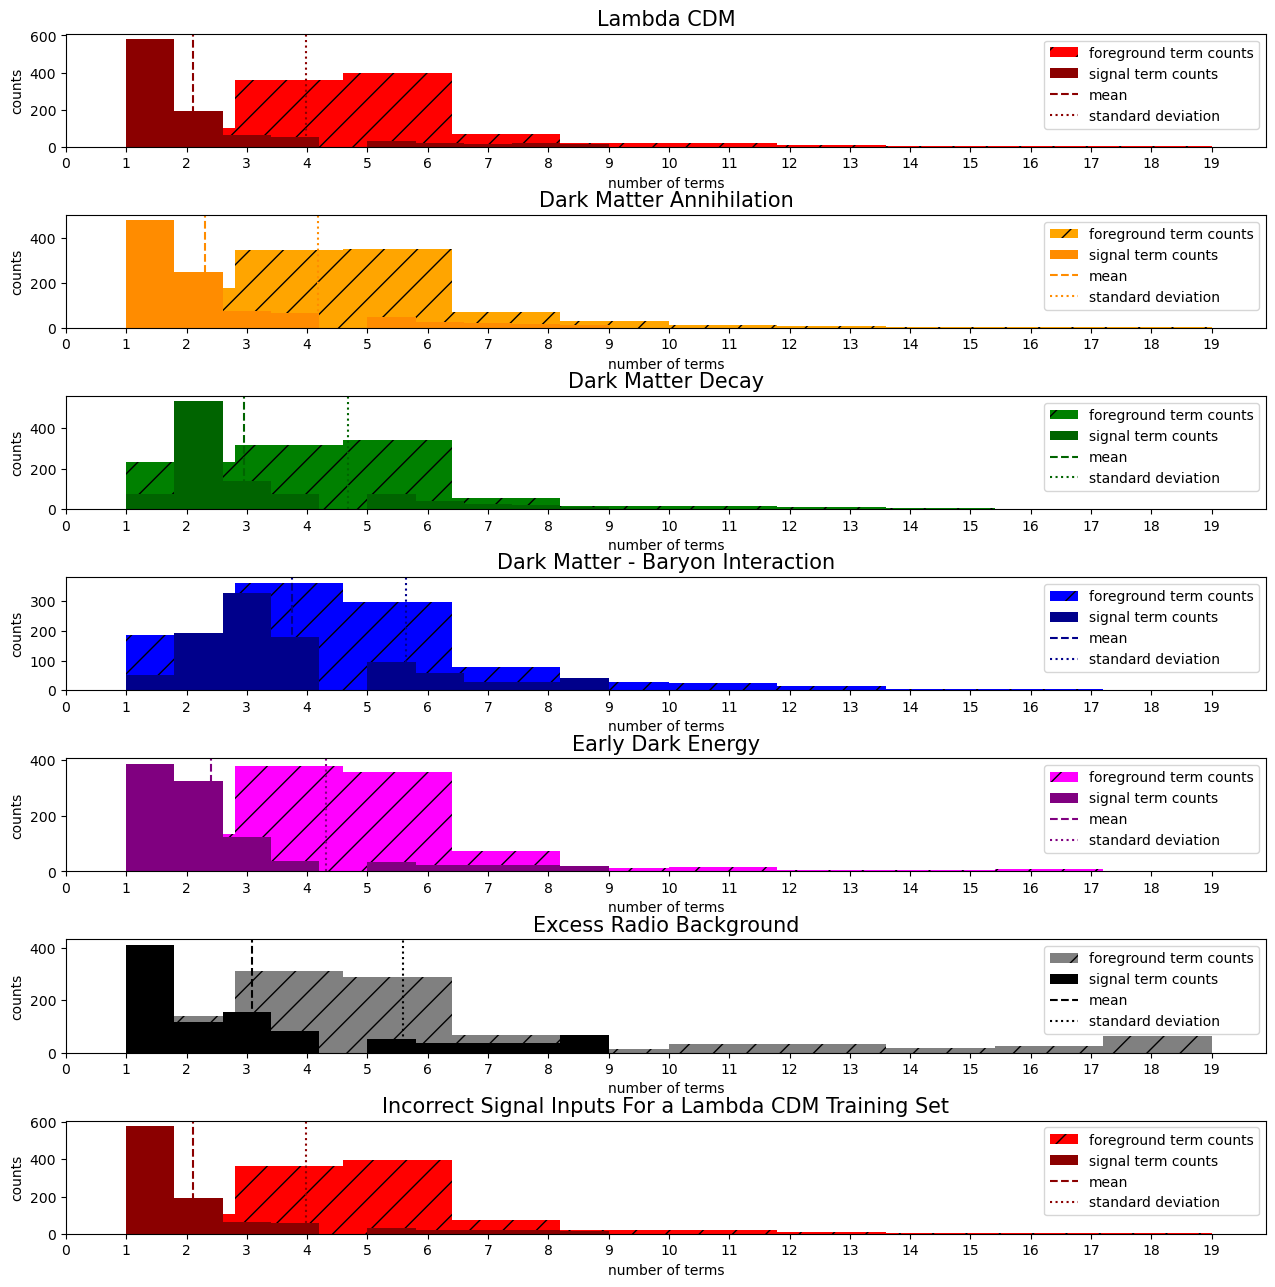

In [7]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7) = plt.subplots(7,1,figsize=(15, 15))

plt.subplot(7,1,1)
plt.title("Lambda CDM",fontsize=15)
plt.hist(CDM_foreground_terms, label="foreground term counts",color="red",hatch="/")
mean= CDM_foreground_terms.mean()
std= CDM_foreground_terms.std()
ranger = np.arange(0,int(CDM_foreground_terms.max())+10,0.1)
plt.hist(CDM_signal_terms,bins=10, label="signal term counts",color="darkred")
mean= CDM_signal_terms.mean()
std= CDM_signal_terms.std()
ranger = np.arange(0,int(CDM_signal_terms.max())+10,0.1)
plt.axvline(mean,color="darkred",ls="--",label="mean")
plt.axvline(std+mean,color="darkred",ls=":",label="standard deviation")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.xticks(np.arange(20))
plt.legend()


plt.subplot(7,1,2)
plt.title("Dark Matter Annihilation",fontsize=15)
plt.hist(DMAN_foreground_terms, label="foreground term counts",color="orange",hatch="/")
mean= DMAN_foreground_terms.mean()
std= DMAN_foreground_terms.std()
ranger = np.arange(0,int(DMAN_foreground_terms.max())+10,0.1)
plt.hist(DMAN_signal_terms,bins=10, label="signal term counts",color="darkorange")
mean= DMAN_signal_terms.mean()
std= DMAN_signal_terms.std()
ranger = np.arange(0,int(DMAN_signal_terms.max())+10,0.1)
plt.axvline(mean,color="darkorange",ls="--",label="mean")
plt.axvline(std+mean,color="darkorange",ls=":",label="standard deviation")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.xticks(np.arange(20))
plt.legend()

plt.subplot(7,1,3)
plt.title("Dark Matter Decay",fontsize=15)
plt.hist(DMD_foreground_terms, label="foreground term counts",color="green",hatch="/")
mean= DMD_foreground_terms.mean()
std= DMD_foreground_terms.std()
ranger = np.arange(0,int(DMD_foreground_terms.max())+10,0.1)
plt.hist(DMD_signal_terms,bins=10, label="signal term counts",color="darkgreen")
mean= DMD_signal_terms.mean()
std= DMD_signal_terms.std()
ranger = np.arange(0,int(DMD_signal_terms.max())+10,0.1)
plt.axvline(mean,color="darkgreen",ls="--",label="mean")
plt.axvline(std+mean,color="darkgreen",ls=":",label="standard deviation")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.xticks(np.arange(20))
plt.legend()

plt.subplot(7,1,4)
plt.title("Dark Matter - Baryon Interaction",fontsize=15)
plt.hist(MCDM_foreground_terms, label="foreground term counts",color="blue",hatch="/")
mean= MCDM_foreground_terms.mean()
std= MCDM_foreground_terms.std()
ranger = np.arange(0,int(MCDM_foreground_terms.max())+10,0.1)
plt.hist(MCDM_signal_terms,bins=10, label="signal term counts",color="darkblue")
mean= MCDM_signal_terms.mean()
std= MCDM_signal_terms.std()
ranger = np.arange(0,int(MCDM_signal_terms.max())+10,0.1)
plt.axvline(mean,color="darkblue",ls="--",label="mean")
plt.axvline(std+mean,color="darkblue",ls=":",label="standard deviation")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.xticks(np.arange(20))
plt.legend()

plt.subplot(7,1,5)
plt.title("Early Dark Energy",fontsize=15)
plt.hist(EDE_foreground_terms, label="foreground term counts",color="magenta",hatch="/")
mean= EDE_foreground_terms.mean()
std= EDE_foreground_terms.std()
ranger = np.arange(0,int(EDE_foreground_terms.max())+10,0.1)
plt.hist(EDE_signal_terms,bins=10, label="signal term counts",color="purple")
mean= EDE_signal_terms.mean()
std= EDE_signal_terms.std()
ranger = np.arange(0,int(EDE_signal_terms.max())+10,0.1)
plt.axvline(mean,color="purple",ls="--",label="mean")
plt.axvline(std+mean,color="purple",ls=":",label="standard deviation")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.xticks(np.arange(20))
plt.legend()

plt.subplot(7,1,6)
plt.title("Excess Radio Background",fontsize=15)
plt.hist(ERB_foreground_terms, label="foreground term counts",color="gray",hatch="/")
mean= ERB_foreground_terms.mean()
std= ERB_foreground_terms.std()
ranger = np.arange(0,int(ERB_foreground_terms.max())+10,0.1)
plt.hist(ERB_signal_terms,bins=10, label="signal term counts",color="black")
mean= ERB_signal_terms.mean()
std= ERB_signal_terms.std()
ranger = np.arange(0,int(ERB_signal_terms.max())+10,0.1)
plt.axvline(mean,color="black",ls="--",label="mean")
plt.axvline(std+mean,color="black",ls=":",label="standard deviation")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.xticks(np.arange(20))
plt.legend()

plt.subplot(7,1,7)
plt.title("Incorrect Signal Inputs For a Lambda CDM Training Set",fontsize=15)
plt.hist(CDM_foreground_terms, label="foreground term counts",color="red",hatch="/")
mean= CDM_foreground_terms.mean()
std= CDM_foreground_terms.std()
ranger = np.arange(0,int(CDM_foreground_terms.max())+10,0.1)
plt.hist(CDM_signal_terms,bins=10, label="signal term counts",color="darkred")
mean= CDM_signal_terms.mean()
std= CDM_signal_terms.std()
ranger = np.arange(0,int(CDM_signal_terms.max())+10,0.1)
plt.axvline(mean,color="darkred",ls="--",label="mean")
plt.axvline(std+mean,color="darkred",ls=":",label="standard deviation")
plt.ylabel("counts",fontsize=10)
plt.xlabel("number of terms",fontsize=10)
plt.xticks(np.arange(20))
plt.legend()

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.4, hspace=0.6)

# plt.savefig(save_path+"SVD_trainingset_test")

In [44]:
np.array(CDM_signal_terms).mean()

2.105

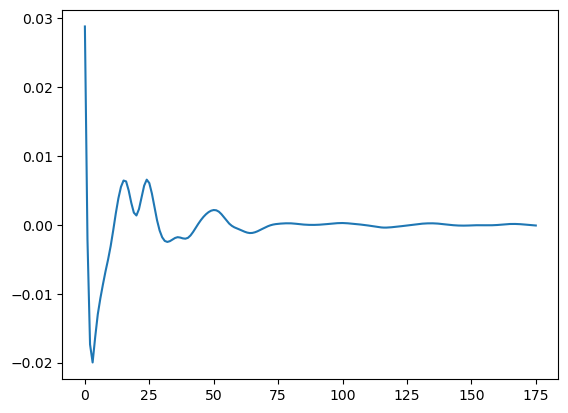

In [169]:
plt.plot(foreground_basis.basis[10])

## Simple Extraction Using only Smooth Foregrounds

Minimizing DIC over grid.
number of foreground terms: 6
number of signal terms: 1


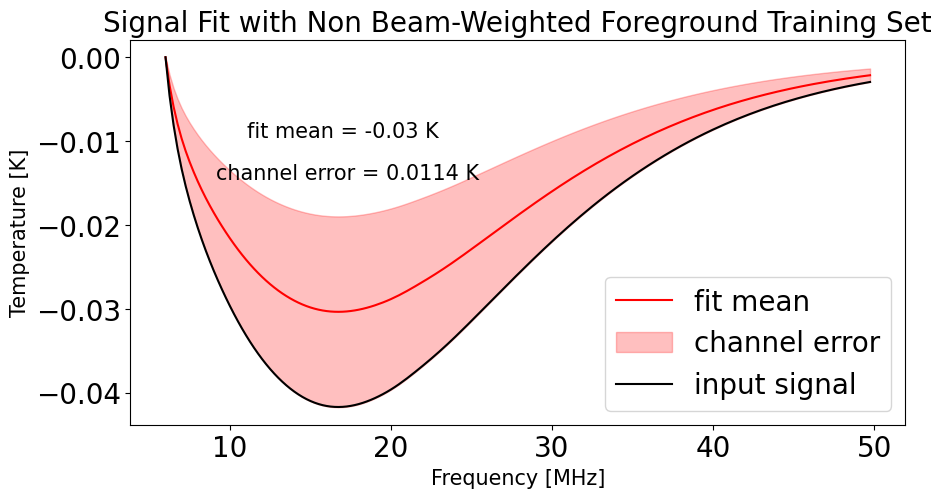

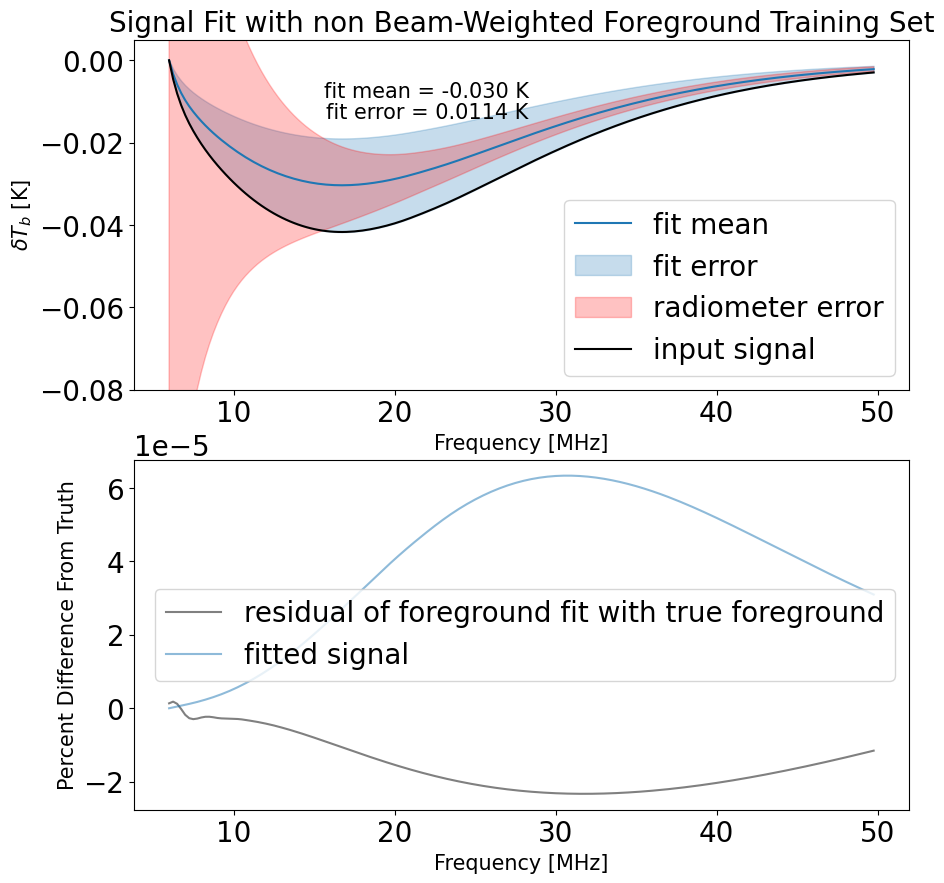

In [204]:
sim_data_smooth = py21cmsig.simulation_run(foreground_training_set[0],lambdaCDM_training_set[0],N_antenna,dnu,dt)
sig_training_set = lambdaCDM_training_set
foreground_training_set_array = foreground_training_set  # this index convention only works if there are 100 foregrounds and some multiple of 100 signals (such as 1000)
IC = "DIC"
sim_data = sim_data_smooth[0]
noise_level = sigT(sim_data,N_antenna,dnu,dt)
noise = noise_level
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=100,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=20,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,100)}, {'Signal' : np.arange(1,20)}]  
priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))
num_foreground_terms = fitter.sizes['Foreground']
num_signal_terms = fitter.sizes['Signal']
print(f"number of foreground terms: {num_foreground_terms}")
print(f"number of signal terms: {num_signal_terms}")

plt.figure(figsize=(10, 5))
plt.plot(frequencies, fitter.subbasis_channel_mean("Signal"),label = "fit mean", c="red")
plt.fill_between(frequencies, fitter.subbasis_channel_mean("Signal")+fitter.subbasis_channel_error("Signal"),fitter.subbasis_channel_mean("Signal")-fitter.subbasis_channel_error("Signal"),label="channel error",alpha=0.25,color="red")
plt.title("Signal Fit with Non Beam-Weighted Foreground Training Set",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Temperature [K]",fontsize="15")
plt.text(17, -0.01, f'fit mean = {fitter.subbasis_channel_mean("Signal")[43]:.2f} K', ha='center', va='bottom', fontsize=15)
plt.text(17.3, -0.015, f'channel error = {fitter.subbasis_channel_error("Signal")[43]:.4f} K', ha='center', va='bottom', fontsize=15)
plt.plot(frequencies,simulation_test_beam[1],label="input signal",c="black")
plt.legend()
# # plt.savefig(save_path+"non_BW_extraction")

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 10))

plt.subplot(2,1,1)
plt.plot(frequencies, fitter.subbasis_channel_mean("Signal"),label = "fit mean", c="tab:blue")
plt.fill_between(frequencies, fitter.subbasis_channel_mean("Signal")+fitter.subbasis_channel_error("Signal"),fitter.subbasis_channel_mean("Signal")-fitter.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="tab:blue")
plt.fill_between(frequencies, fitter.subbasis_channel_mean("Signal")+noise,fitter.subbasis_channel_mean("Signal")-noise,label="radiometer error",alpha=0.24,color="red")
plt.title("Signal Fit with non Beam-Weighted Foreground Training Set",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel(r"$\delta T_b$ [K]",fontsize="15")
plt.text(22, -0.01, f'fit mean = {fitter.subbasis_channel_mean("Signal")[43]:.3f} K', ha='center', va='bottom', fontsize=15)
plt.text(22, -0.015, f'fit error = {fitter.subbasis_channel_error("Signal")[43]:.4f} K', ha='center', va='bottom', fontsize=15)
plt.plot(frequencies,simulation_test_beam[1],label="input signal",c="black")
plt.ylim(-0.08,0.005)
plt.legend()


plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter.subbasis_channel_mean("Foreground")[0:len(frequencies)]-sim_data_smooth[2]))/sim_data_smooth[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,-fitter.subbasis_channel_mean("Signal")/sim_data_smooth[2]*100,c="tab:blue",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Percent Difference From Truth",fontsize="15")
plt.legend()

# plt.savefig(save_path+"Simple_extraction")

In [213]:
np.sqrt(((fitter.subbasis_channel_error("Signal")**2).sum())/len(frequencies))*bias_scores[5].mean()

0.012580923347216362

## Bad Extraction with Degeneracy Plot

In [11]:


## Creates a foreground for the simulation:
dt = 10000*3600
# custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
# parameter_variation = [0.05,0.025,0.05]                           # For making a random foreground
custom_parameter_range = np.array([[1,1],[3.4,3.4],[4.6,4.6]])
parameter_variation = [0,0,0]

signal_model = fiducial_signal

## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 2 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=False)

BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 1
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation, B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)
foreground_for_sim = foreground_run[3][0]
parameters_for_sim = foreground_run[4][0]

# Our simulation function
simulation_test_beam = py21cmsig.simulation_run(foreground_for_sim,signal_model,N_antenna,dnu,dt)

## Creates a training set with varied beams:

custom_parameter_range = np.array([[0.5,3],[3.2,4.2],[3.8,4.8]])  # For making a random foreground
parameter_variation = [0.05,0.025,0.05]                                  # For making a random foreground
rms_mean = 0.05
rms_std = 0.009
## Interpolate the varied beams to match the rest of the data
varied_regolith_training_set = np.zeros((len(varied_regolith_training_set_raw),len(frequencies)))
for n in range(len(varied_regolith_training_set_raw)):
    beam_regolith_interp = scipy.interpolate.CubicSpline(range(1,51),varied_regolith_training_set_raw[n,0,:])
    varied_regolith_training_set[n] = beam_regolith_interp(frequencies)
Nb = 500 # number of beams in the beam training set
exp_test=py21cmsig.expanded_training_set_no_t(varied_regolith_training_set,varied_regolith_training_set_raw_params,Nb,\
                               custom_parameter_range,show_parameter_ranges=True)
n_regions = 5
reference_frequency = 25
sky_map = foreground_array_minCMB[0]
BTS_curves = exp_test[0]
BTS_params = exp_test[1]
beam_sky_training_set = beams[:,5:,:]
beam_sky_training_set_params = varied_regolith_training_set_raw_params
raw_beam_weighted_sky_maps = raw_sky_maps
N = 500
# parameter_variation = [0.05,0.025,0.05]
determine_parameter_range = True
new_FG_parameter_mean = None
foreground_run_set = py21cmsig.synchrotron_foreground_forsigex(n_regions,frequencies,reference_frequency,sky_map,BTS_curves,BTS_params,\
                                    beam_sky_training_set,beam_sky_training_set_params,N,parameter_variation,B_value_functions,\
                                        define_parameter_mean=False,parameter_mean=new_FG_parameter_mean)

foreground_training_set_array = foreground_run_set[3]
sig_training_set = lambdaCDM_training_set
IC = "DIC"
sim = simulation_test_beam
sim_data = sim[0]
noise_level = sigT(sim_data,N_antenna,dnu,dt)
foreground_basis = TrainedBasis(training_set=foreground_training_set_array, num_basis_vectors=20,error=noise_level)
signal_basis = TrainedBasis(training_set=sig_training_set, num_basis_vectors=10,error=noise_level)
temperatures = sim_data
basis_sum = BasisSum(["Foreground","Signal"],[foreground_basis, signal_basis])
quantity = AttributeQuantity(IC)
dimension = [{'Foreground' : np.arange(1,20)}, {'Signal' : np.arange(1,10)}]  
# priors = {"Signal_prior" : signal_basis.gaussian_prior}
meta_fitter = MetaFitter(basis_sum, temperatures, noise_level, quantity, quantity.name, *dimension)
fitter3 = meta_fitter.fitter_from_indices(meta_fitter.minimize_quantity(IC))




100%|██████████| 2/2 [00:00<00:00, 4758.14it/s]


[0, 0, 0]


100%|██████████| 176/176 [00:01<00:00, 105.93it/s]


[[0.5 3. ]
 [3.2 4.2]
 [3.8 4.8]]


100%|██████████| 500/500 [00:02<00:00, 226.76it/s]


[0.05, 0.025, 0.05]
Minimizing DIC over grid.


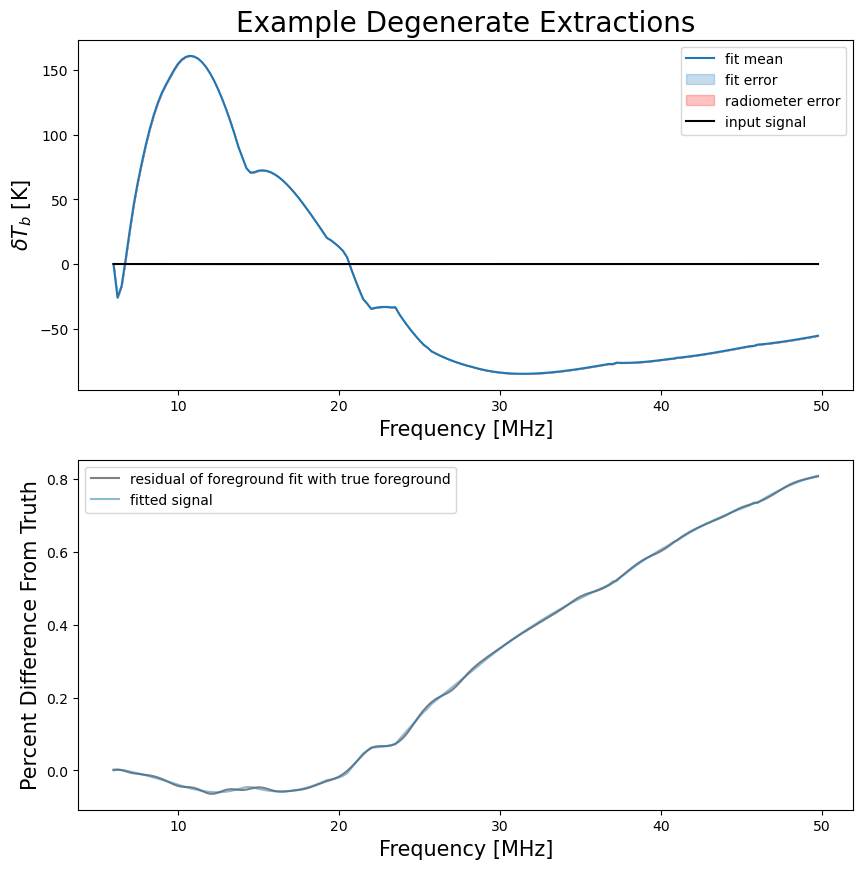

In [12]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 10))

noise = sigT(simulation_test_beam[0],N_antenna,dnu,10000*3600)
plt.subplot(2,1,1)
plt.plot(frequencies, fitter3.subbasis_channel_mean("Signal"),label = "fit mean", c="tab:blue")
plt.fill_between(frequencies, fitter3.subbasis_channel_mean("Signal")+fitter3.subbasis_channel_error("Signal"),fitter3.subbasis_channel_mean("Signal")-fitter3.subbasis_channel_error("Signal"),label="fit error",alpha=0.25,color="tab:blue")
plt.fill_between(frequencies, fitter3.subbasis_channel_mean("Signal")+noise,fitter3.subbasis_channel_mean("Signal")-noise,label="radiometer error",alpha=0.24,color="red")
plt.title("Example Degenerate Extractions",fontsize=20)
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel(r"$\delta T_b$ [K]",fontsize="15")
# plt.text(22, 30, f'fit mean = {fitter3.subbasis_channel_mean("Signal")[43]:.3f} K', ha='center', va='bottom', fontsize=15)
# plt.text(22, 20, f'radiometer error = {noise[43]:.4f} K', ha='center', va='bottom', fontsize=15)
plt.plot(frequencies,simulation_test_beam[1],label="input signal",c="black")
plt.legend()
# plt.ylim(-0.06,0.005)


plt.subplot(2,1,2)
plt.title("")
plt.plot(frequencies,((fitter3.subbasis_channel_mean("Foreground")[0:len(frequencies)]-sim[2]))/sim[2]*100,c="grey",label="residual of foreground fit with true foreground")
plt.plot(frequencies,-fitter3.subbasis_channel_mean("Signal")/sim[2]*100,c="tab:blue",alpha=0.5,label="fitted signal")
plt.xlabel("Frequency [MHz]",fontsize="15")
plt.ylabel("Percent Difference From Truth",fontsize="15")
plt.legend()

plt.savefig(save_path+"Bad_extraction")

In [ ]:
fitter3.

## Example Beams Through A Few Frequencies

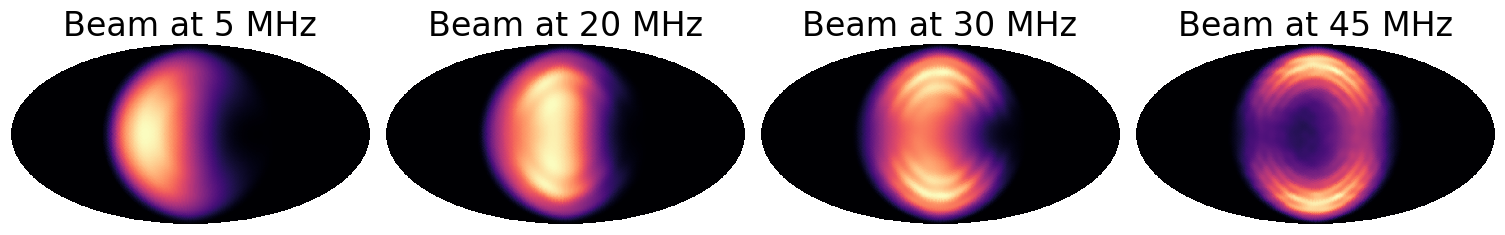

In [313]:



f = h5py.File("/home/dbarker7752/21_cm_group/normalized_beams_64","r")
beams_64 = f["normalized_beams"]
### End loading code 
cmaps = ['viridis', 'plasma', 'inferno', 'magma', 'cividis']
cmap = cmaps[3]

fig = plt.figure(figsize=(15, 15))

hp.mollview(beams_64[0][5], cbar=False,cmap=cmap,sub=(1,4,1),title="Beam at 5 MHz")
hp.mollview(beams_64[0][20], cbar=False,cmap=cmap,sub=(1,4,2),title="Beam at 20 MHz")
hp.mollview(beams_64[0][30], cbar=False,cmap=cmap,sub=(1,4,3),title="Beam at 30 MHz")
hp.mollview(beams_64[0][45], cbar=False,cmap=cmap,sub=(1,4,4),title="Beam at 45 MHz")
plt.savefig(save_path+"Several_Beam_Example")

plt.show()



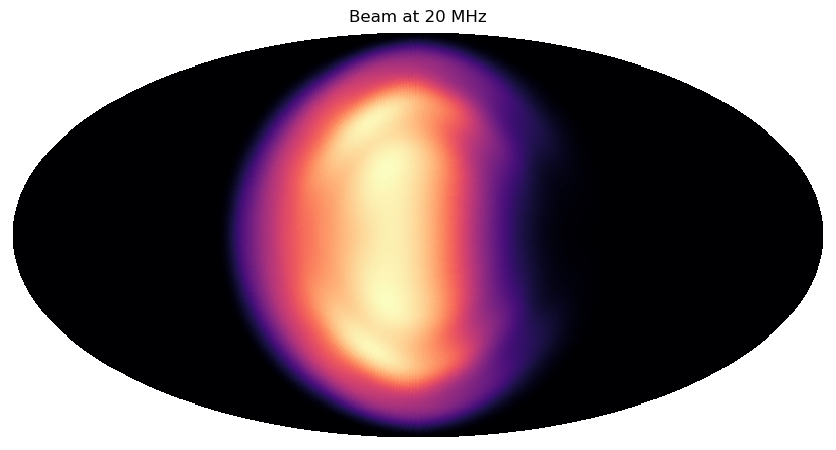

In [15]:
hp.mollview(beams_64[0][20], cbar=False,cmap=cmap,title="Beam at 20 MHz")

In [7]:
beams_64.shape


# # For comparison between the interpolator and the actual values
# n=25776
# t = 38376

# fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# # Set theta = 0 at the top (North)
# ax.set_theta_zero_location('N')
# #plt.polar(test_beam_raw[0].transpose()[0][n:n+179]*(np.pi/180),test_beam_raw[0].transpose()[2][n:n+179])
# #plt.polar(test_beam_raw[0].transpose()[0][t:t+179]*(np.pi/180),test_beam_raw[0].transpose()[2][t:t+179])
# theta = np.arange(0,180,0.1)
# phi = np.ones_like(theta)*0
# plt.polar(theta*(np.pi/180),test_beam_raw[2]((np.array([phi,theta]).transpose())),label="Parallel Dipole NS @ 60MHz",c='blue')
# plt.polar(-theta*(np.pi/180),test_beam_raw[2]((np.array([phi,theta]).transpose())),c="blue")
# plt.xlabel("Altitude Angle (Theta)")

# plt.legend()

(221, 50, 49152)

In [319]:
beam0=fits.open(files[0])
labels= ["E-W cut","NE-SW cut","N-S cut","NW-SE cut"]


In [322]:
n=4  # 5MHz
beam0_polar_5MHz_N=(beam0[8].data[n] / beam0[8].data[n].sum())[:,0]
beam0_polar_5MHz_S=(beam0[8].data[n] / beam0[8].data[n].sum())[:,180]
beam0_polar_5MHz_NE=(beam0[8].data[n] / beam0[8].data[n].sum())[:,45]
beam0_polar_5MHz_SW=(beam0[8].data[n] / beam0[8].data[n].sum())[:,225]
beam0_polar_5MHz_E=(beam0[8].data[n] / beam0[8].data[n].sum())[:,90]
beam0_polar_5MHz_W=(beam0[8].data[n] / beam0[8].data[n].sum())[:,270]
beam0_polar_5MHz_SE=(beam0[8].data[n] / beam0[8].data[n].sum())[:,135]
beam0_polar_5MHz_NW=(beam0[8].data[n] / beam0[8].data[n].sum())[:,135]

n=19  #20 MHz
beam0_polar_20MHz_N=(beam0[8].data[n] / beam0[8].data[n].sum())[:,0]
beam0_polar_20MHz_S=(beam0[8].data[n] / beam0[8].data[n].sum())[:,180]
beam0_polar_20MHz_NE=(beam0[8].data[n] / beam0[8].data[n].sum())[:,45]
beam0_polar_20MHz_SW=(beam0[8].data[n] / beam0[8].data[n].sum())[:,225]
beam0_polar_20MHz_E=(beam0[8].data[n] / beam0[8].data[n].sum())[:,90]
beam0_polar_20MHz_W=(beam0[8].data[n] / beam0[8].data[n].sum())[:,270]
beam0_polar_20MHz_SE=(beam0[8].data[n] / beam0[8].data[n].sum())[:,135]
beam0_polar_20MHz_NW=(beam0[8].data[n] / beam0[8].data[n].sum())[:,135]

n=29  # 30 MHz
beam0_polar_30MHz_N=(beam0[8].data[n] / beam0[8].data[n].sum())[:,0]
beam0_polar_30MHz_S=(beam0[8].data[n] / beam0[8].data[n].sum())[:,180]
beam0_polar_30MHz_NE=(beam0[8].data[n] / beam0[8].data[n].sum())[:,45]
beam0_polar_30MHz_SW=(beam0[8].data[n] / beam0[8].data[n].sum())[:,225]
beam0_polar_30MHz_E=(beam0[8].data[n] / beam0[8].data[n].sum())[:,90]
beam0_polar_30MHz_W=(beam0[8].data[n] / beam0[8].data[n].sum())[:,270]
beam0_polar_30MHz_SE=(beam0[8].data[n] / beam0[8].data[n].sum())[:,135]
beam0_polar_30MHz_NW=(beam0[8].data[n] / beam0[8].data[n].sum())[:,135]

n=44  # 45 MHz
beam0_polar_45MHz_N=(beam0[8].data[n] / beam0[8].data[n].sum())[:,0]
beam0_polar_45MHz_S=(beam0[8].data[n] / beam0[8].data[n].sum())[:,180]
beam0_polar_45MHz_NE=(beam0[8].data[n] / beam0[8].data[n].sum())[:,45]
beam0_polar_45MHz_SW=(beam0[8].data[n] / beam0[8].data[n].sum())[:,225]
beam0_polar_45MHz_E=(beam0[8].data[n] / beam0[8].data[n].sum())[:,90]
beam0_polar_45MHz_W=(beam0[8].data[n] / beam0[8].data[n].sum())[:,270]
beam0_polar_45MHz_SE=(beam0[8].data[n] / beam0[8].data[n].sum())[:,135]
beam0_polar_45MHz_NW=(beam0[8].data[n] / beam0[8].data[n].sum())[:,135]


beam_halves2 = [[beam0_polar_5MHz_N,beam0_polar_5MHz_NE,beam0_polar_5MHz_E,beam0_polar_5MHz_SE],\
    [beam0_polar_20MHz_N,beam0_polar_20MHz_NE,beam0_polar_20MHz_E,beam0_polar_20MHz_SE],\
        [beam0_polar_30MHz_N,beam0_polar_30MHz_NE,beam0_polar_30MHz_E,beam0_polar_30MHz_SE],\
            [beam0_polar_45MHz_N,beam0_polar_45MHz_NE,beam0_polar_45MHz_E,beam0_polar_45MHz_SE]]
beam_halves1 = [[beam0_polar_5MHz_S,beam0_polar_5MHz_SW,beam0_polar_5MHz_W,beam0_polar_5MHz_NW],\
    [beam0_polar_20MHz_S,beam0_polar_20MHz_SW,beam0_polar_20MHz_W,beam0_polar_20MHz_NW],\
        [beam0_polar_30MHz_S,beam0_polar_30MHz_SW,beam0_polar_30MHz_W,beam0_polar_30MHz_NW],\
            [beam0_polar_45MHz_S,beam0_polar_45MHz_SW,beam0_polar_45MHz_W,beam0_polar_45MHz_NW]]


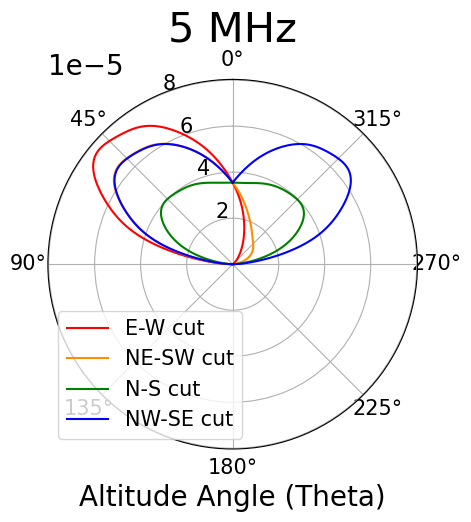

In [323]:

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# Set theta = 0 at the top (North)
ax.set_theta_zero_location('N')
u=beam_halves1[0]
d=beam_halves2[0]
#plt.polar(test_beam_raw[0].transpose()[0][n:n+179]*(np.pi/180),test_beam_raw[0].transpose()[2][n:n+179])
#plt.polar(test_beam_raw[0].transpose()[0][t:t+179]*(np.pi/180),test_beam_raw[0].transpose()[2][t:t+179])
color = ["red","darkorange","green",'blue']
theta = np.arange(0,91)
phi = np.ones_like(theta)*0
plt.title("5 MHz",fontsize=30)
for i in range(len(beam_halves1)):

    plt.polar(theta*(np.pi/180),u[i],label=labels[i],c=color[i])
    plt.polar(-theta*(np.pi/180),d[i],c=color[i])
    plt.xlabel("Altitude Angle (Theta)",fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.savefig(save_path+"polar_5Mhz")

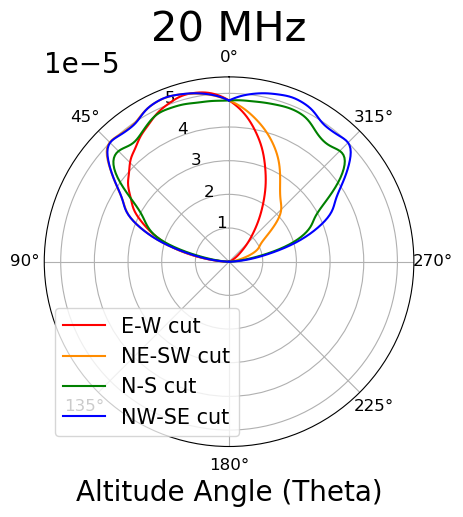

In [324]:

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# Set theta = 0 at the top (North)
ax.set_theta_zero_location('N')
u=beam_halves1[1]
d=beam_halves2[1]
#plt.polar(test_beam_raw[0].transpose()[0][n:n+179]*(np.pi/180),test_beam_raw[0].transpose()[2][n:n+179])
#plt.polar(test_beam_raw[0].transpose()[0][t:t+179]*(np.pi/180),test_beam_raw[0].transpose()[2][t:t+179])
color = ["red","darkorange","green",'blue']
theta = np.arange(0,91)
phi = np.ones_like(theta)*0
plt.title("20 MHz",fontsize=30)
for i in range(len(beam_halves1)):

    plt.polar(theta*(np.pi/180),u[i],label=labels[i],c=color[i])
    plt.polar(-theta*(np.pi/180),d[i],c=color[i])
    plt.xlabel("Altitude Angle (Theta)",fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)
plt.savefig(save_path+"polar_20Mhz")

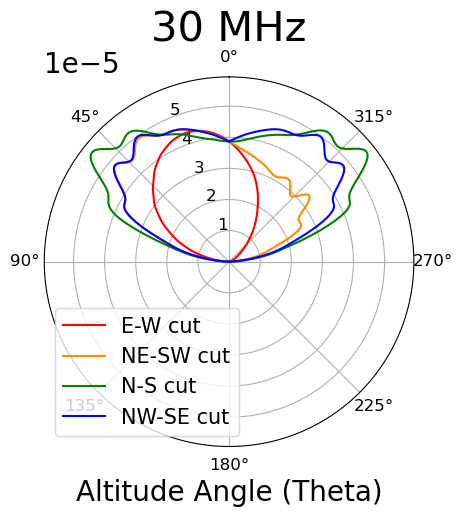

In [325]:

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# Set theta = 0 at the top (North)
ax.set_theta_zero_location('N')
u=beam_halves1[2]
d=beam_halves2[2]
#plt.polar(test_beam_raw[0].transpose()[0][n:n+179]*(np.pi/180),test_beam_raw[0].transpose()[2][n:n+179])
#plt.polar(test_beam_raw[0].transpose()[0][t:t+179]*(np.pi/180),test_beam_raw[0].transpose()[2][t:t+179])
color = ["red","darkorange","green",'blue']
plt.title("30 MHz",fontsize=30)
for i in range(len(beam_halves1)):

    plt.polar(theta*(np.pi/180),u[i],label=labels[i],c=color[i])
    plt.polar(-theta*(np.pi/180),d[i],c=color[i])
    plt.xlabel("Altitude Angle (Theta)",fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)
plt.savefig(save_path+"polar_30Mhz")

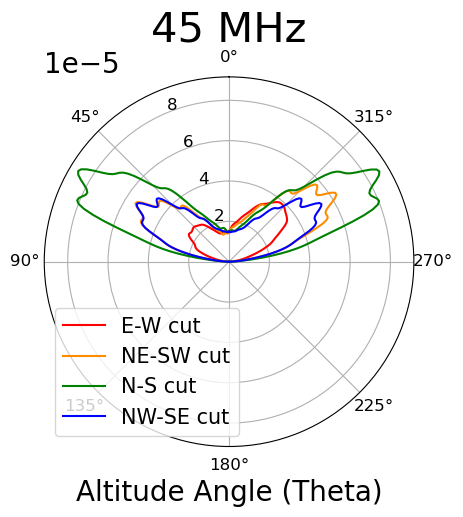

In [326]:

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
# Set theta = 0 at the top (North)
ax.set_theta_zero_location('N')
u=beam_halves1[3]
d=beam_halves2[3]
#plt.polar(test_beam_raw[0].transpose()[0][n:n+179]*(np.pi/180),test_beam_raw[0].transpose()[2][n:n+179])
#plt.polar(test_beam_raw[0].transpose()[0][t:t+179]*(np.pi/180),test_beam_raw[0].transpose()[2][t:t+179])
color = ["red","darkorange","green",'blue']
theta = np.arange(0,91)
phi = np.ones_like(theta)*0
plt.title("45 MHz",fontsize=30)
for i in range(len(beam_halves1)):

    plt.polar(theta*(np.pi/180),u[i],label=labels[i],c=color[i])
    plt.polar(-theta*(np.pi/180),d[i],c=color[i])
    plt.xlabel("Altitude Angle (Theta)",fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)
plt.savefig(save_path+"polar_45Mhz")

In [ ]:
# Handy little shortcut for filling in the path differences

def path_difference (start,end,delta):
    """Creates the path difference array instead of having to do it manually
    Parameters
    ==============================================================================
    start: what number to start at
    end: what number to end at
    delta: the difference between entries
    """
    array = np.arange(start,end+delta,delta)
    list = []
    for i in array:
        if i < 1000:
            list.append("00"+f"{i}")
        elif i <10000:
            list.append("0"+f"{i}")
        else: list.append(f"{i}")
    return list

# needed for the plots
# This code was created using gemini AI (very minor changes)
path_difference_array = path_difference(500,75000,500)
def animate_images(image_folder, output_path,path_difference_array=path_difference_array, frame_duration=200):
    """
    Animates images in a folder and saves the animation as a GIF.

    Args:
        image_folder (str): Path to the folder containing the images.
        output_path (str): Path to save the output GIF file.
        path_difference_array: the list of differerent file numbers
        frame_duration (int, optional): Duration of each frame in milliseconds. Defaults to 200.
    """
    # image_files = sorted([os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))],key=int)
    image_files = []
    for i,j in enumerate(path_difference_array):
        image_files.append(image_folder+f"/{int(j)/1000}MHz.png")

    fig, ax = plt.subplots(figsize=(20, 10))
    ims = []
    for image_file in image_files:
        img = Image.open(image_file)
        im = ax.imshow(img, animated=True)
        ims.append([im])

    ani = animation.ArtistAnimation(fig, ims, interval=frame_duration, blit=True, repeat_delay=1000)
    ani.save(output_path, writer='pillow')
    plt.close(fig)

MovieWriter ffmpeg unavailable; using Pillow instead.


/home/dbarker7752/anaconda3/lib/python3.12/site-packages/healpy/newvisufunc.py:407: UserWarning: 
 *** Overriding default plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn(
/home/dbarker7752/anaconda3/lib/python3.12/site-packages/healpy/newvisufunc.py:411: UserWarning: 
 *** New plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 20.0, 'figure_size_ratio': 0.5} ***
  warnings.warn("\n *** New plot properies: " + str(plot_properties) + " ***")


IndexError: list index out of range

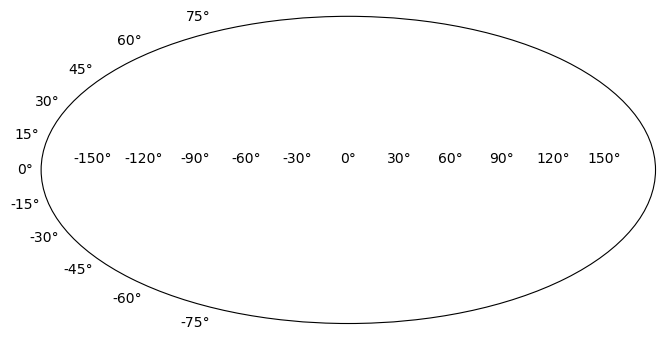

In [ ]:
import healpy as hp
import matplotlib.pyplot as plt
from matplotlib import animation

override_plot_properties={"figure_width": 20.0,"figure_size_ratio": 0.5}

def get_map_for_frame(frame):
    map=galaxy_map_64[frame]
    return map



# Assuming you have a function `update(frame)` that takes a frame number
# and returns a healpy map (a numpy array)
def update(frame):
    m = get_map_for_frame(frame) # Your function to get the map
    plt.clf() # Clear previous plot
    hp.projview(m, sub=(1,1,1), hold=True,title=f"{frame+1}MHz",override_plot_properties=override_plot_properties,cmap="magma") # Plot the new map
    return [] # Return an empty list of artists for the animation

fig = plt.figure()
anim = animation.FuncAnimation(fig, update, frames=50, blit=False)
anim.save("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/ULSA_animation2.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.
/home/dbarker7752/anaconda3/lib/python3.12/site-packages/healpy/newvisufunc.py:407: UserWarning: 
 *** Overriding default plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn(
/home/dbarker7752/anaconda3/lib/python3.12/site-packages/healpy/newvisufunc.py:411: UserWarning: 
 *** New plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 20.0, 'figure_size_ratio': 0.5} ***
  warnings.warn("\n *** New plot properies: " + str(plot_properties) + " ***")
/home/dbarker7752/anaconda3/lib/python3.12/site-packages/healpy/newvisufunc.py:407: UserWarning: 
 *** Overriding default plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick

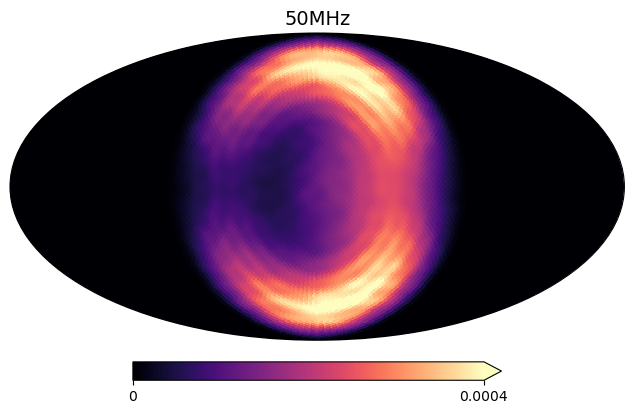

In [63]:
import healpy as hp
import matplotlib.pyplot as plt
from matplotlib import animation

override_plot_properties={"figure_width": 20.0,"figure_size_ratio": 0.5}

def get_map_for_frame(frame):
    map=beams[0][frame]
    return map



# Assuming you have a function `update(frame)` that takes a frame number
# and returns a healpy map (a numpy array)
def update(frame):
    m = get_map_for_frame(frame) # Your function to get the map
    plt.clf() # Clear previous plot
    hp.projview(m, sub=(1,1,1), hold=True,title=f"{frame+1}MHz",override_plot_properties=override_plot_properties,min=0,max=0.0004,cmap="magma") # Plot the new map
    return [] # Return an empty list of artists for the animation

fig = plt.figure()
anim = animation.FuncAnimation(fig, update, frames=50, blit=False)
anim.save("/home/dbarker7752/21_cm_group/Comps_Figures_and_Data/beam_animation2.gif")

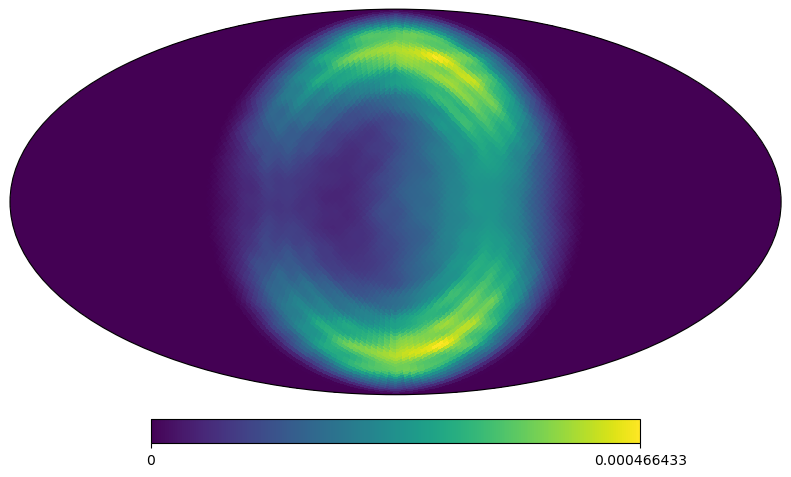

In [60]:
hp.projview(beams[0][49])

In [5]:
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.animation import FuncAnimation

/home/dbarker7752/anaconda3/lib/python3.12/site-packages/healpy/newvisufunc.py:407: UserWarning: 
 *** Overriding default plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_ratio': 0.63} ***
  warnings.warn(
/home/dbarker7752/anaconda3/lib/python3.12/site-packages/healpy/newvisufunc.py:411: UserWarning: 
 *** New plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 20.0, 'figure_size_ratio': 0.5} ***
  warnings.warn("\n *** New plot properies: " + str(plot_properties) + " ***")
/home/dbarker7752/anaconda3/lib/python3.12/site-packages/healpy/newvisufunc.py:407: UserWarning: 
 *** Overriding default plot properies: {'cbar_shrink': 0.6, 'cbar_pad': 0.05, 'cbar_label_pad': -8, 'cbar_tick_direction': 'out', 'vertical_tick_rotation': 90, 'figure_width': 8.5, 'figure_size_rati

Text(0.5, 1.0, 'ULSA Galaxy Map at 9 MHz')

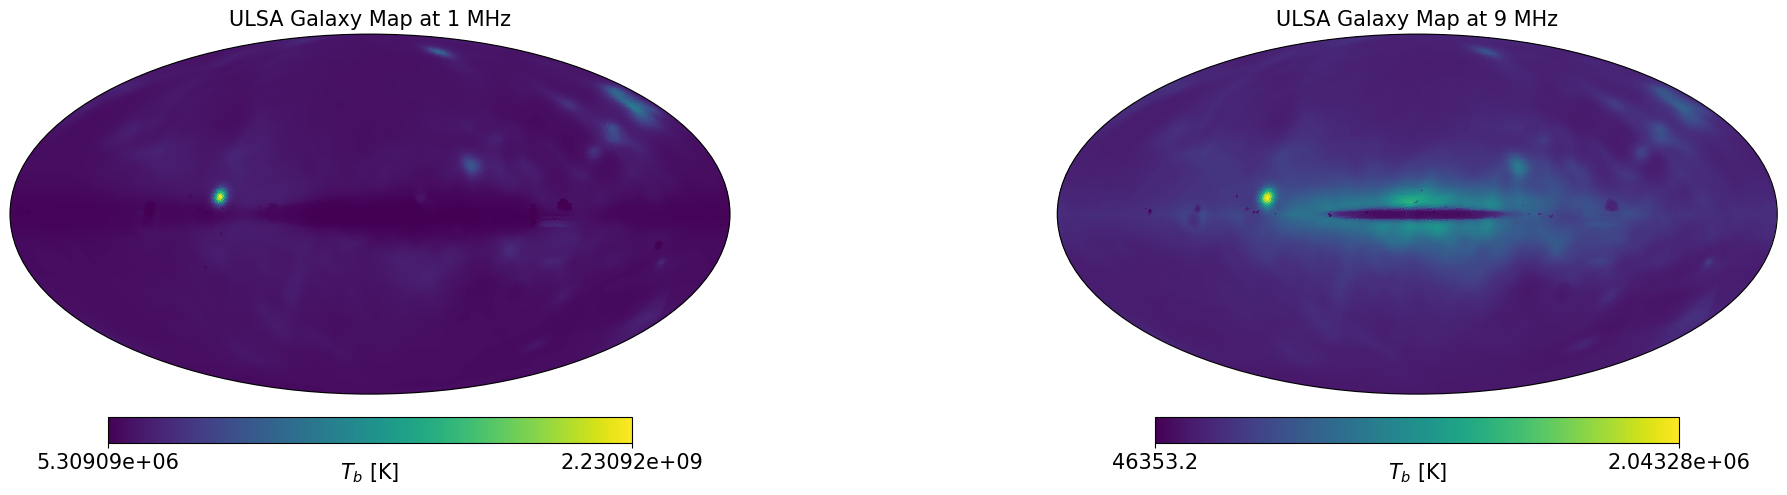

In [22]:

# fig = plt.subplots(1, 2, figsize=(20, 5)) # Example with two subplo
fontsize = dict(cbar_label=15, cbar_tick_label=15)
# fontsize["cbar_label"] = 1
# Standard unrotated galaxy
override_plot_properties={
        "figure_width": 20.0,
        "figure_size_ratio": 0.5}
hp.projview(galaxy_map_64[0],unit=r"$T_b$ [K]",cmap= cmap,fontsize=fontsize,sub=(1,2,1),override_plot_properties=override_plot_properties)
plt.title("ULSA Galaxy Map at 1 MHz" ,fontsize=15)
hp.projview(galaxy_map_64[10],unit=r"$T_b$ [K]",cmap= cmap,fontsize=fontsize,sub=(1,2,2),override_plot_properties=override_plot_properties)
plt.title("ULSA Galaxy Map at 9 MHz" ,fontsize=15)

In [ ]:
fig = 

In [ ]:
ani = FuncAnimation(fig, animate, frames=200, init_func=init, blit=True, interval=50)


In [49]:
beams

<HDF5 dataset "normalized_beams": shape (221, 50, 12288), type "<f8">